# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle
import shap
import joblib
from statannot.statannot import add_stat_annotation
from lib.data_load_utils import load_CULPRIT_data, get_data_from_features
from lib.experiment_definitions import get_features


SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Figure 1

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `

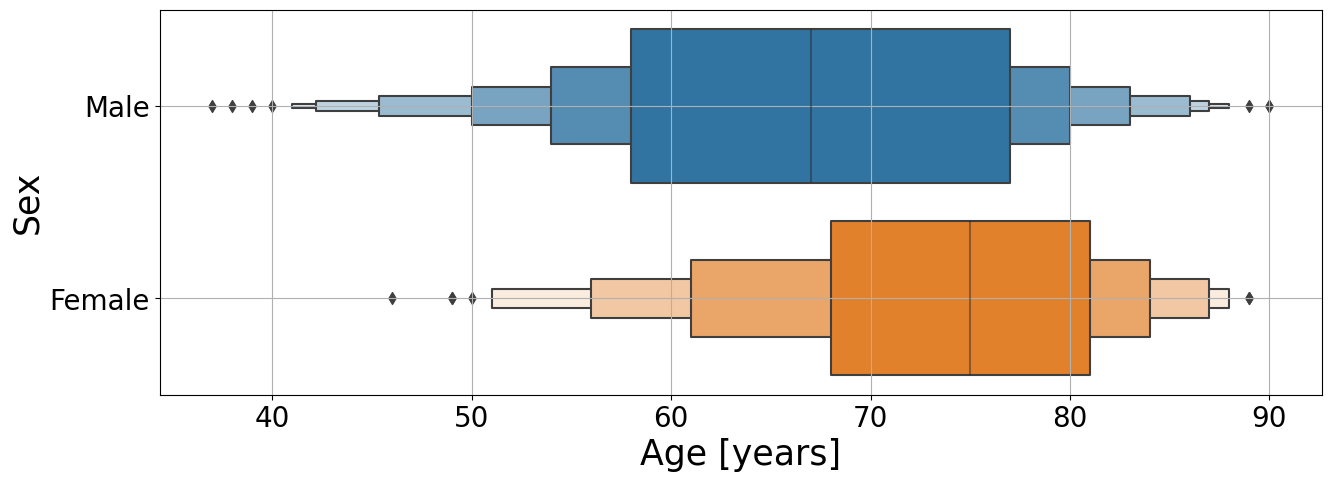

In [4]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/CULPRIT_data/202302_Jung/" # noqa
# endpoint to use
endpoint_to_use = "fu_ce_death_le30d_yn"    # or "fu_ce_death_le365d_yn"

# Get different features depending on the model
# Get all data
patient_info = load_CULPRIT_data(data_dir)
# Set target
y = patient_info.loc[:, ["patient_ID", endpoint_to_use]]


# Extract all the 24hs available features
exp_name = "Admission"
patient_features = get_features(exp_name)

data = get_data_from_features(patient_info, patient_features)

patient_measures = pd.concat([data, y["fu_ce_death_le30d_yn"]], axis=1)

patient_measures.rename(columns={"had_dem_age_yr": "Age"}, inplace=True)

patient_measures.rename(columns={"had_dem_male_yn": "Sex"}, inplace=True)
a = patient_measures["Sex"].unique()
patient_measures["Sex"].replace({1: "Male", 0: "Female", a[2]: "Male"}, inplace=True)
patient_measures.rename(columns={"fu_ce_death_le30d_yn": "30-day outcome"}, inplace=True)
patient_measures["30-day outcome"].replace({1: "Expired", 0: "Alive",}, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=[15, 5])

sns.boxenplot(data=patient_measures, x="Age",
              ax=ax, y="Sex")
plt.xlabel("Age [years]")
plt.grid(["x"])
plt.ylabel("Sex")
plt.show()

In [4]:
print(patient_measures["Age"].mean())
print(patient_measures["Age"].std())


68.57871720116619
11.347416778681616


# IABP relationship with target

Text(0, 0.5, 'Patient count')

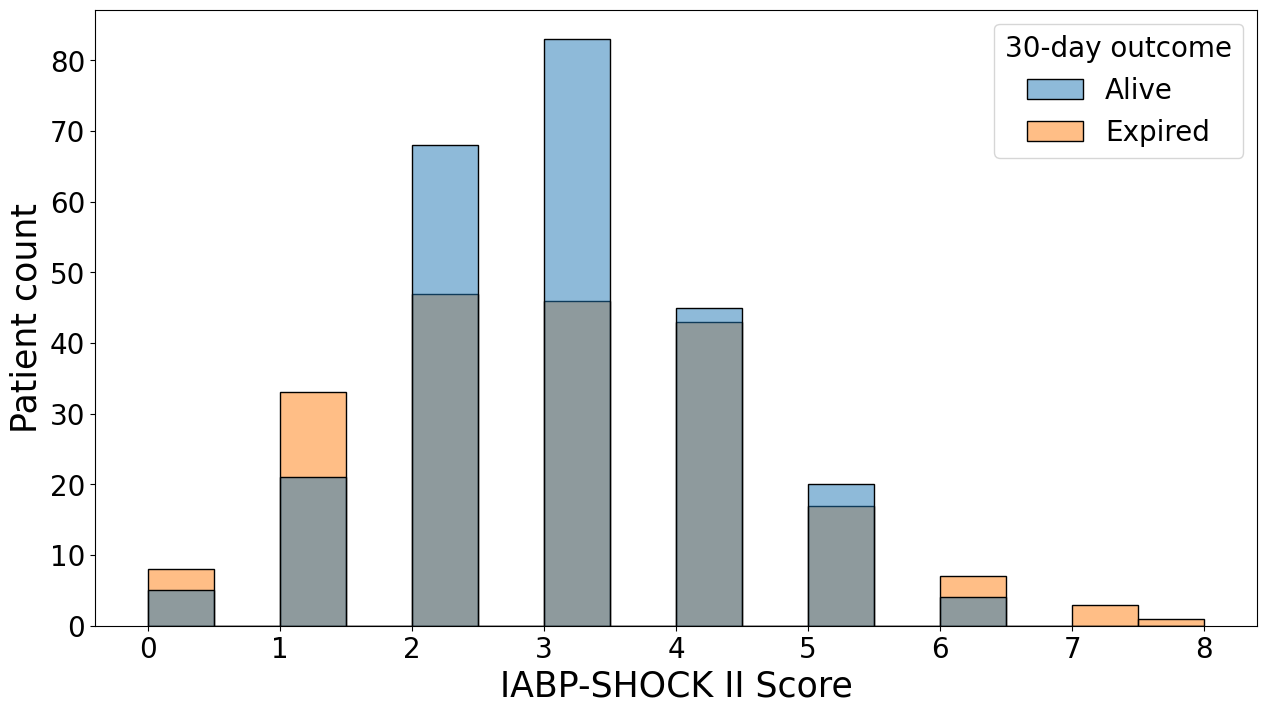

In [15]:
import seaborn as sbn
plt.figure(figsize=[15,8])

patient_info.rename(columns={"fu_ce_death_le30d_yn": "30-day outcome"}, inplace=True)
patient_info.rename(columns={"had_dem_iabpscore_c": "IABP-SHOCK II Score"}, inplace=True)
patient_info["30-day outcome"].replace({1: "Expired", 0: "Alive"}, inplace=True)

sbn.histplot(patient_info, x="IABP-SHOCK II Score", hue="30-day outcome")
plt.ylabel("Patient count")


# Fig complementary to Shap Smokers

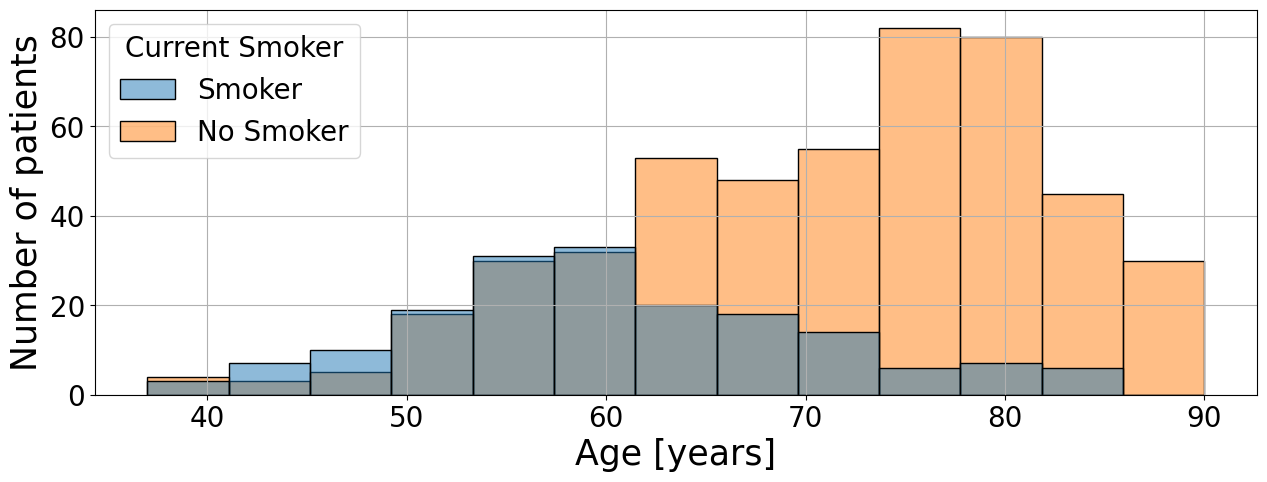

In [5]:
patient_measures.rename(columns={"had_dem_male_yn": "Sex"}, inplace=True)
patient_measures["Sex"].replace({1: "Male", 0: "Female"}, inplace=True)
patient_measures.rename(columns={"p_rf_smoker_yn": "Current Smoker"},
                        inplace=True)

fig, ax = plt.subplots(1, 1, figsize=[15, 5])
patient_measures["Current Smoker"].replace({1: "Smoker", 0: "No Smoker"},
                                           inplace=True)

sns.histplot(data=patient_measures, x="Age", hue="Current Smoker")

plt.xlabel("Age [years]")
plt.grid(["x"])
plt.ylabel("Number of patients")
plt.show()

# Figure 4 -  Train and test performance


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


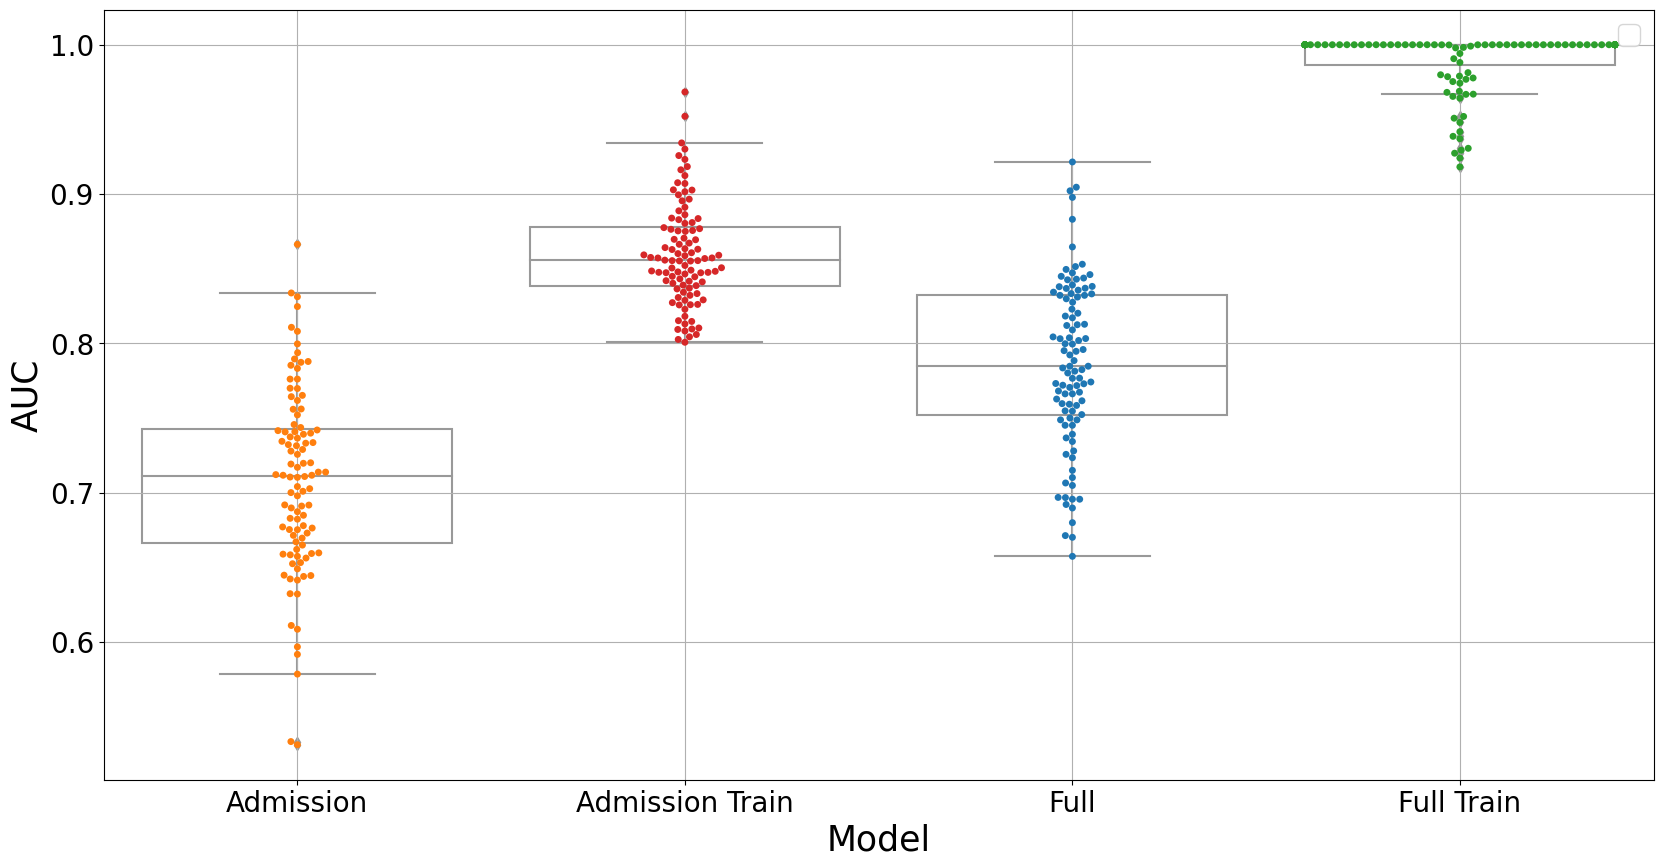

In [2]:

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"
results_full = pd.read_csv(results_dir + "Full_big_experiment_direct_remove_v3.csv", index_col=0)

results_full_filter = results_full[results_full["Thresholds"] == 0.5]
results_full_filter = results_full_filter[results_full_filter["Number of Removed Features"] == 0]

results_full_filter["Random State"] =  False


results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"
results_admission_optuna = pd.read_csv(results_dir + "Admission_big_experiment_direct_remove.csv", index_col=0)

results_admission_optuna = results_admission_optuna[results_admission_optuna["Thresholds"] == 0.5]
results_admission_optuna = results_admission_optuna[results_admission_optuna["Number of Removed Features"] == 0]

results_admission_optuna["Random State"] =  False


results_full_train = pd.read_csv(results_dir + "Full_big_experiment_training_v3.csv", index_col=0)
results_full_train = results_full_train[results_full_train["Thresholds"] == 0.5]
results_full_train = results_full_train[results_full_train["Number of Removed Features"] == 0]
results_full_train["Random State"] =  False

results_admission_train = pd.read_csv(results_dir + "Admission_big_experiment_training.csv", index_col=0)
results_admission_train = results_admission_train[results_admission_train["Thresholds"] == 0.5]
results_admission_train = results_admission_train[results_admission_train["Number of Removed Features"] == 0]
results_admission_train["Random State"] =  False


results = pd.concat([results_full_filter, results_admission_optuna, results_full_train, results_admission_train])

# 
results_true_label = results[results["Random State"]== False]

# results_true_label.replace({"Admission_Train": "Admission Train", "24hs_Train": "Full Train"}, inplace= True)

metric_to_plot = "AUC"

models_to_plot = [
                "Admission",
                "Admission Train", 
                "Full",
                "Full Train", 

                ]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])


sns.swarmplot(
    data=results_true_label,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
    # palette=[[1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           [1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           ]
)

sns.boxplot(
    data=results_true_label, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot,
    dodge=True, ax=ax
)
plt.legend([])
plt.grid()

In [9]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_admission = pd.read_csv(data_dir + "Admission_big_experiment_random_remove.csv", index_col=0)
results_admission = results_admission[results_admission["Thresholds"] == 0.5]
results_admission = results_admission[results_admission["Number of Removed Features"] == 0]

results_24hs = pd.read_csv(data_dir + "Full_big_experiment_random_remove_v3.csv", index_col=0)
results_24hs = results_24hs[results_24hs["Thresholds"] == 0.5]
results_24hs = results_24hs[results_24hs["Number of Removed Features"] == 0]


results_scores = pd.read_csv("/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/v2/metrics_10x10_true_and_random_labels_scores_v3.csv", index_col=0)

results_df = pd.concat([results_admission,results_24hs,results_scores])

results_true_label = results_df[results_df["Random State"]== False]


models_to_plot = [
                "Full",
                  "Admission",
                #   "24hs",
                  "SAPS_SCORE",
                  "CLIP_SCORE", 
                  ]

metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)
        confidence_interval = stats.t.interval(0.95, len(results_true_label[results_true_label["Model"] == model][metric]) - 1, loc=results_mean, scale=results_std)

        print(metric + ": " + str(results_mean) + " ["+str(round(confidence_interval[0],3)) + "/" + str(round(confidence_interval[1],3))+"]")


# Full v3
# Balanced ACC: 0.704 [0.591/0.817]
# AUC: 0.786 [0.675/0.897]
# F1: 0.631 [0.472/0.79]
# Specificity: 0.808 [0.677/0.939]
# Sensitivity: 0.601 [0.389/0.813]

Full
Balanced ACC: 0.704 [0.591/0.817]
AUC: 0.786 [0.675/0.897]
F1: 0.631 [0.472/0.79]
Specificity: 0.808 [0.677/0.939]
Sensitivity: 0.601 [0.389/0.813]
Admission
Balanced ACC: 0.639 [0.524/0.754]
AUC: 0.708 [0.585/0.831]
F1: 0.611 [0.476/0.746]
Specificity: 0.679 [0.52/0.838]
Sensitivity: 0.599 [0.426/0.772]
SAPS_SCORE
Balanced ACC: 0.597 [0.49/0.704]
AUC: 0.677 [0.536/0.818]
F1: 0.423 [0.219/0.627]
Specificity: 0.858 [0.733/0.983]
Sensitivity: 0.336 [0.13/0.542]
CLIP_SCORE
Balanced ACC: 0.663 [0.552/0.774]
AUC: 0.794 [0.653/0.935]
F1: 0.534 [0.334/0.734]
Specificity: 0.898 [0.791/1.005]
Sensitivity: 0.429 [0.213/0.645]


The label '_' of <matplotlib.lines.Line2D object at 0x7fd2461828b0> starts with '_'. It is thus excluded from the legend.
The label '_' of <matplotlib.collections.PathCollection object at 0x7fd246182b50> starts with '_'. It is thus excluded from the legend.
The label '_' of <matplotlib.patches.Rectangle object at 0x7fd2461824c0> starts with '_'. It is thus excluded from the legend.
The label '_' of <matplotlib.lines.Line2D object at 0x7fd24618e5b0> starts with '_'. It is thus excluded from the legend.
The label '_' of <matplotlib.collections.PathCollection object at 0x7fd24618e880> starts with '_'. It is thus excluded from the legend.
The label '_' of <matplotlib.lines.Line2D object at 0x7fd24618ec10> starts with '_'. It is thus excluded from the legend.
The label '_,' of <matplotlib.collections.PathCollection object at 0x7fd24619e280> starts with '_'. It is thus excluded from the legend.
The label '_' of <matplotlib.lines.Line2D object at 0x7fd24619e6a0> starts with '_'. It is thus ex

p-value annotation legend:
ns: 1.00e-03 < p <= 1.00e+00
*p<0.001: p <= 1.00e-03

Full_False v.s. Full_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.022e-59 U_stat=9.949e+04
Admission_False v.s. Admission_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.542e-50 U_stat=9.513e+04


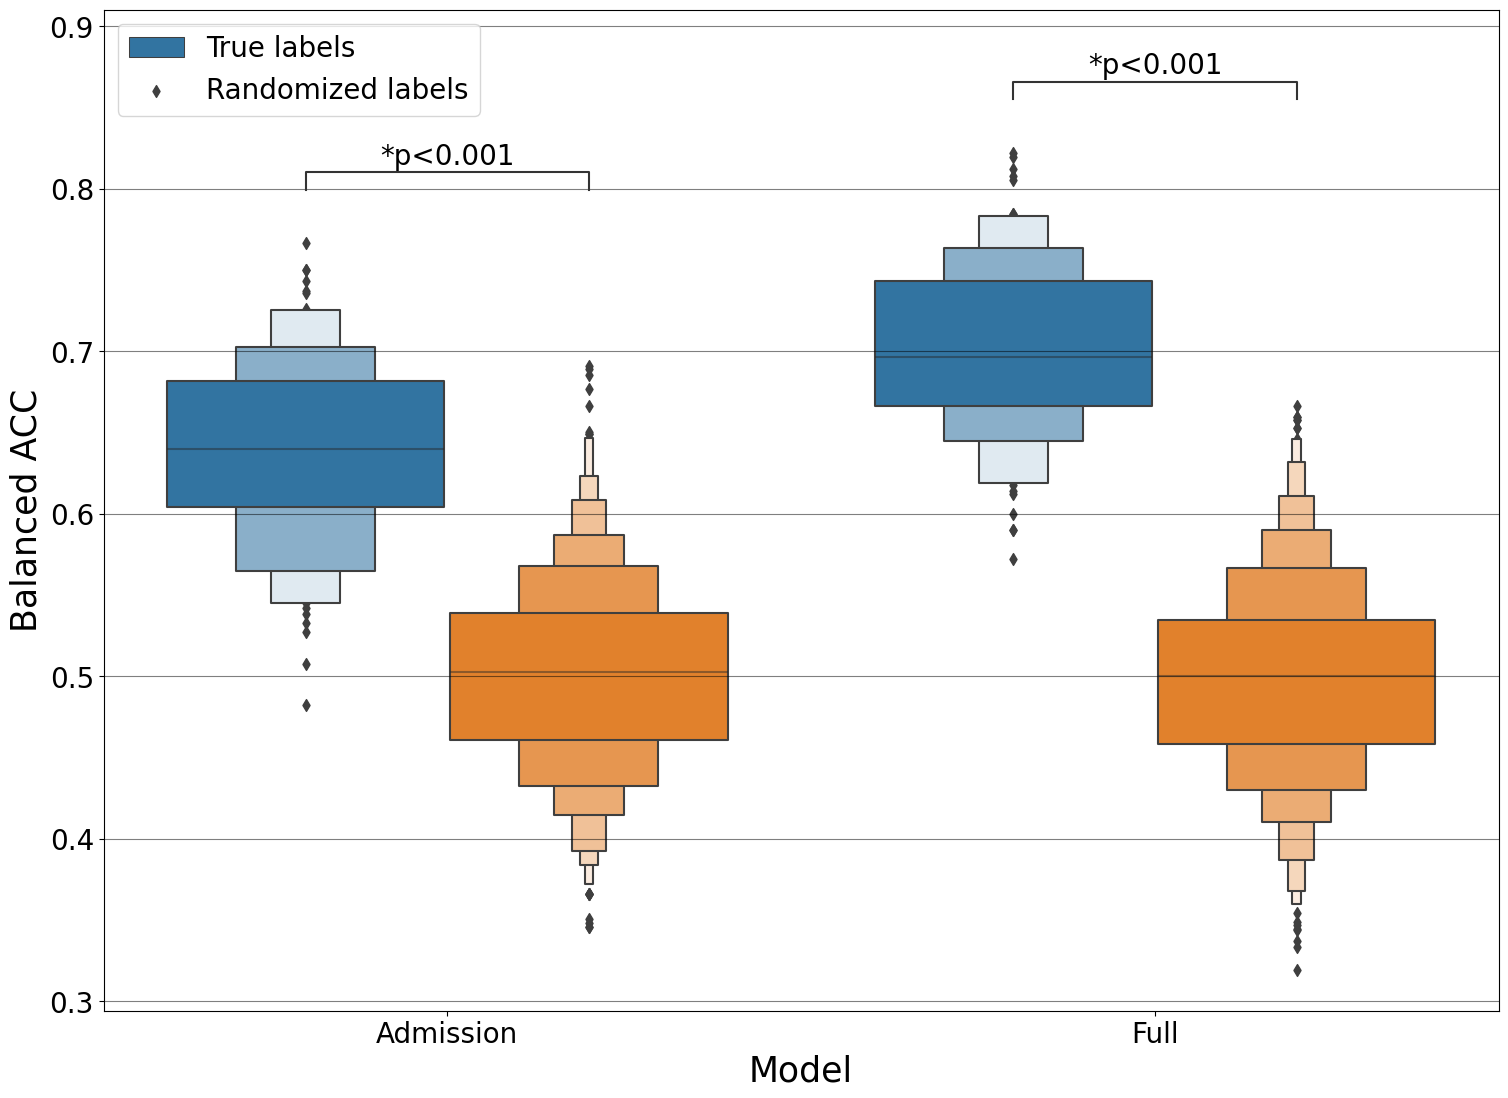

In [27]:
# Load OPTUNA DATA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_24hs_permuted = pd.read_csv(results_dir + "Full_permutation_test.csv")
results_24hs_permuted  = results_24hs_permuted[results_24hs_permuted["Thresholds"]==0.5]
results_24hs_permuted  = results_24hs_permuted[results_24hs_permuted["Number of Removed Features"]==0]

results_24hs_permuted = results_24hs_permuted.drop_duplicates(subset=['Fold', "Random Permutation Number"], keep='first')

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_24hs = pd.read_csv(results_dir + "Full_big_experiment_inverse_remove_v2.csv")
results_24hs  = results_24hs[results_24hs["Thresholds"]==0.5]
results_24hs  = results_24hs[results_24hs["Number of Removed Features"]==0]
results_24hs  = results_24hs[results_24hs["Random State"]==False]


results_admission_permuted = pd.read_csv(results_dir + "Admission_permutation_test.csv")
results_admission_permuted  = results_admission_permuted[results_admission_permuted["Thresholds"]==0.5]


results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_admission = pd.read_csv(results_dir + "Admission_big_experiment_inverse_remove.csv")
results_admission  = results_admission[results_admission["Thresholds"]==0.5]
results_admission  = results_admission[results_admission["Number of Removed Features"]==0]
results_admission  = results_admission[results_admission["Random State"]==False]
models_to_plot = [
    "Admission",
    "Full", 
]

res = pd.concat([results_admission, results_admission_permuted, results_24hs,results_24hs_permuted])
metric_to_plot = "Balanced ACC"

fig, ax = plt.subplots(1, 1, figsize=[18, 13])

sns.boxenplot(
    data=res,
    x="Model", y=metric_to_plot,
    dodge=True, hue="Random State", ax=ax,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:10], labels[:10])
ax.legend(["True labels", "_", "_", "_", "_", "_","_", "_,", "_", "Randomized labels"])

# Comparisons for statistical test
box_list = [
            (("Admission", True), ("Admission", False)),

            (("Full", True), ("Full", False)),

            ]


add_stat_annotation(ax, data=res, x="Model", y=metric_to_plot,
                    box_pairs=box_list, test='Mann-Whitney', hue="Random State",
                    text_format='star', loc='inside',
                    verbose=1,
                    pvalue_thresholds=[[1, "ns"], [0.001, "*p<0.001"]])

plt.grid(alpha=0.5, axis="y", c="black")


# Compar with random distribution

p-value annotation legend:
ns: 1.00e-03 < p <= 1.00e+00
*p<0.001: p <= 1.00e-03

Full_False v.s. Full_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.022e-59 U_stat=9.949e+04
Admission_False v.s. Admission_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.542e-50 U_stat=9.513e+04


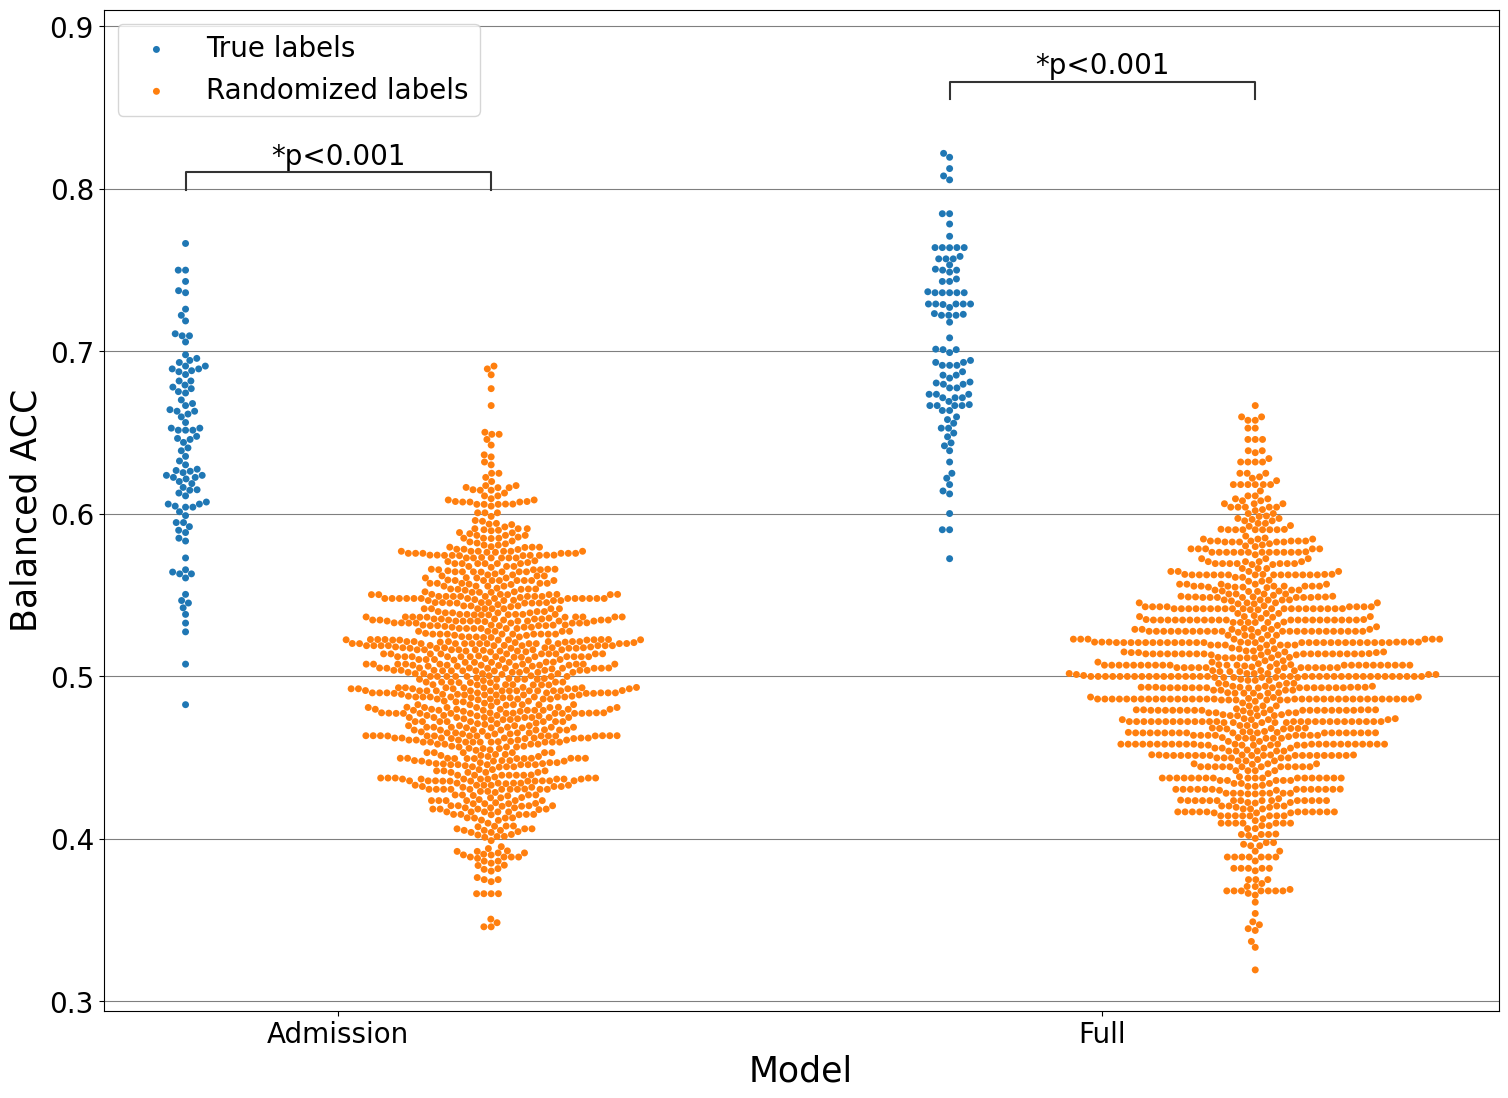

In [16]:
# Load OPTUNA DATA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_24hs_permuted = pd.read_csv(results_dir + "Full_permutation_test.csv")
results_24hs_permuted  = results_24hs_permuted[results_24hs_permuted["Thresholds"]==0.5]
results_24hs_permuted  = results_24hs_permuted[results_24hs_permuted["Number of Removed Features"]==0]

results_24hs_permuted = results_24hs_permuted.drop_duplicates(subset=['Fold', "Random Permutation Number"], keep='first')

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_24hs = pd.read_csv(results_dir + "Full_big_experiment_inverse_remove_v2.csv")
results_24hs  = results_24hs[results_24hs["Thresholds"]==0.5]
results_24hs  = results_24hs[results_24hs["Number of Removed Features"]==0]
results_24hs  = results_24hs[results_24hs["Random State"]==False]


results_admission_permuted = pd.read_csv(results_dir + "Admission_permutation_test.csv")
results_admission_permuted  = results_admission_permuted[results_admission_permuted["Thresholds"]==0.5]


results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_admission = pd.read_csv(results_dir + "Admission_big_experiment_inverse_remove.csv")
results_admission  = results_admission[results_admission["Thresholds"]==0.5]
results_admission  = results_admission[results_admission["Number of Removed Features"]==0]
results_admission  = results_admission[results_admission["Random State"]==False]
models_to_plot = [
    "Admission",
    "Full", 
]

res = pd.concat([results_admission, results_admission_permuted, results_24hs,results_24hs_permuted])
metric_to_plot = "Balanced ACC"

fig, ax = plt.subplots(1, 1, figsize=[18, 13])

sns.swarmplot(
    data=res,
    x="Model", y=metric_to_plot,
    dodge=True, hue="Random State", ax=ax,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:models_to_plot.__len__()], labels[:models_to_plot.__len__()])
ax.legend(["True labels", "Randomized labels"])

# Comparisons for statistical test
box_list = [
            (("Admission", True), ("Admission", False)),

            (("Full", True), ("Full", False)),

            ]


add_stat_annotation(ax, data=res, x="Model", y=metric_to_plot,
                    box_pairs=box_list, test='Mann-Whitney', hue="Random State",
                    text_format='star', loc='inside',
                    verbose=1,
                    pvalue_thresholds=[[1, "ns"], [0.001, "*p<0.001"]])

plt.grid(alpha=0.5, axis="y", c="black")


p-value annotation legend:
ns: 1.00e-03 < p <= 1.00e+00
*p<0.001: p <= 1.00e-03

Full_False v.s. Full_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.185e-32 U_stat=9.894e+03
Admission_False v.s. Admission_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.131e-27 U_stat=9.450e+03


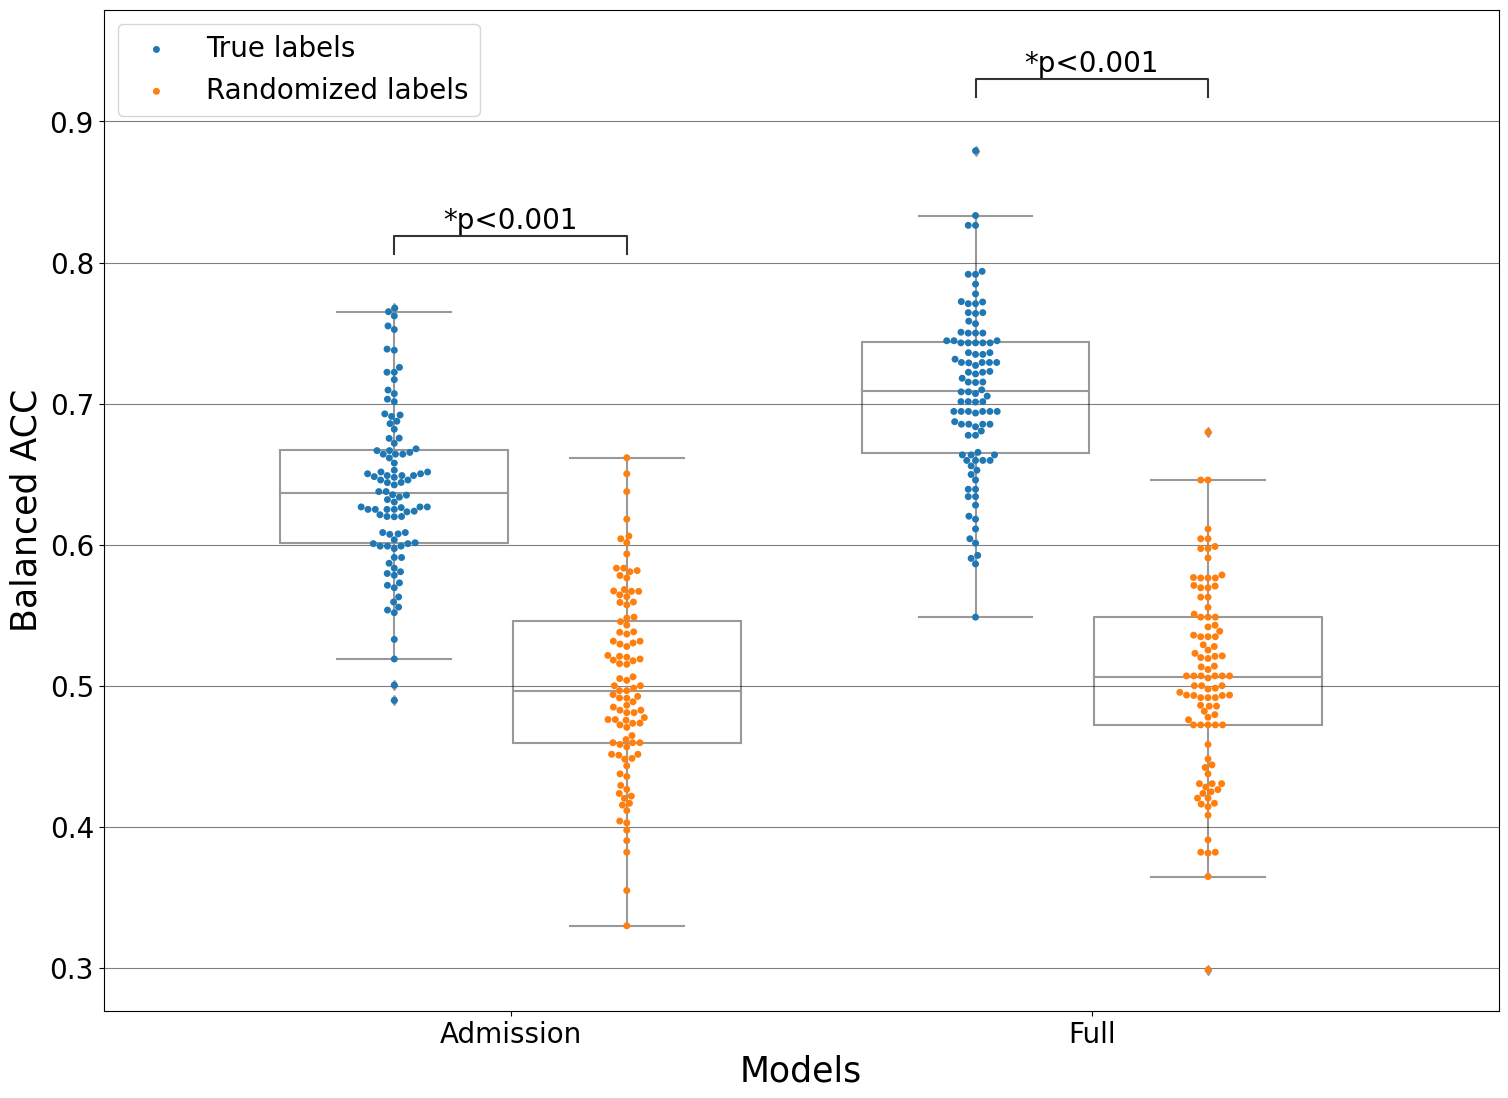

In [3]:
# THE DATA IS SET IN THE PREVIUS CELL
# LOAD DATA FROM RANDOM DISTRIBUTIONS

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/v2/"
results_24hs = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_24hs_v2.csv")
results_admission = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_admission_v2.csv")

results_df = pd.concat([results_24hs, results_admission])
# Change Naming
results_df["Model"].replace({"SAPS_SCORE": "SAPS II SCORE",
                             "CLIP_SCORE": "CLIP SCORE",
                             "IABP_SCORE": "IABP II SCORE"}, inplace=True)

results_false_label = results_df[results_df["Random State"]== True]


# Load OPTUNA DATA
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_24_optuna = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_24hs_v2.csv")

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_admission_optuna = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_Admission_v2.csv")

results_scores = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_scores_v2.csv")

results_df = pd.concat([results_24_optuna, results_admission_optuna, results_scores, results_false_label])

results_df["Model"].replace({"SAPS_SCORE": "SAPS II SCORE",
                             "CLIP_SCORE": "CLIP SCORE",
                             "IABP_SCORE": "IABP II SCORE",
                             "24hs": "Full"}, inplace=True)

models_to_plot = [
    # "SAPS II SCORE",
    "Admission",
    # "CLIP SCORE",
    "Full", 
]

fig, ax = plt.subplots(1, 1, figsize=[18, 13])
filtered_df = results_df[results_df['Model'].isin(models_to_plot)]

n_models = results_df["Model"].nunique()

metric_to_plot = "Balanced ACC"

sns.swarmplot(
    data=filtered_df,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=True, hue="Random State", ax=ax,
)

sns.boxplot(
    data=filtered_df, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot, hue="Random State",
    dodge=True, ax=ax, palette=["w"]*n_models
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:models_to_plot.__len__()], labels[:models_to_plot.__len__()])
ax.legend(["True labels", "Randomized labels"])



# Comparisons for statistical test
box_list = [(("Admission", True), ("Admission", False)),
            (("Full", True), ("Full", False)),
            # (("SAPS II SCORE", True), ("SAPS II SCORE", False)),
            # (("CLIP SCORE", True), ("CLIP SCORE", False))
            ]


add_stat_annotation(ax, data=filtered_df, x="Model", y=metric_to_plot,
                    box_pairs=box_list, test='Mann-Whitney', hue="Random State",
                    text_format='star', loc='inside', order=models_to_plot,
                    verbose=1,
                    pvalue_thresholds=[[1, "ns"], [0.001, "*p<0.001"]])




plt.ylabel(metric_to_plot)
plt.xlabel("Models")
# plt.title(metric_to_plot + " in CULPRIT dataset")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

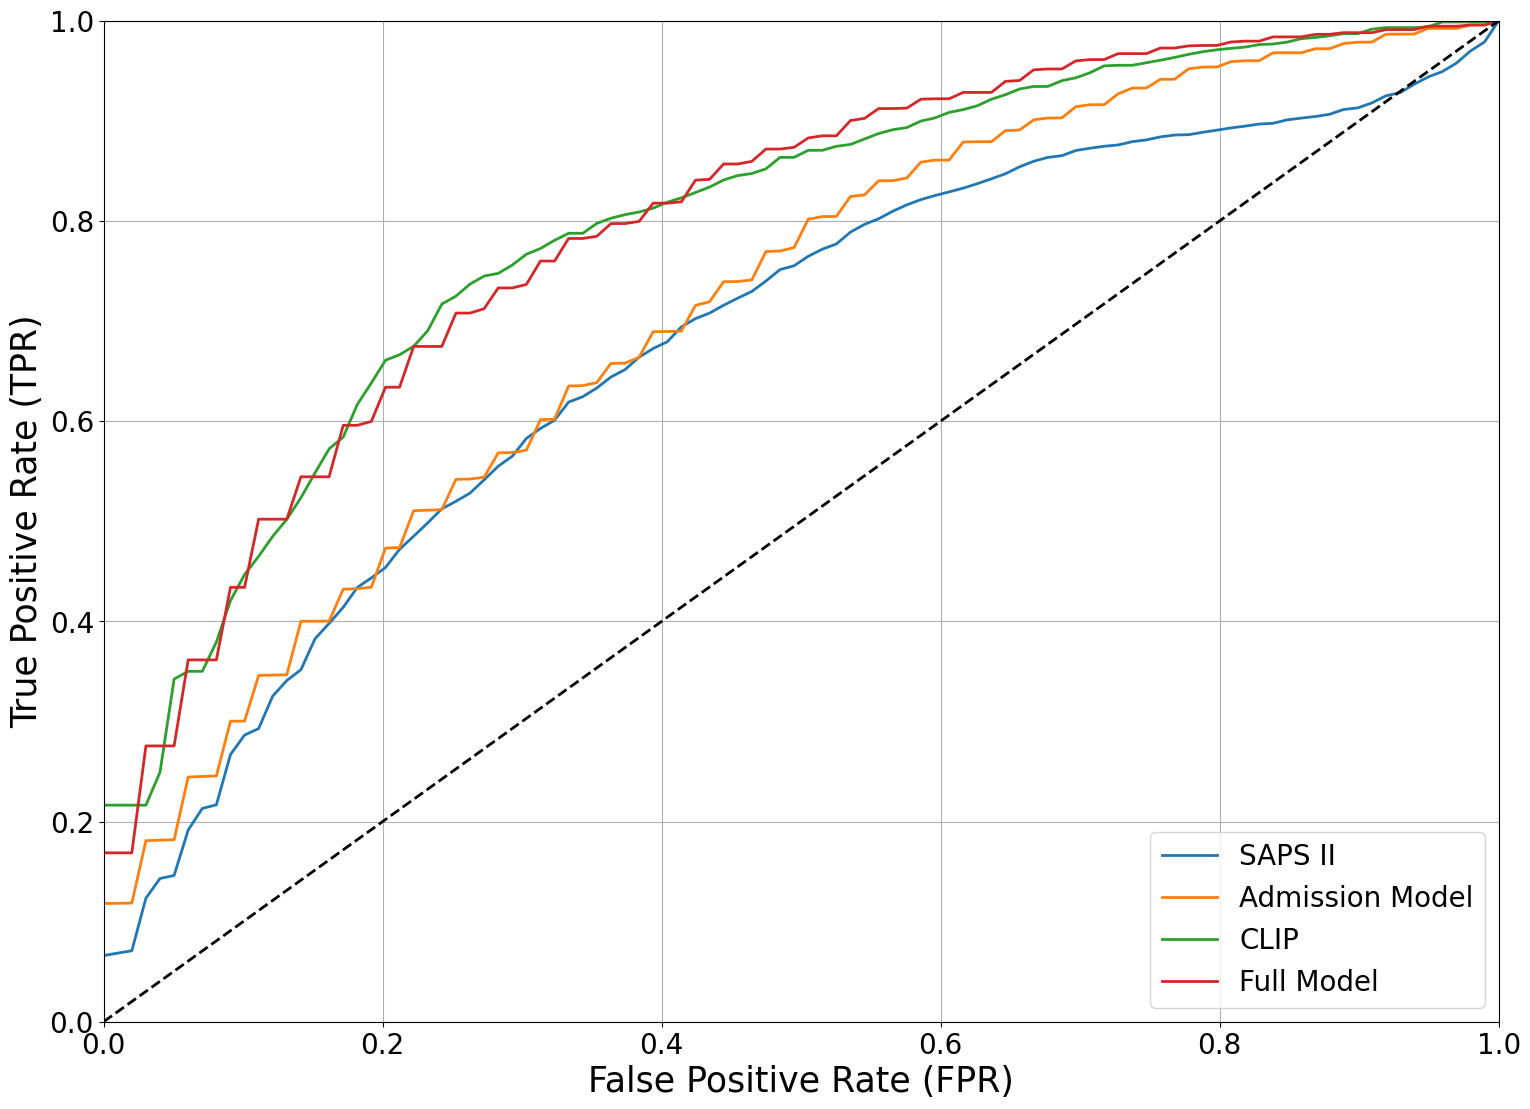

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
root_dir_scores = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/predictions/v2/"
root_dir_optuna = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/predictions/"

num_folds = 100
method_names = [["SAPS",root_dir_scores], 
                ["Admission_v2",root_dir_optuna], 
                ["CLIP",root_dir_scores],
                ["24hs_v2",root_dir_optuna]]

all_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(18, 13))

for method_name, root_dir in method_names:
    y_pred_24 = pd.read_csv(root_dir+method_name+"_predictions_for_AUC.csv", index_col=0)
    y_true_all = pd.read_csv(root_dir+"y_true_"+method_name+"_for_AUC.csv", index_col=0)
    # Initialize arrays to store accumulated TPR and FPR values
    mean_tpr = 0

    # Iterate through the folds for the current method
    for fold in y_pred_24.columns:
        y_pred = y_pred_24.loc[:,fold]
        y_pred.dropna(inplace=True)
        y_true = y_true_all.loc[:,str(fold)]
        y_true.dropna(inplace=True)

        # Calculate ROC curve for the current fold
        fpr, tpr, _ = roc_curve(y_true, y_pred)

        # Interpolate the TPR values to match the all_fpr values
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    # Calculate the mean TPR across all folds for the current method
    mean_tpr /= num_folds

    # Calculate the AUC for the average ROC curve of the current method
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve for the current method
    plt.plot(all_fpr, mean_tpr, lw=2, label=f'{method_name} (AUC = {mean_auc:.2f})')


# Plot the chance level line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance Level')

# Add labels and legend
# plt.title('Average ROC Curve across Folds')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(["SAPS II", "Admission Model", "CLIP", "Full Model"],loc='lower right')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Show the plot
plt.show()

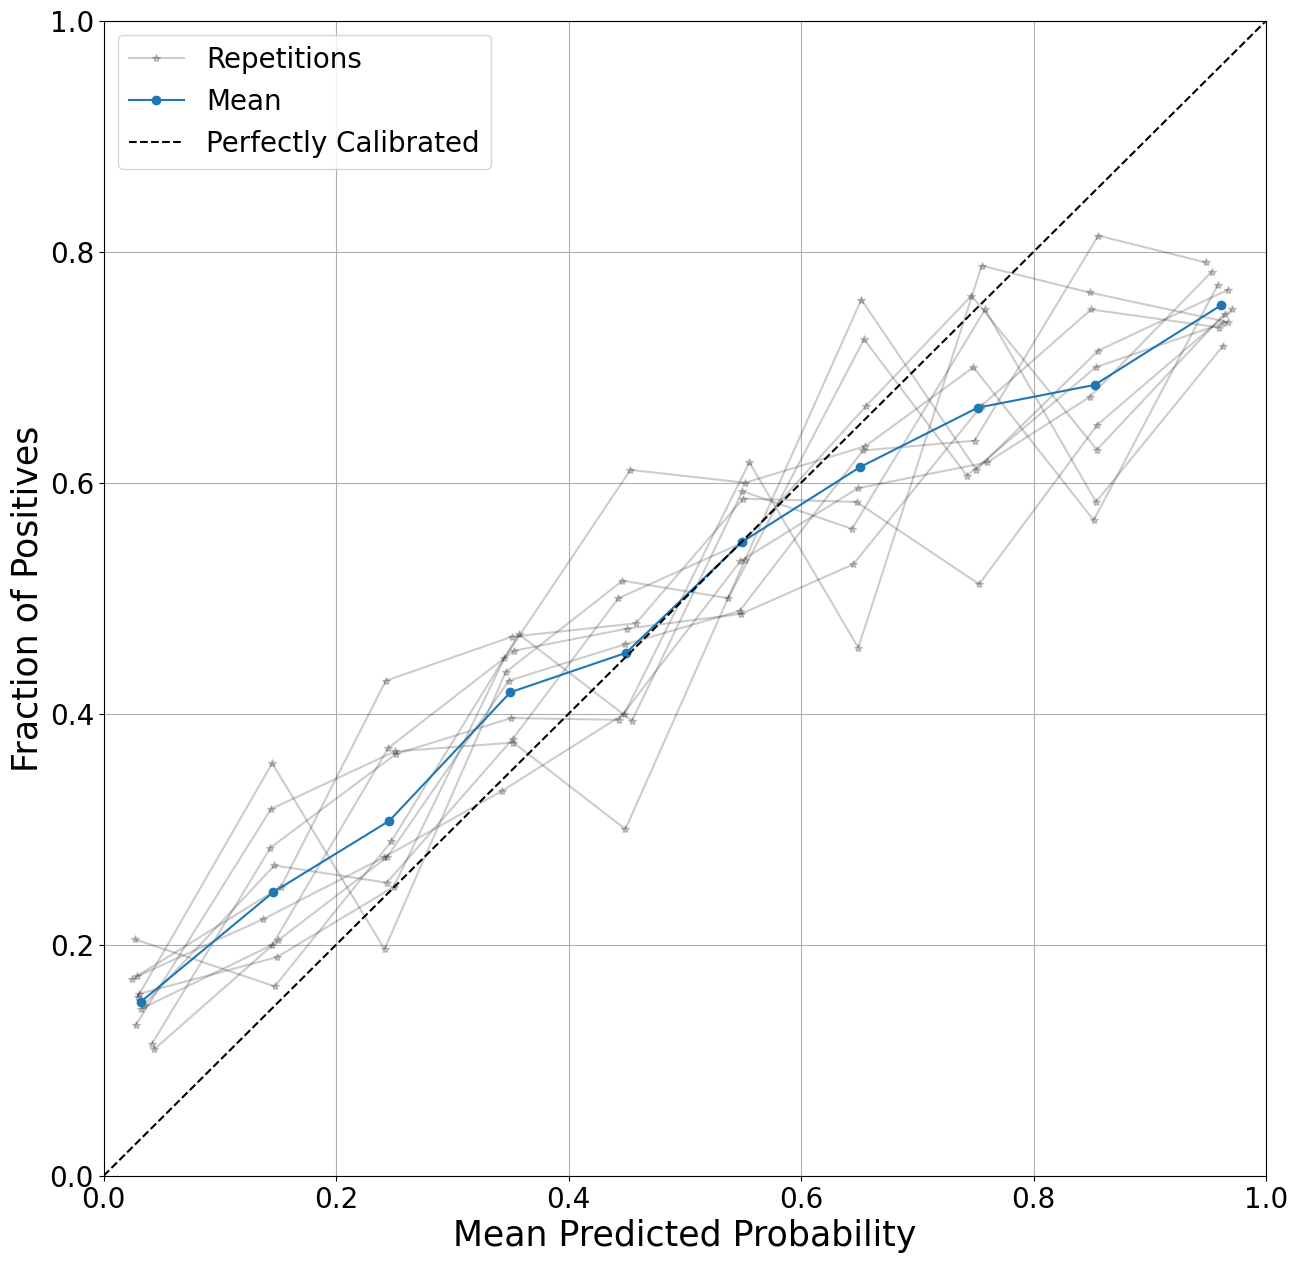

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

y_true = pd.read_csv(data_dir +"y_true_Full.csv", index_col=0)
y_pred = pd.read_csv(data_dir +"predictions_Full.csv", index_col=0)

import pandas as pd
import numpy as np

# Create a new DataFrame with the first 10 columns for each group
reshape_true = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_true.iloc[:,column]])

    reshape_true = pd.concat([reshape_true, new_col], axis=1)

reshape_true = reshape_true.dropna()
# Display the new DataFrame

# Create a new DataFrame with the first 10 columns for each group
reshape_pred = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_pred.iloc[:,column]])

    reshape_pred = pd.concat([reshape_pred, new_col], axis=1)

reshape_pred = reshape_pred.dropna()


plt.figure(figsize=(15, 15))
for fold in range(reshape_pred.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        reshape_true.iloc[:, fold], reshape_pred.iloc[:, fold], n_bins=10, strategy='uniform'
    )
    if fold == 0:
        plt.plot(mean_predicted_value, fraction_of_positives, label='Repetitions', marker='*', alpha=0.2, color="black")

        fraction_of_positives_mean = fraction_of_positives
        mean_predicted_value_mean = mean_predicted_value
    else:
        plt.plot(mean_predicted_value, fraction_of_positives,  marker='*', alpha=0.2, color="black")

        fraction_of_positives_mean += fraction_of_positives
        mean_predicted_value_mean += mean_predicted_value

fraction_of_positives_mean = fraction_of_positives_mean/10
mean_predicted_value_mean = mean_predicted_value_mean/10

plt.plot(mean_predicted_value_mean, fraction_of_positives_mean, label='Mean', marker='o')
lim = [0,1]
# Plot the diagonal line for perfect calibration
plt.plot(lim, lim, linestyle='--', color='black', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.xlim(lim)
plt.ylim(lim)
plt.grid()
plt.show()

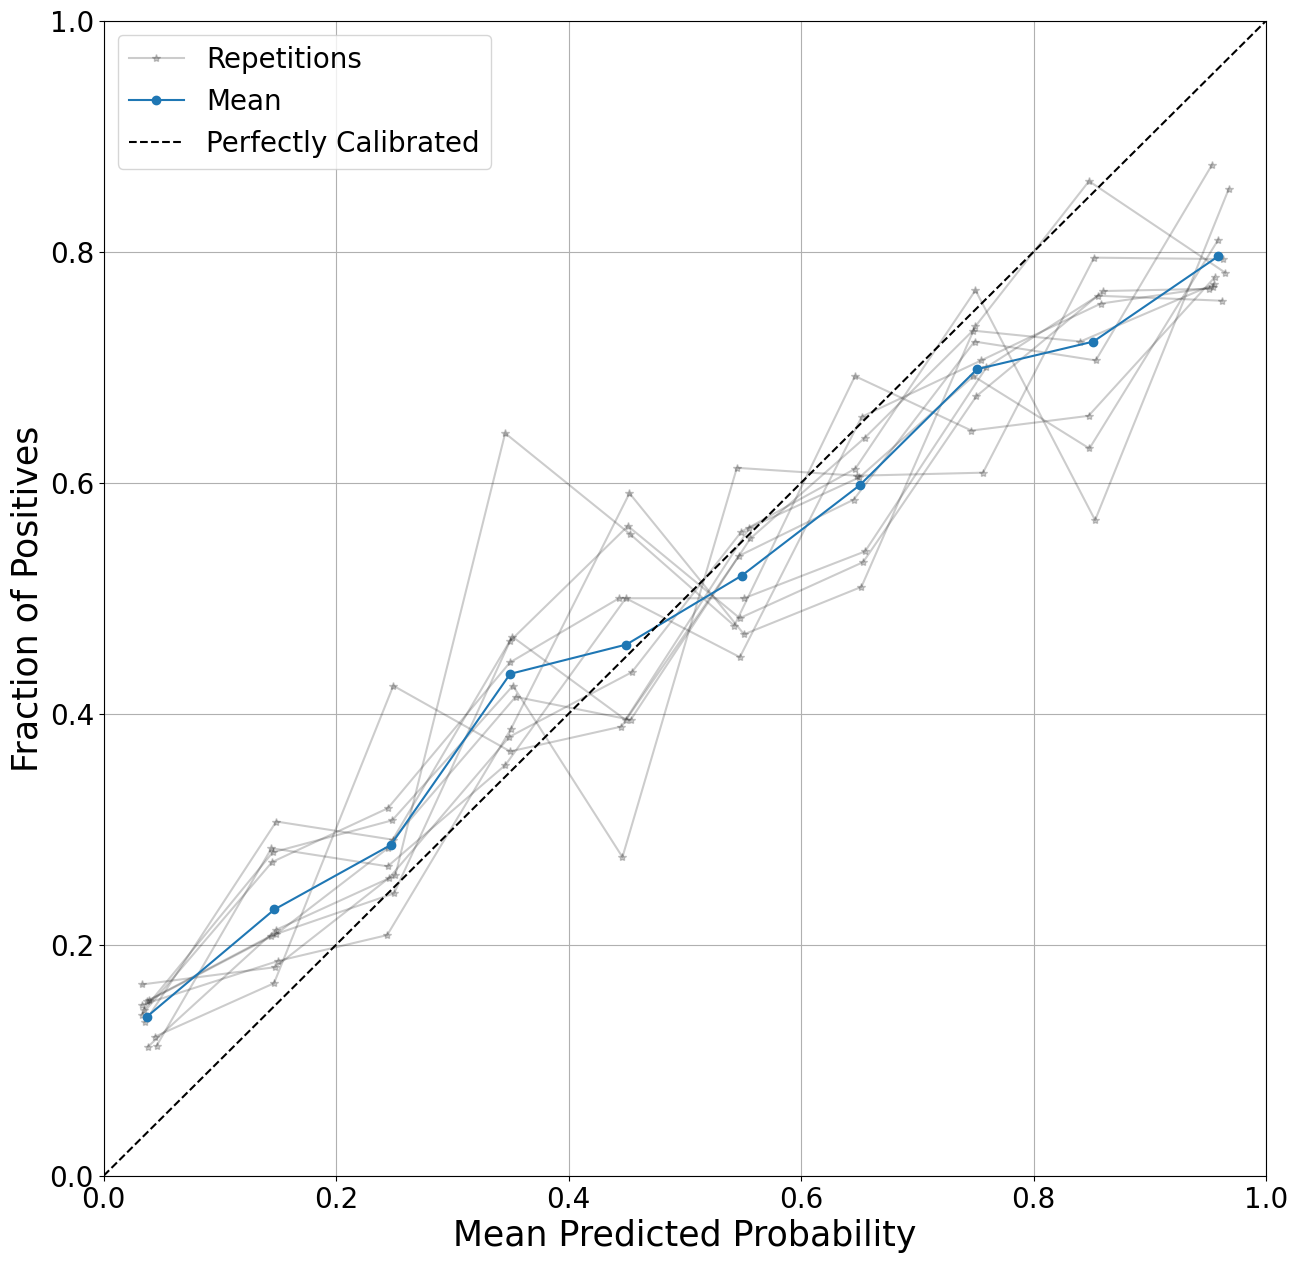

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/predictions/"

y_true = pd.read_csv(data_dir +"y_true_24hs_v2_for_AUC.csv", index_col=0)
y_pred = pd.read_csv(data_dir +"24hs_v2_predictions_for_AUC.csv", index_col=0)

import pandas as pd
import numpy as np

# Create a new DataFrame with the first 10 columns for each group
reshape_true = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_true.iloc[:,column]])

    reshape_true = pd.concat([reshape_true, new_col], axis=1)

reshape_true = reshape_true.dropna()
# Display the new DataFrame

# Create a new DataFrame with the first 10 columns for each group
reshape_pred = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_pred.iloc[:,column]])

    reshape_pred = pd.concat([reshape_pred, new_col], axis=1)

reshape_pred = reshape_pred.dropna()


plt.figure(figsize=(15, 15))
for fold in range(reshape_pred.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        reshape_true.iloc[:, fold], reshape_pred.iloc[:, fold], n_bins=10, strategy='uniform'
    )
    if fold == 0:
        plt.plot(mean_predicted_value, fraction_of_positives, label='Repetitions', marker='*', alpha=0.2, color="black")

        fraction_of_positives_mean = fraction_of_positives
        mean_predicted_value_mean = mean_predicted_value
    else:
        plt.plot(mean_predicted_value, fraction_of_positives,  marker='*', alpha=0.2, color="black")

        fraction_of_positives_mean += fraction_of_positives
        mean_predicted_value_mean += mean_predicted_value

fraction_of_positives_mean = fraction_of_positives_mean/10
mean_predicted_value_mean = mean_predicted_value_mean/10

plt.plot(mean_predicted_value_mean, fraction_of_positives_mean, label='Mean', marker='o')

lim = [0,1]
# Plot the diagonal line for perfect calibration
plt.plot(lim, lim, linestyle='--', color='black', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.xlim(lim)
plt.ylim(lim)
plt.grid()
plt.show()

The label '_none' of <matplotlib.collections.PolyCollection object at 0x7fc059491610> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7fc05932aca0> starts with '_'. It is thus excluded from the legend.


[]

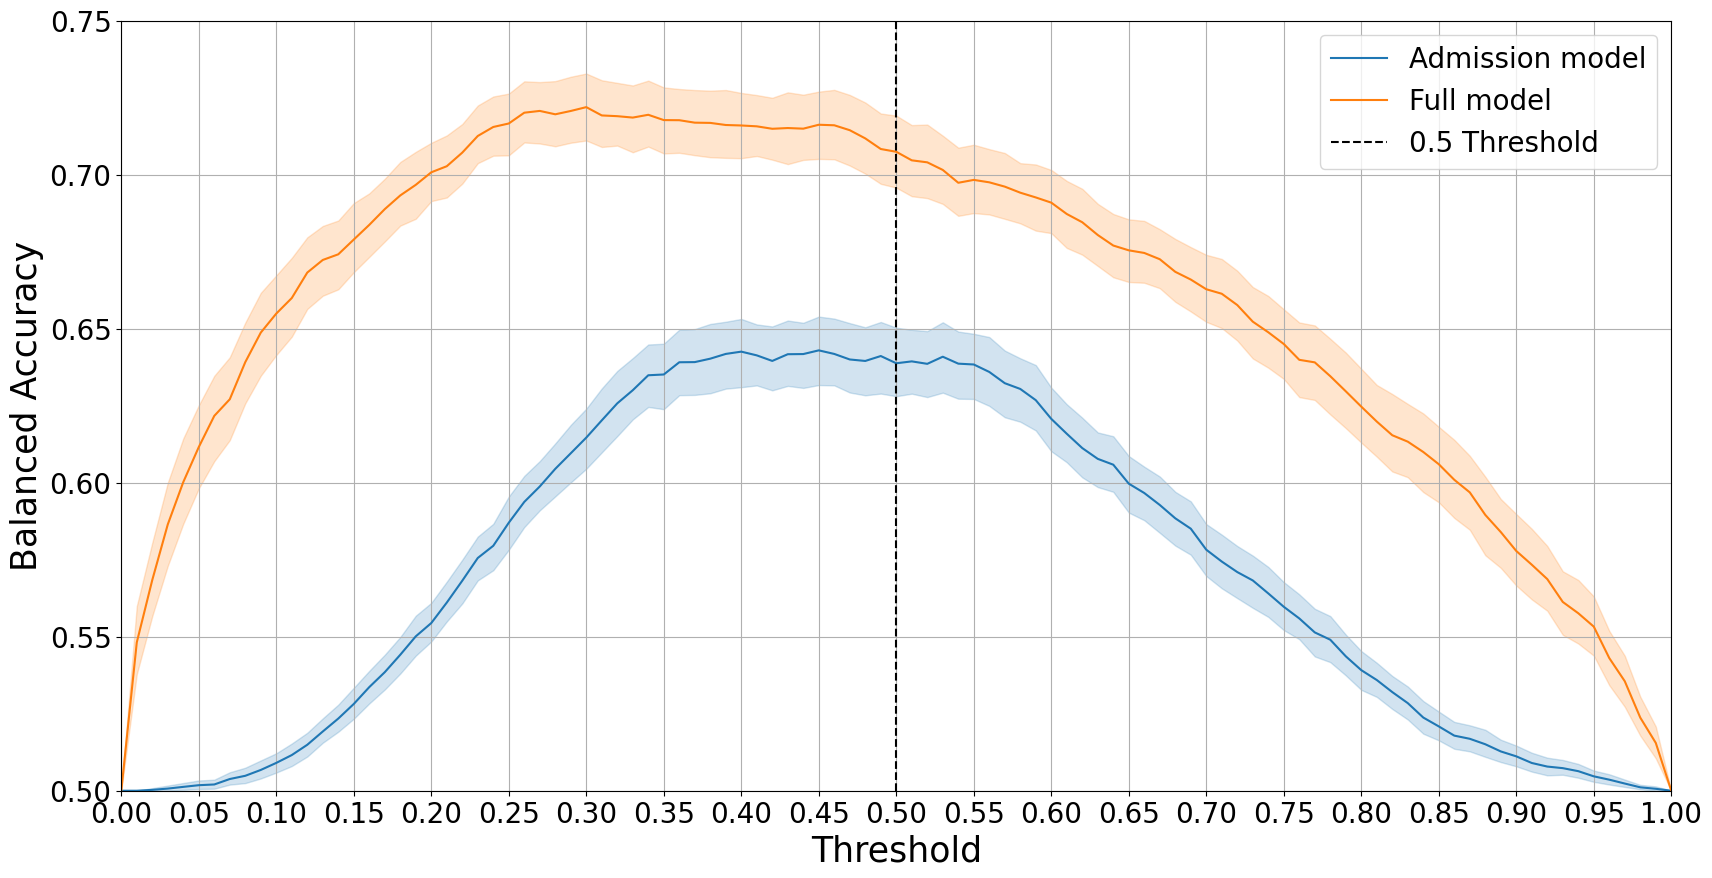

In [33]:
import seaborn as sns
import numpy as np
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_ths_admission_df = pd.read_csv(data_dir + "threshold_10x10_Admission_v2.csv")

results_ths_24hs_df = pd.read_csv(data_dir + "threshold_10x10_24hs_v2.csv")
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"

model_to_plot = "Admission"
results_ths_df_to_plot = results_ths_admission_df[results_ths_admission_df["Model"] == model_to_plot]   # noqa
sns.lineplot(data=results_ths_df_to_plot, y=metric_to_plot, x="Threshold")
plt.ylabel("Performance")

model_to_plot = "24hs"
results_ths_df_to_plot = results_ths_24hs_df[results_ths_24hs_df["Model"] == model_to_plot]   # noqa
sns.lineplot(data=results_ths_df_to_plot, y=metric_to_plot, x="Threshold")
ths = 0.5

sns.lineplot(x=[ths-.00000001, ths+.00000001], y=[0.50, .8], ax=ax, color="black", linestyle="--", legend=True)
plt.ylim([0.5,0.75])
plt.xlim([0,1])
plt.ylabel("Balanced Accuracy")
plt.title("")
plt.grid()


plt.legend(["Admission model", "_none", "Full model", "_none", "0.5 Threshold"])
custom_ticks = np.arange(0, 1.01, 0.05)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
plt.plot()

# Shap values

## Shap admission

[16:03:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


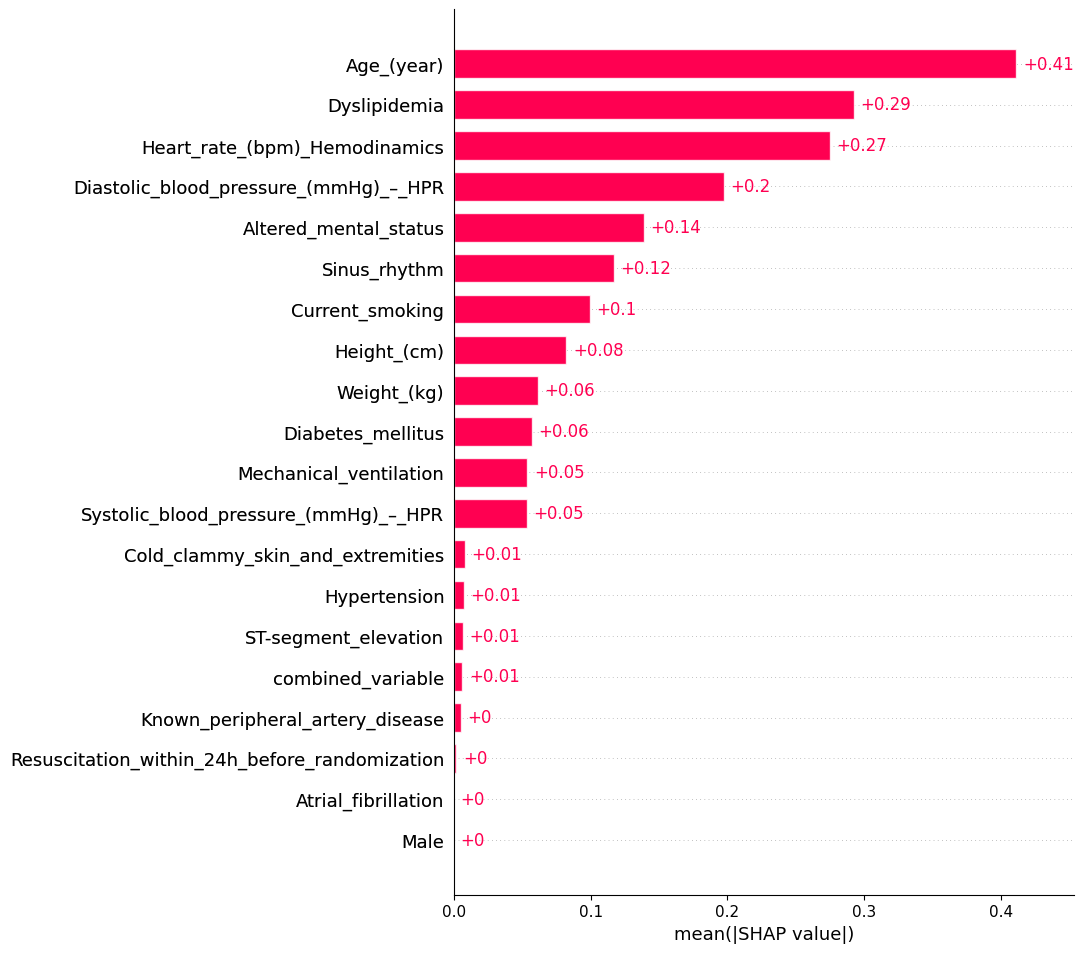

In [3]:

data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/shap_values/"
load_list = ["shap_values_Admission_v2",
             "shap_baselineAdmission_v2",
             "shap_dataAdmission_v2"]
shap_dict = dict()

for file_name in load_list:
    with open(data_dir+file_name, "rb") as fp:
        shap_dict[file_name] = pickle.load(fp)
X_admission = pd.read_csv(data_dir+"X_Admission_v2_v2.csv",index_col=0)


# X_admission.rename(columns={"Age_(year)": "Age",
#                             "Heart_rate_(bpm)_Hemodinamics": "Heart rate [BPM]",
#                             "Diastolic_blood_pressure_(mmHg)_–_HPR":"Diastolic blood pressure [mmHg]",
#                             "Height_(cm)": "Height [cm]",
#                             "Weight_(kg)": "Weight [Kg]",
#                             'Mechanical_ventilation':'Mechanical ventilation',
#                             "Resuscitation_within_24h_before_randomization": "Resuscitation within 24h before randomization",
#                             "Altered_mental_status": "Altered mental status",
#                             "Cold_clammy_skin_and_extremities": "Cold clammy skin and extremities",
#                             "combined_variable": "Combined variable",
#                             "Previous_congestive_heart_failure": "Previous congestive heart failure",
#                             "Previous_stroke": "Previous stroke",
#                             "Known_peripheral_artery_disease": "Known peripheral artery disease",
#                             "Known_renal_insufficiency_(GFR_less_30_ml/min)": "Known renal insufficiency",
#                             "Chronic_dialysis":"Chronic dialysis",
#                             "Current_smoking": "Current smoking",
#                             "Diabetes_mellitus": "Diabetes mellitus",
#                             "Sinus_rhythm": "Sinus rhythm",
#                             "Atrial_fibrillation": "Atrial fibrillation",
#                             "AV-block_III": "AV block III",
#                             'ST-segment_elevation':'ST segment elevation',
#                             'Systolic_blood_pressure_(mmHg)_–_HPR':'Systolic blood pressure [mmHg]'}, inplace=True)



model = joblib.load(data_dir+"model_Admission_v2_shap_values.pkl")

explainer = shap.Explainer(model)
shap_values = explainer(X_admission)

plt.figure(figsize=[15,10])
shap_values.values = shap_dict["shap_values_Admission_v2"]
shap_values.baseline = shap_dict["shap_baselineAdmission_v2"]
shap_values.data = shap_dict["shap_dataAdmission_v2"]
shap.plots.bar(shap_values, max_display=28)

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


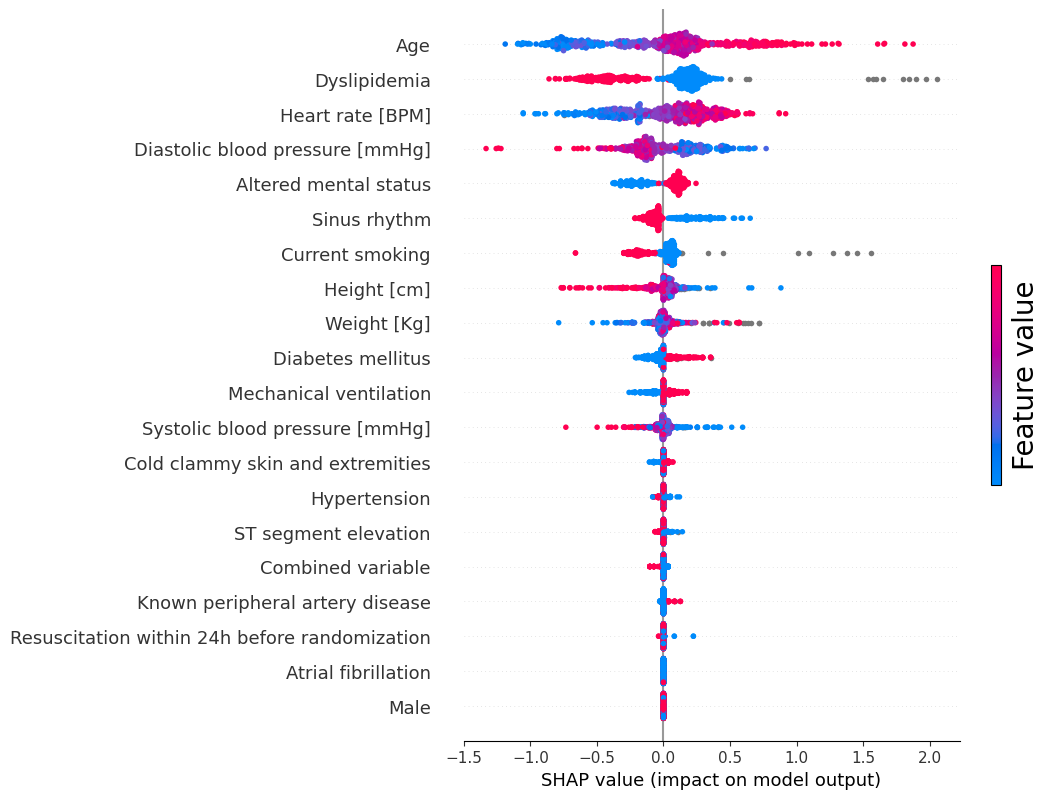

In [3]:
# beeswarm
SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
shap.plots.beeswarm(shap_values, color_bar=False, max_display=50, show=False)
plt.colorbar(location="right",label="Feature value", ticks=[], shrink=0.3)

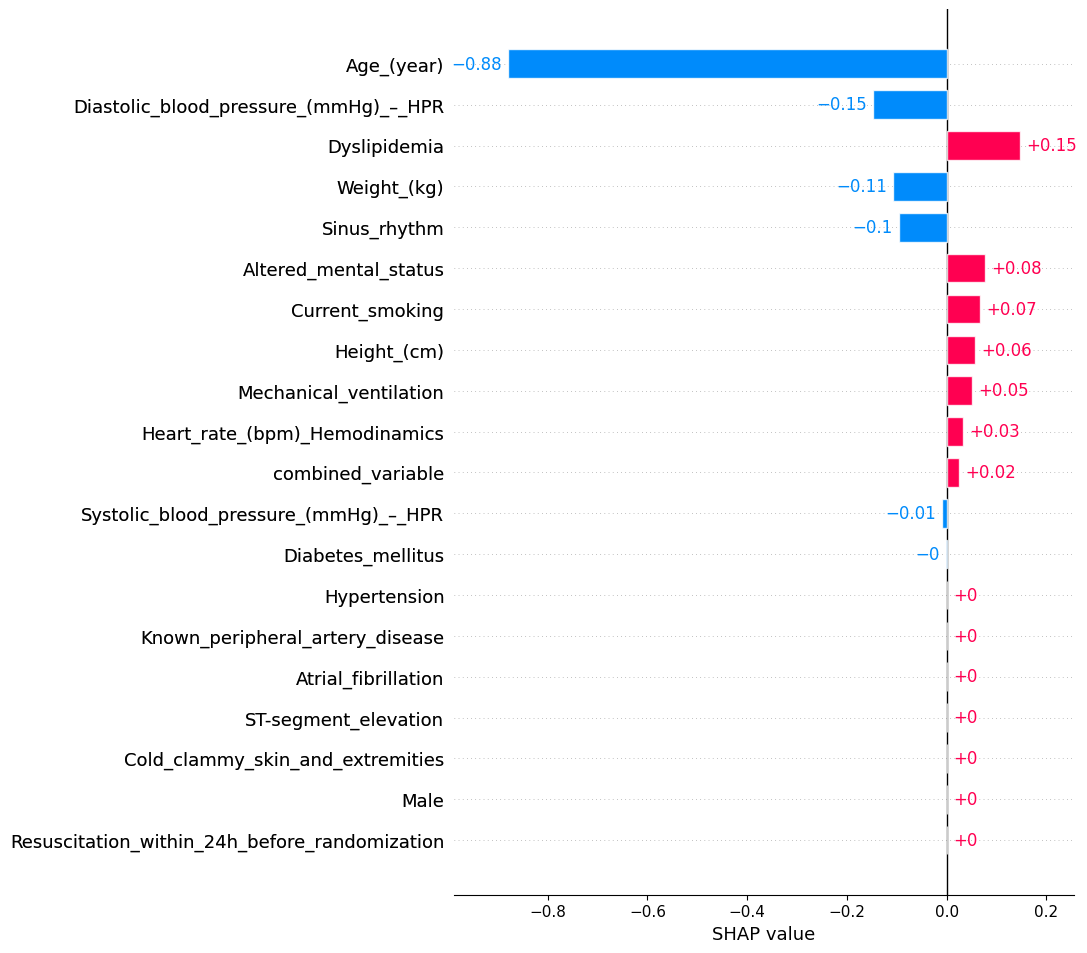

In [4]:
shap_values.base_values = 0
shap.plots.bar(shap_values[11], max_display=20)

In [11]:
shap.bar_plot(
        shap_values[1],
        show=True,
    )


TypeError: bad operand type for abs(): 'Explanation'

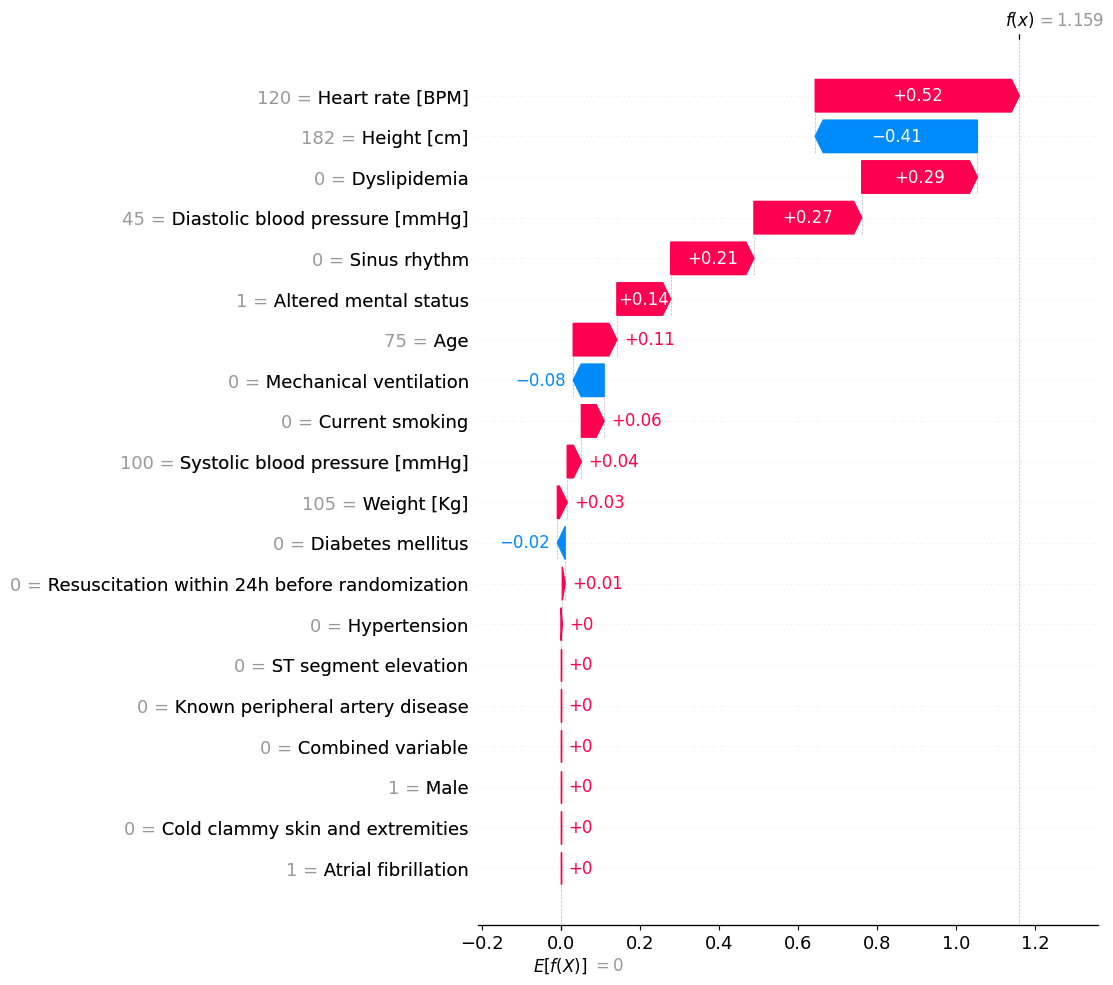

In [5]:
shap.plots.waterfall(shap_values[67], max_display=20)

## Shap for 24hs model

In [10]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/shap_values/"
load_list = ["shap_24hs_values",
             "shap_24hs_baseline",
             "shap_24hs_data"]
shap_dict = dict()

for file_name in load_list:
    with open(data_dir+file_name, "rb") as fp:
        shap_dict[file_name] = pickle.load(fp)
X_24 = pd.read_csv(data_dir+"X_24hs_v2.csv",index_col=0)


X_24.rename(columns={"Age_(year)": "Age",
                    "Heart_rate_(bpm)_Hemodinamics": "Heart rate",
                    "Diastolic_blood_pressure_(mmHg)_–_HPR":"Diastolic blood pressure",
                    "Height_(cm)": "Height",
                    "Weight_(kg)": "Weight",
                    'Mechanical_ventilation':'Mechanical ventilation',
                    "Resuscitation_within_24h_before_randomization": "Resuscitation within 24h before randomization",
                    "Altered_mental_status": "Altered mental status",
                    "Cold_clammy_skin_and_extremities": "Cold clammy skin and extremities",
                    "combined_variable": "Combined variable",
                    "Previous_congestive_heart_failure": "Previous congestive heart failure",
                    "Previous_stroke": "Previous stroke",
                    "Known_peripheral_artery_disease": "Known peripheral artery disease",
                    "Known_renal_insufficiency_(GFR_less_30_ml/min)": "Known renal insufficiency",
                    "Chronic_dialysis":"Chronic dialysis",
                    "Current_smoking": "Current smoking",
                    "Diabetes_mellitus": "Diabetes mellitus",
                    "Sinus_rhythm": "Sinus rhythm",
                    "Atrial_fibrillation": "Atrial fibrillation",
                    "AV-block_III": "AV block III",
                    'ST-segment_elevation':'ST segment elevation',
                    'Systolic_blood_pressure_(mmHg)_–_HPR':'Systolic blood pressure',
                    "Mechanical_Support":"Mechanical Support",
                    "Mild_induced_Hypothermia":"Mild induced Hypothermia",
                    "Renal_Replacement_Therapy":"Renal Replacement Therapy",
                    "Pre_PCI_Serum_lactate_value": "Pre PCI Lactate",
                    "Post_PCI_Serum_lactate_value": "Post PCI Lactate",
                    "Serum_lactate_value_8": "Lactate 8hs",
                    "Serum_lactate_value_16": "Lactate 16hs",
                    "Serum_lactate_value_24": "Lactate 24hs",
                    "No_reflow": "No reflow",
                    "Hematocrit_in_%": "Hematocrit",
                    "White_blood_cell_count_in_Gpt/L": "White blood cell count",
                    "HS_Troponin_I": "HS Troponin I",
                    "Procedural_success_(TIMI3_or_successful_complete_revascularization)": "Procedural success",
                    "ALAT_in_µkat/l": "ALAT [µkat/L]",
                    "GFR_CKD-EPI_creatinine_equation_V1_in_ml/min/1.73m²": "GFR Creatinine",
                    "NT_pro_B-type_natriuretic_peptide_V1_in_pg/ml": "NT proB",
                    "creatine": "Creatine",
                    "admission_lactate": "Admission Lactate",
                    "hematocrit": "Hematocrit",
                    "glucose": "Glucose",
                    "white_cell_count": "White Cell Count",
                    "resusitation_24hs": "Resucitation within 24hs",
                    "hs-Troponine_T_V1_in_pg/ml": "Troponine",
                    "C_Reaktive_Protein_V1_in_mg/l": "CRP",
                    "ALAT [µkat/L]": "ALAT"}, inplace=True)


model = joblib.load(data_dir+"model_24hs_v2_shap_values.pkl")

explainer = shap.Explainer(model)
shap_values = explainer(X_24)

shap_values.values = shap_dict["shap_24hs_values"]
shap_values.baseline = shap_dict["shap_24hs_baseline"]
shap_values.data = shap_dict["shap_24hs_data"]
shap.plots.bar(shap_values, max_display=50)


[14:54:19] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


TypeError: predict() got an unexpected keyword argument 'ntree_limit'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


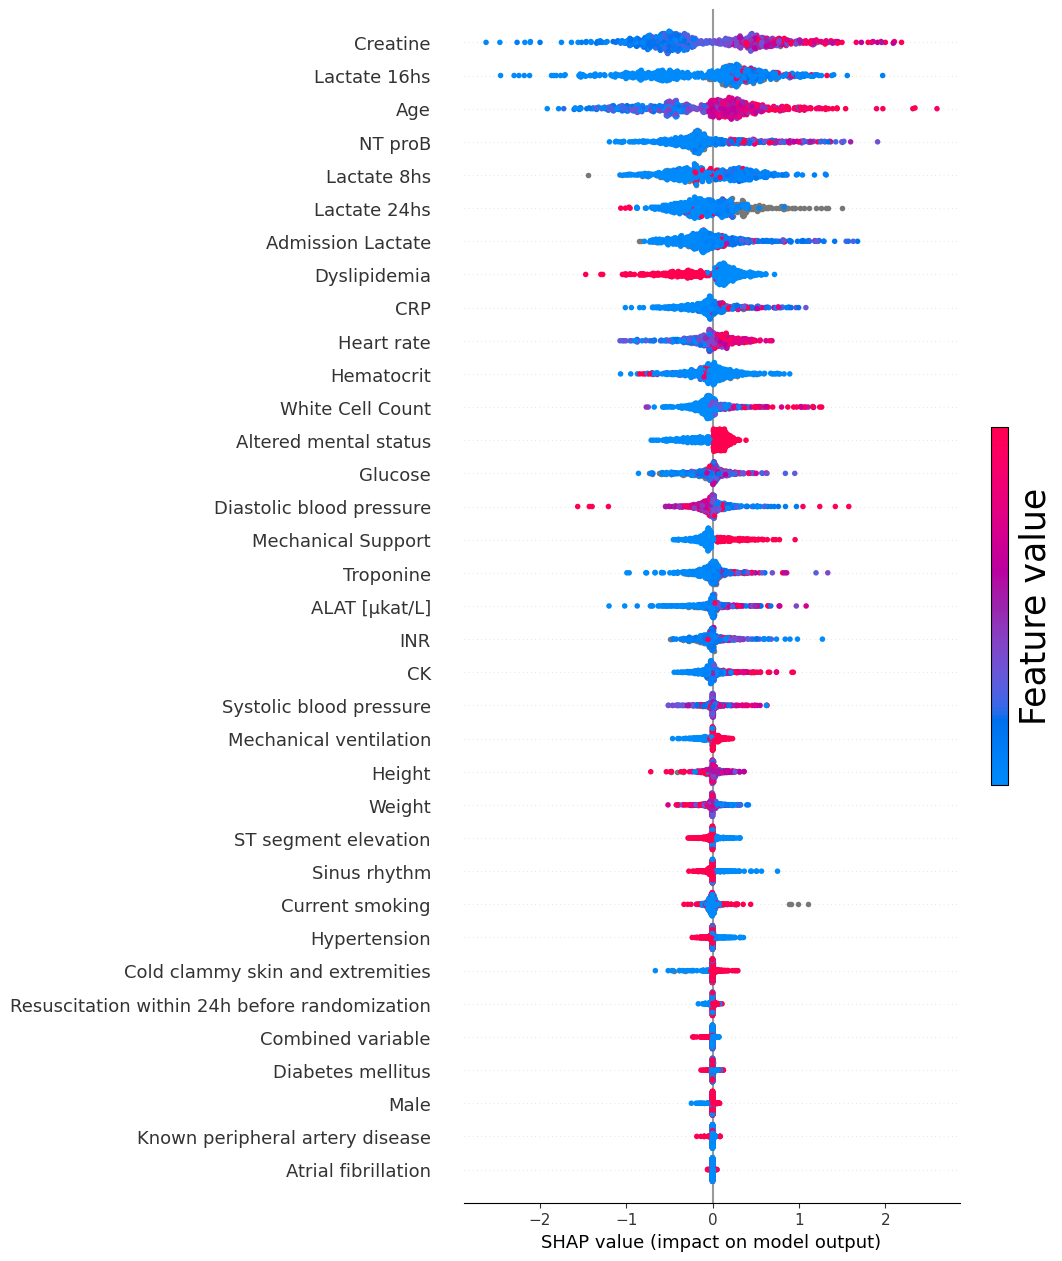

In [4]:
shap.plots.beeswarm(shap_values, color_bar=False, max_display=50,show=False)
plt.colorbar(location="right",label="Feature value", ticks=[], shrink=0.3)

# Missing values

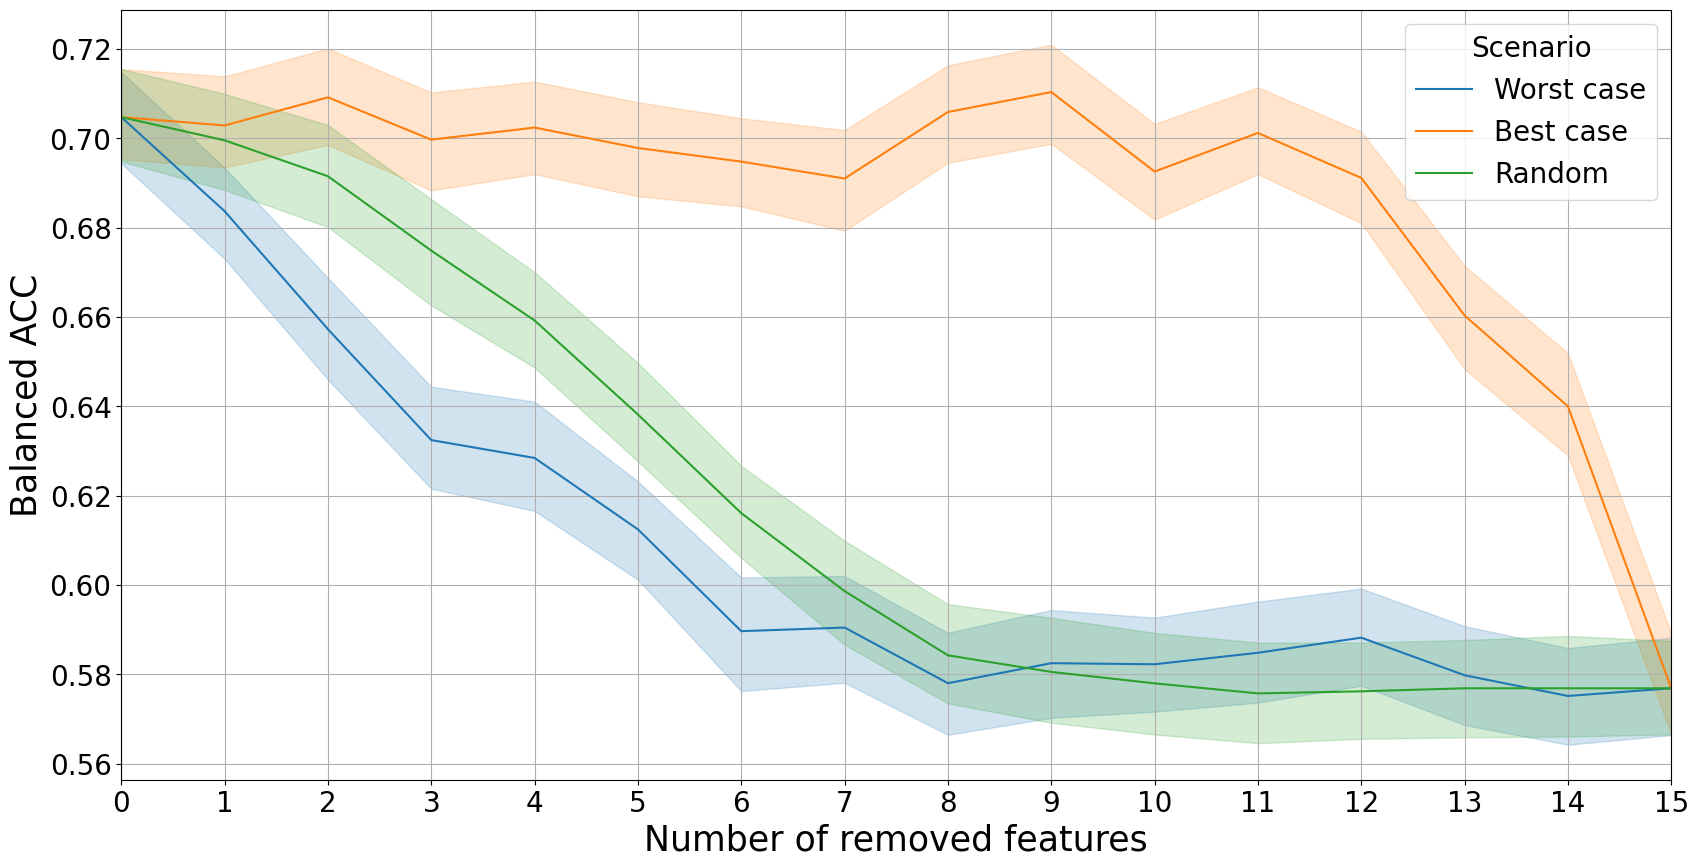

In [8]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_random = pd.read_csv(data_dir + "Full_big_experiment_random_remove.csv", index_col=0)
results_random = results_random[results_random["Threshold"] == 0.5]
results_random["Scenario"] = "Random"

results_direct = pd.read_csv(data_dir + "Full_big_experiment_direct_remove.csv", index_col=0)
results_direct = results_direct[results_direct["Threshold"] == 0.5]
results_direct["Scenario"] = "Worst case"

results_inverse = pd.read_csv(data_dir + "Full_big_experiment_inverse_remove.csv", index_col=0)

results_inverse = results_inverse[results_inverse["Threshold"] == 0.5]
results_inverse["Scenario"] = "Best case"


fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"
results_mv = pd.concat([results_direct,results_inverse,results_random])
results_mv_to_plot = results_mv[results_mv["Model"] == "Full"]

sns.lineplot(
    data=results_mv_to_plot,
    x="Number of Removed Features", y=metric_to_plot,
    hue="Scenario", ax=ax
)
plt.grid()
plt.xlim(0,15)
plt.xlabel("Number of removed features")
custom_ticks = np.arange(0, 16, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
# plt.title("Missing values impact in 24hs Model")
plt.show()

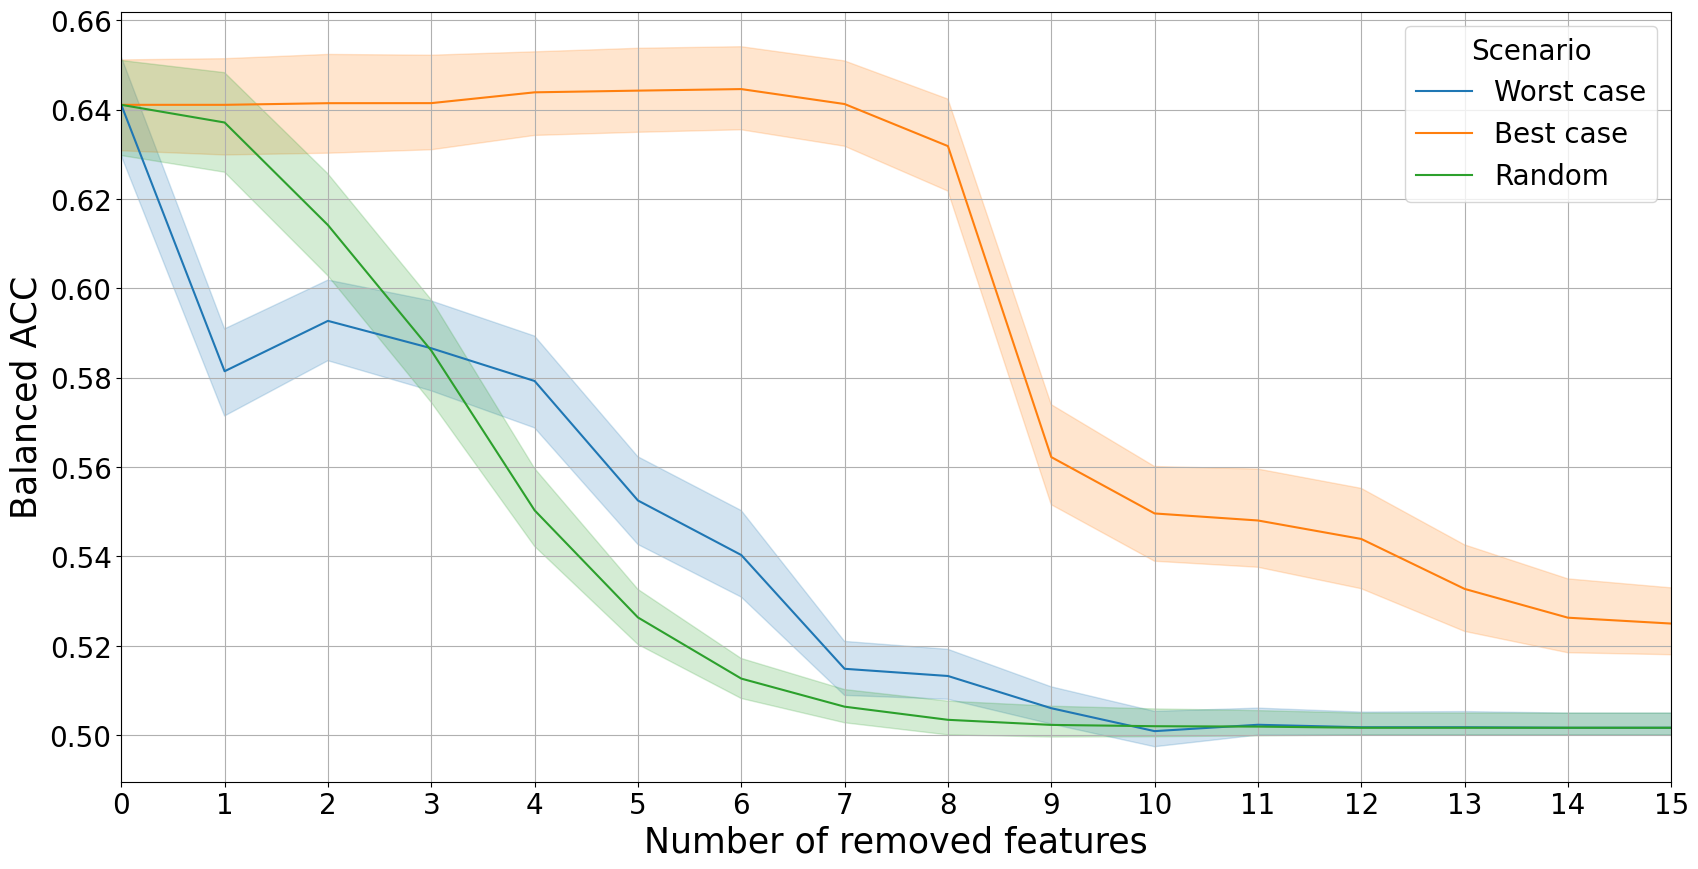

In [15]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_random = pd.read_csv(data_dir + "Admission_big_experiment_random_remove.csv", index_col=0)
results_random = results_random[results_random["Thresholds"] == 0.5]
results_random["Scenario"] = "Random"

results_direct = pd.read_csv(data_dir + "Admission_big_experiment_direct_remove.csv", index_col=0)
results_direct = results_direct[results_direct["Thresholds"] == 0.5]
results_direct["Scenario"] = "Worst case"

results_inverse = pd.read_csv(data_dir + "Admission_big_experiment_inverse_remove.csv", index_col=0)

results_inverse = results_inverse[results_inverse["Thresholds"] == 0.5]
results_inverse["Scenario"] = "Best case"


fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"
results_mv = pd.concat([results_direct,results_inverse,results_random])
results_mv_to_plot = results_mv[results_mv["Model"] == "Admission"]

sns.lineplot(
    data=results_mv_to_plot,
    x="Number of Removed Features", y=metric_to_plot,
    hue="Scenario", ax=ax
)
plt.grid()
plt.xlim(0,15)
plt.xlabel("Number of removed features")
custom_ticks = np.arange(0, 16, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
# plt.title("Missing values impact in 24hs Model")
plt.show()

# Sensitivity trade off

The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f71d82b1b80> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f71d82a58e0> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f71d82b5b80> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f71d8267a00> starts with '_'. It is thus excluded from the legend.


Text(0.5, 1.0, '24hs and CLIP score Sensitivity-Specificity analysis')

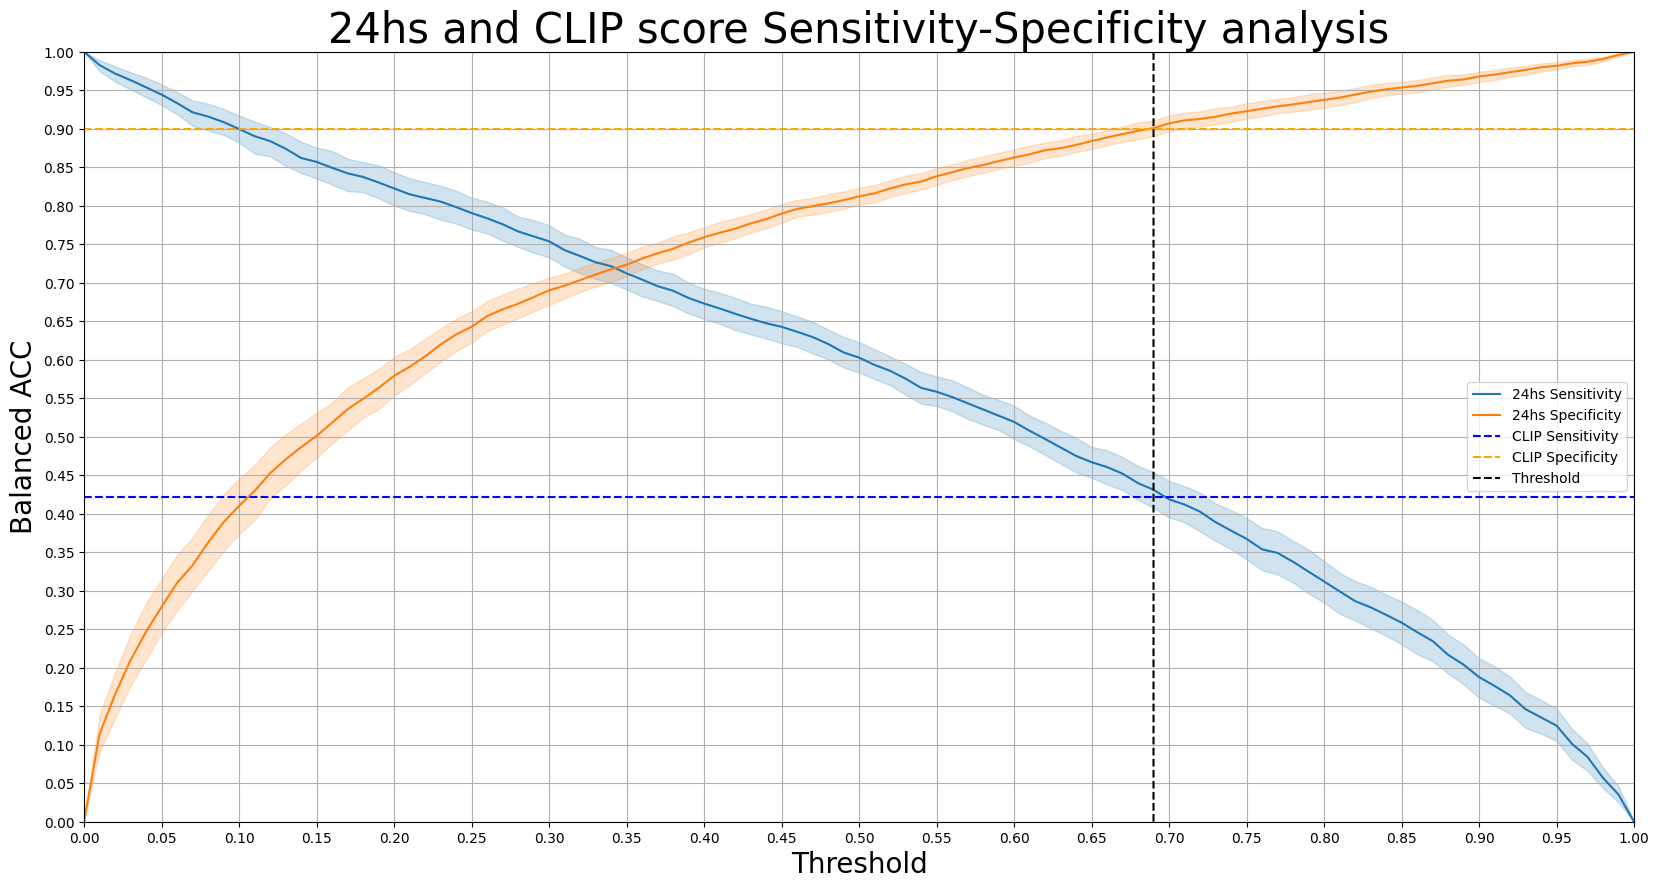

In [12]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_ths_df = pd.read_csv(data_dir + "threshold_10x10_24hs_v2.csv")

results_scores = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_scores_v2.csv")
results_true_label = results_scores[results_scores["Random State"]==False]
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
model_to_plot = "24hs"
results_ths_df_to_plot = results_ths_df[results_ths_df["Model"] == model_to_plot]   
sns.lineplot(data=results_ths_df_to_plot, y="Sensitivity", x="Threshold", legend=True, ax=ax)
sns.lineplot(data=results_ths_df_to_plot, y="Specificity", x="Threshold", legend=True, ax=ax)


model_to_compare = "CLIP_SCORE"
model_sensitivity = results_true_label[results_true_label["Model"] == model_to_compare]["Sensitivity"].mean()
model_specificity = results_true_label[results_true_label["Model"] == model_to_compare]["Specificity"].mean()
sns.lineplot(
    x=[0, 1], y=[model_sensitivity,                                                         
                 model_sensitivity], ax=ax, color="blue", linestyle="--", legend=True)
sns.lineplot(

    x=[0, 1], y=[model_specificity,                                                          
                 model_specificity], ax=ax, color="orange", linestyle="--", legend=True)

plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel(metric_to_plot)
model_specificity = 0.69
sns.lineplot(
    x=[model_specificity-0.00001,  model_specificity], y=[0, 1], ax=ax, color="black", linestyle="--", legend=True)

plt.legend(["24hs Sensitivity","_none", "24hs Specificity", "_none",
            "CLIP Sensitivity","_none", "CLIP Specificity", "_none", "Threshold"])
custom_ticks = np.arange(0, 1.01, 0.05)  # Range from 0 to 1 with step of 0.1
plt.yticks(custom_ticks)
plt.xticks(custom_ticks)
plt.title("24hs and CLIP score Sensitivity-Specificity analysis")

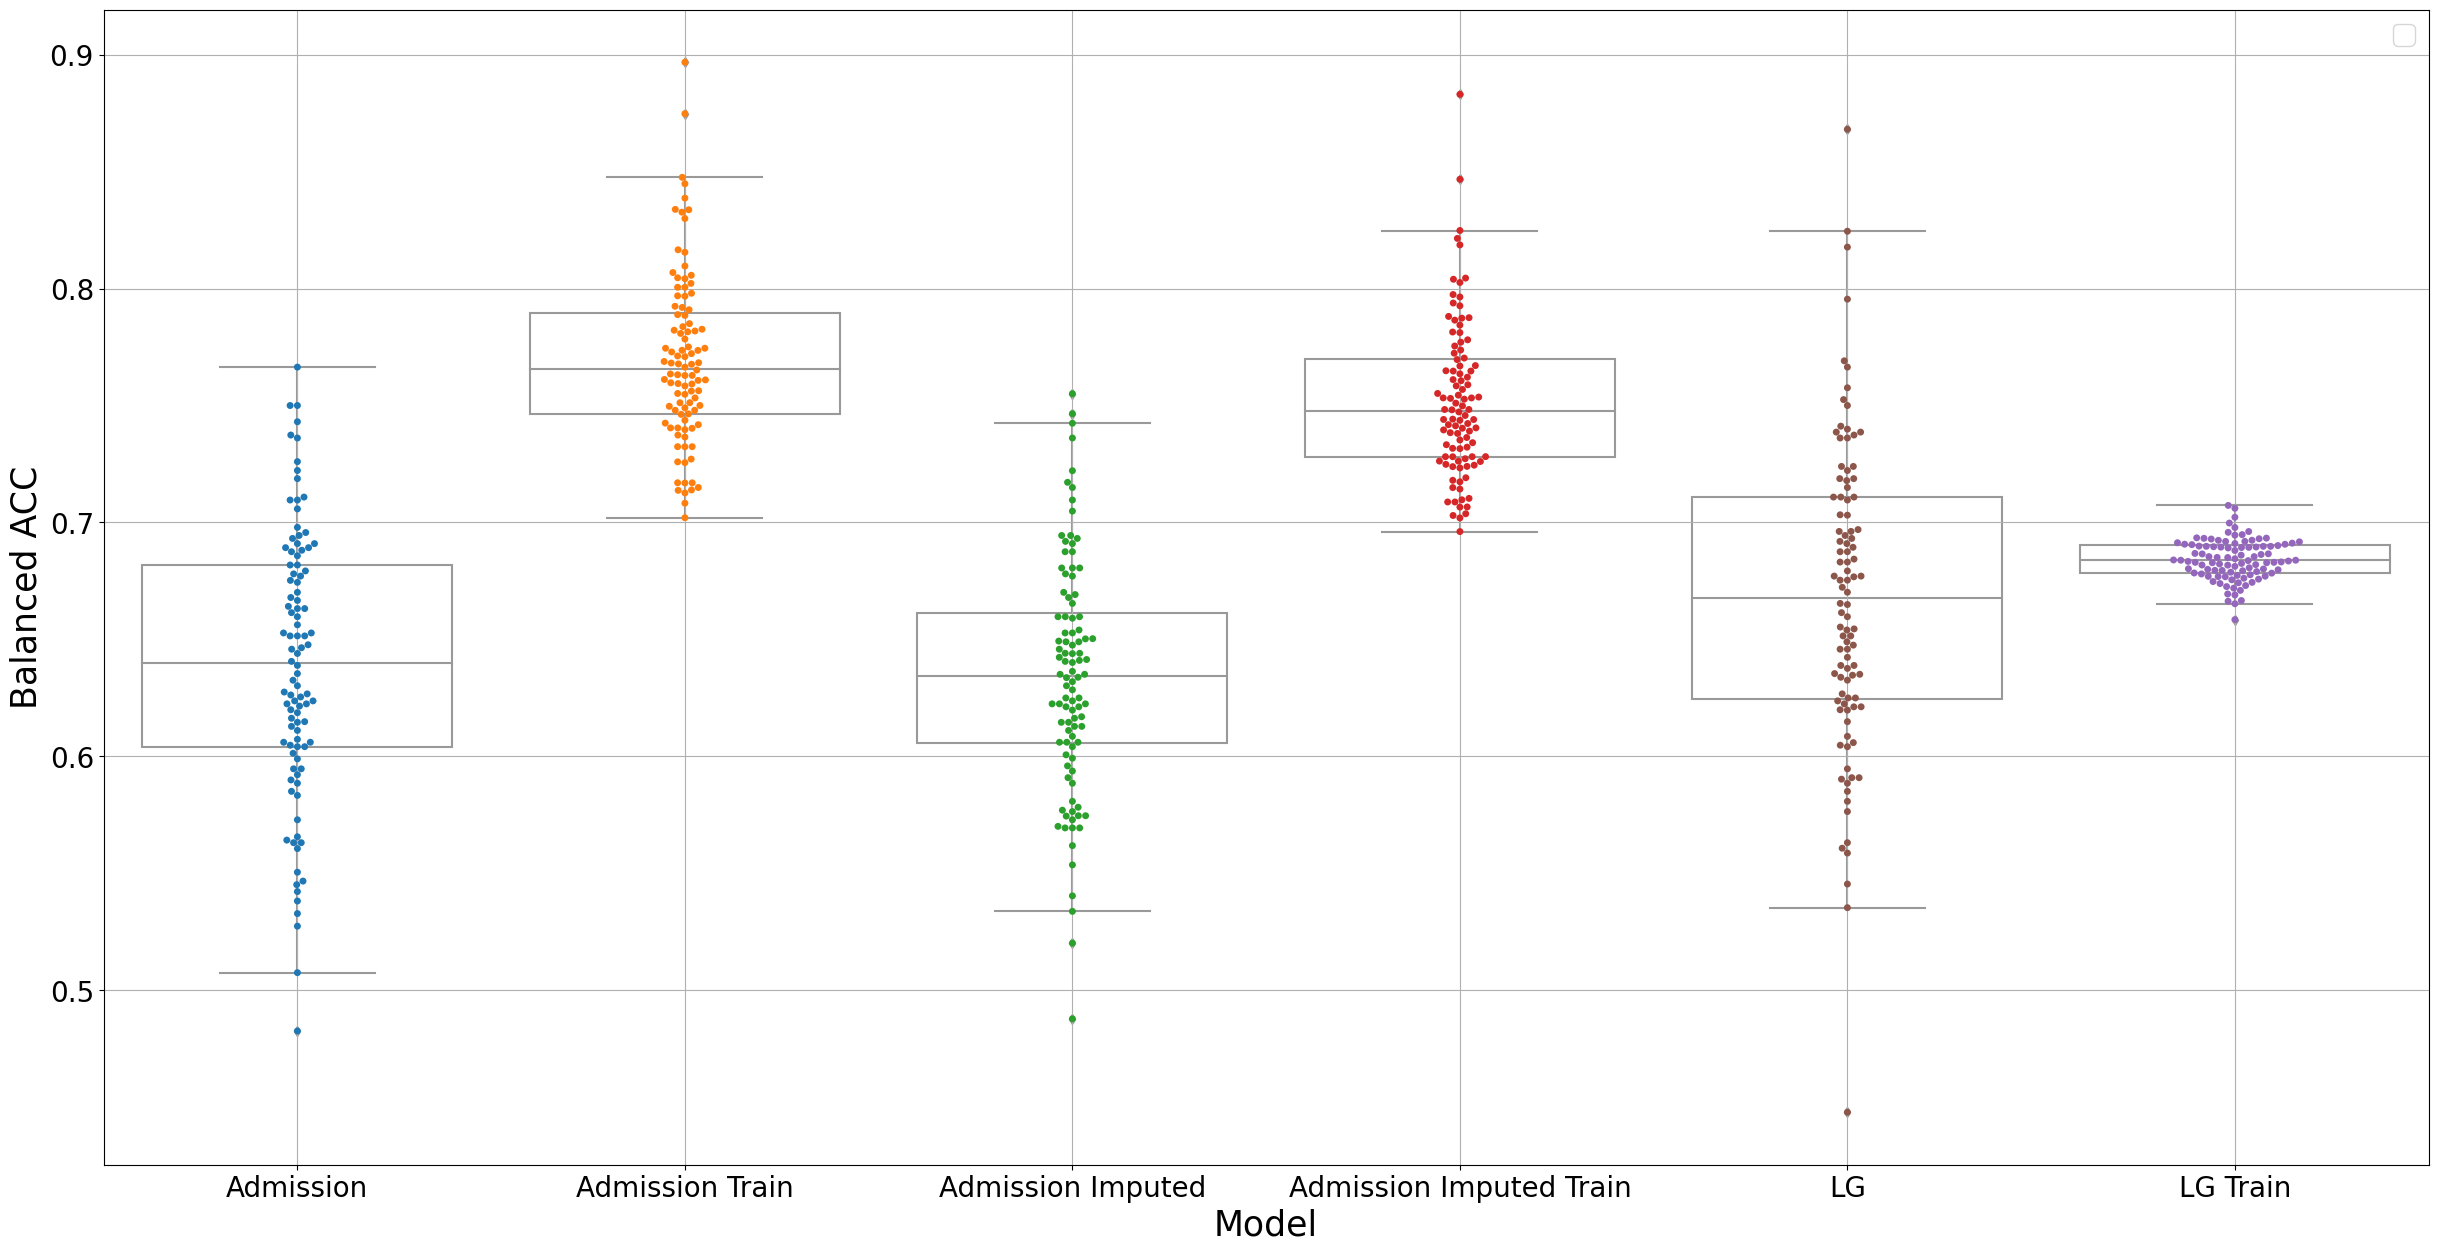

In [3]:


results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"
results_admission_optuna = pd.read_csv(results_dir + "Admission_big_experiment_direct_remove.csv", index_col=0)

results_admission_optuna = results_admission_optuna[results_admission_optuna["Thresholds"] == 0.5]
results_admission_optuna = results_admission_optuna[results_admission_optuna["Number of Removed Features"] == 0]

results_admission_optuna["Random State"] =  False

results_admission_train = pd.read_csv(results_dir + "Admission_big_experiment_training.csv", index_col=0)
results_admission_train = results_admission_train[results_admission_train["Thresholds"] == 0.5]
results_admission_train = results_admission_train[results_admission_train["Number of Removed Features"] == 0]
results_admission_train["Random State"] =  False

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/imputed_data/"

results_admission_imp = pd.read_csv(results_dir + "Admission_imp_big_experiment_direct_remove2.csv", index_col=0)

results_admission_imp = results_admission_imp[results_admission_imp["Thresholds"] == 0.5]
results_admission_imp = results_admission_imp[results_admission_imp["Number of Removed Features"] == 0]

results_admission_imp["Random State"] =  False

results_admission_train_imp = pd.read_csv(results_dir + "Admission_imp_big_experiment_training2.csv", index_col=0)
results_admission_train_imp = results_admission_train_imp[results_admission_train_imp["Thresholds"] == 0.5]
results_admission_train_imp = results_admission_train_imp[results_admission_train_imp["Number of Removed Features"] == 0]
results_admission_train_imp["Random State"] =  False

LG_imp = pd.read_csv(results_dir + "LG_imp_data_admission.csv", index_col=0)
LG_imp_el = pd.read_csv(results_dir + "LG_imp_elastic_data_admission.csv", index_col=0)




results = pd.concat([results_admission_optuna,results_admission_train , results_admission_imp, results_admission_train_imp,LG_imp_el])
results["Model"].replace({"Admission_imp": "Admission Imputed",
                          "Admission Train _Imp": "Admission Imputed Train",
                          "LG_imputed_admission_test": "LG",
                          "LG_imputed_admission_train": "LG Train"}, inplace=True)
# 
results_true_label = results[results["Random State"]== False]

# results_true_label.replace({"Admission_Train": "Admission Train", "24hs_Train": "Full Train"}, inplace= True)

metric_to_plot = "Balanced ACC"

models_to_plot = ['Admission', 'Admission Train', 'Admission Imputed',
                    'Admission Imputed Train', 'LG', 'LG Train' ]

fig, ax = plt.subplots(1, 1, figsize=[30, 15])

sns.swarmplot(
    data=results_true_label,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
    # palette=[[1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           [1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           ]
)

sns.boxplot(
    data=results_true_label, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot,
    dodge=True, ax=ax
)
plt.legend([])
plt.grid()

36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
39.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
39.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
39.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


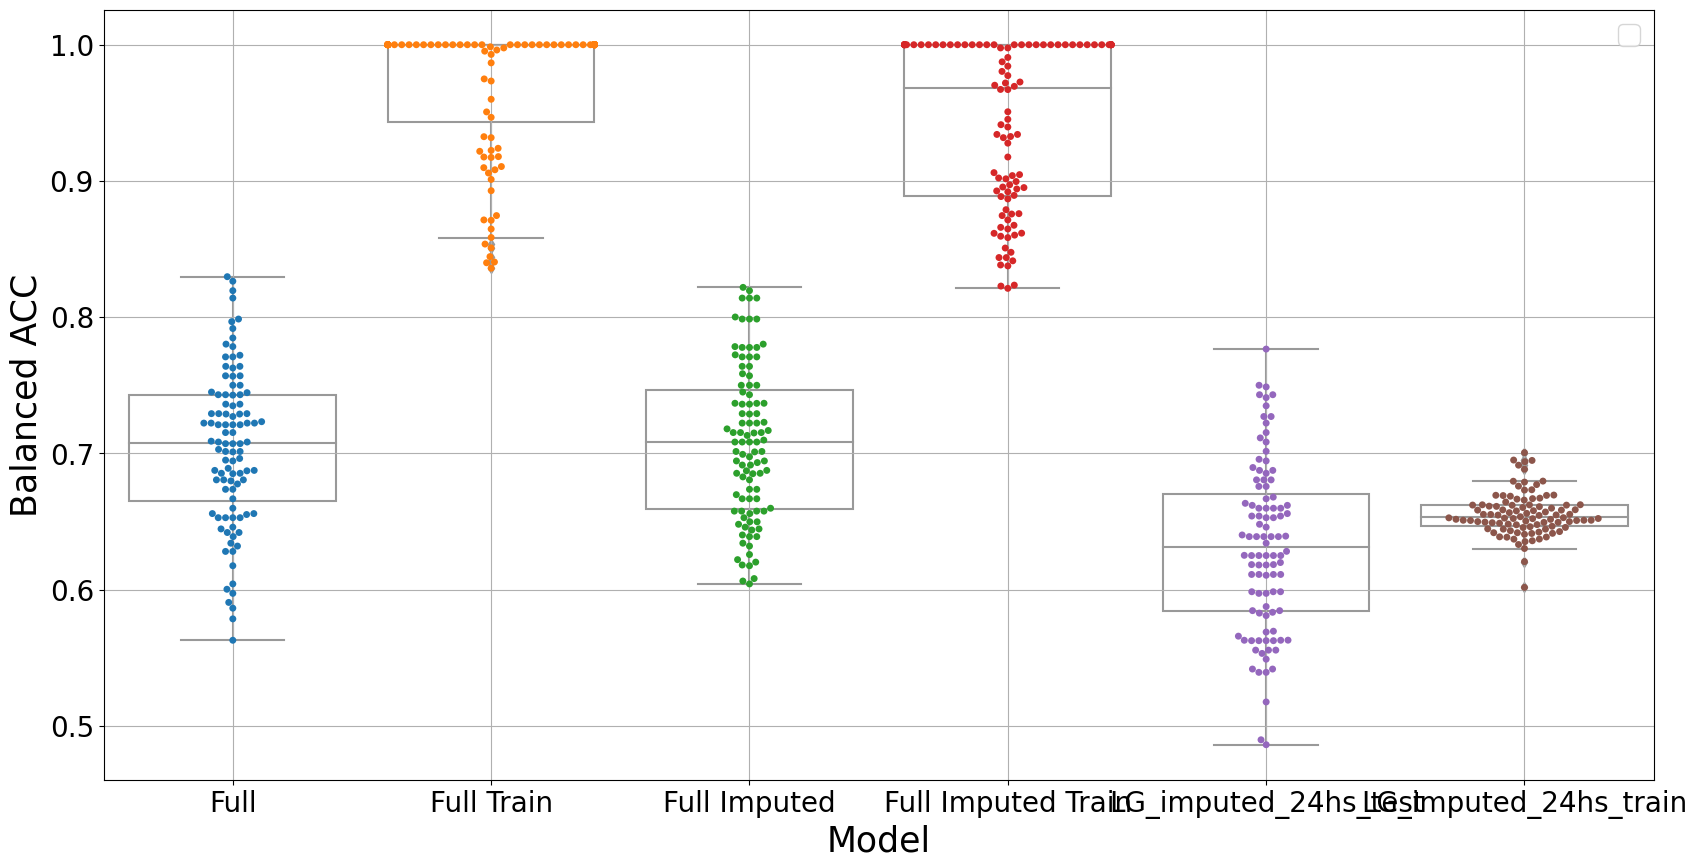

In [3]:


results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"
results_admission_optuna = pd.read_csv(results_dir + "Full_big_experiment_direct_remove_v3.csv", index_col=0)

results_admission_optuna = results_admission_optuna[results_admission_optuna["Thresholds"] == 0.5]
results_admission_optuna = results_admission_optuna[results_admission_optuna["Number of Removed Features"] == 0]

results_admission_optuna["Random State"] =  False

results_admission_train = pd.read_csv(results_dir + "Full_big_experiment_training_v3.csv", index_col=0)
results_admission_train = results_admission_train[results_admission_train["Thresholds"] == 0.5]
results_admission_train = results_admission_train[results_admission_train["Number of Removed Features"] == 0]
results_admission_train["Random State"] =  False

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/imputed_data/"

results_admission_imp = pd.read_csv(results_dir + "Full_imp_big_experiment_direct_remove.csv", index_col=0)

results_admission_imp = results_admission_imp[results_admission_imp["Thresholds"] == 0.5]
results_admission_imp = results_admission_imp[results_admission_imp["Number of Removed Features"] == 0]

results_admission_imp["Random State"] =  False

results_admission_imp["Model"].replace({"Full": "Full Imputed",
                          "Full Train": "Full Imputed Train"}, inplace=True)
# 

results_admission_train_imp = pd.read_csv(results_dir + "Full_imp_big_experiment_training.csv", index_col=0)
results_admission_train_imp = results_admission_train_imp[results_admission_train_imp["Thresholds"] == 0.5]
results_admission_train_imp = results_admission_train_imp[results_admission_train_imp["Number of Removed Features"] == 0]
results_admission_train_imp["Random State"] =  False
results_admission_train_imp["Model"].replace({"Full": "Full Imputed",
                          "Full Train": "Full Imputed Train"}, inplace=True)
LG_imp = pd.read_csv(results_dir + "LG_imp_data_24_hs.csv", index_col=0)




results = pd.concat([results_admission_optuna, results_admission_train, results_admission_imp, results_admission_train_imp,LG_imp])
results["Model"].replace({"Admission_imp": "Admission Imputed",
                          "Admission Train _Imp": "Admission Imputed Train",
                          "LG_imputed_admission_test": "LG",
                          "LG_imputed_admission_train": "LG Train"}, inplace=True)
# 
results_true_label = results[results["Random State"]== False]

# results_true_label.replace({"Admission_Train": "Admission Train", "24hs_Train": "Full Train"}, inplace= True)

metric_to_plot = "Balanced ACC"

# models_to_plot = ['Admission', 'Admission Train', 'Admission Imputed',
#                     'Admission Imputed Train', 'LG', 'LG Train' ]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])

sns.swarmplot(
    data=results_true_label,
    x="Model", y=metric_to_plot,
    # order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
    # palette=[[1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           [1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           ]
)

sns.boxplot(
    data=results_true_label, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    # order=models_to_plot,
    dodge=True, ax=ax
)
plt.legend([])
plt.grid()

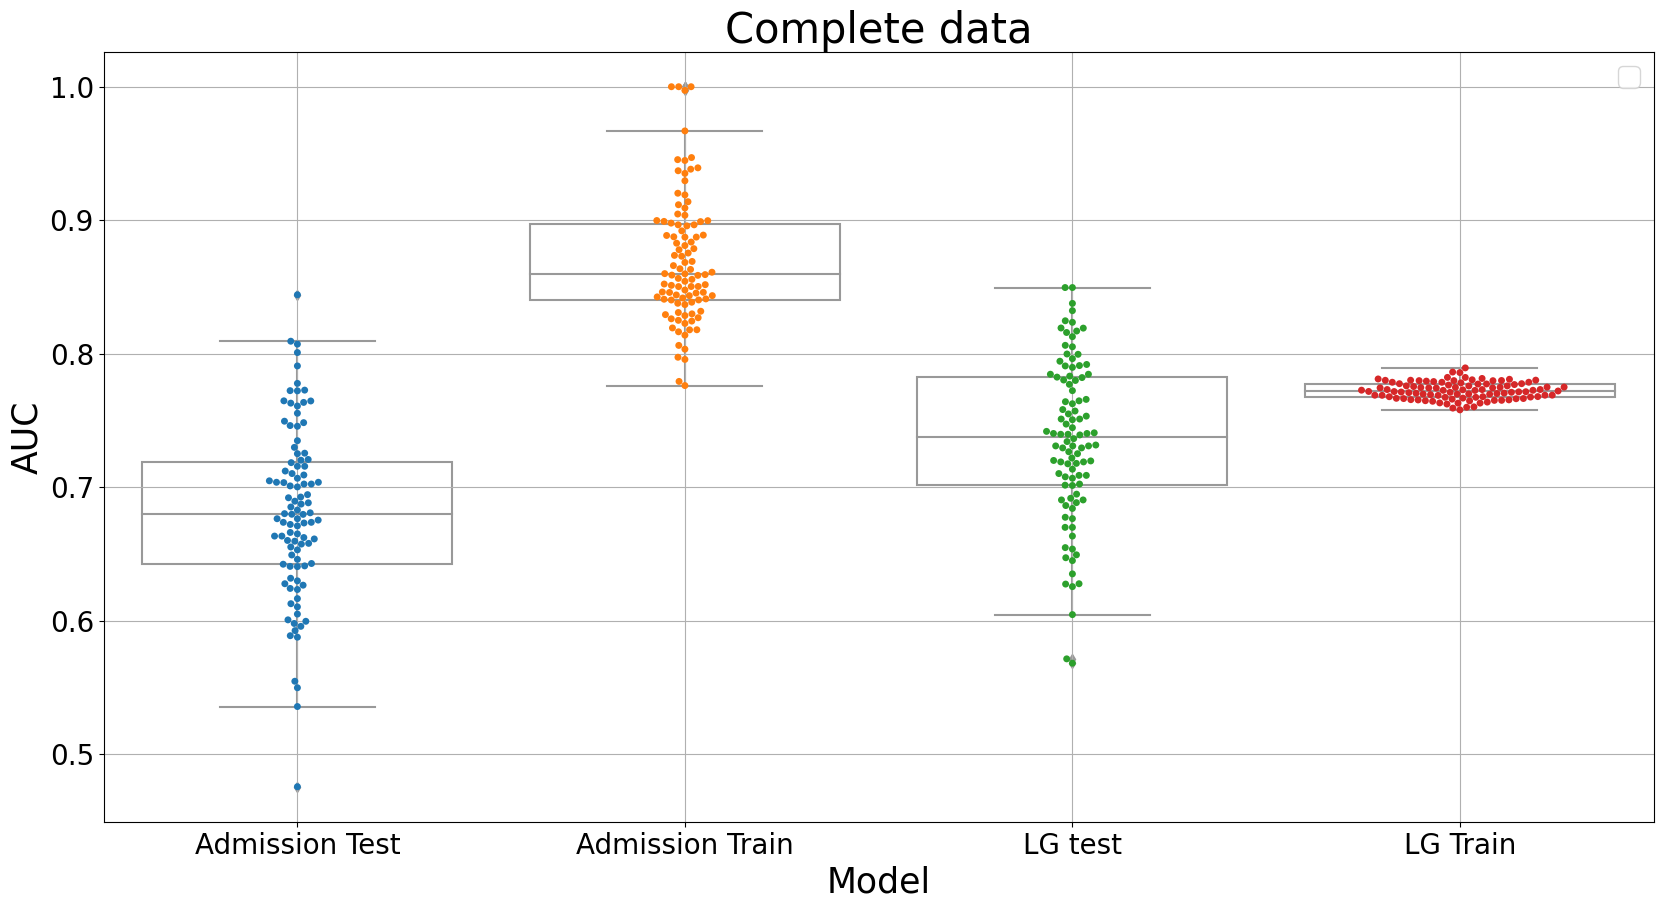

In [42]:

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/imputed_data/"

results_admission_imp = pd.read_csv(results_dir + "Admission_compleat.csv", index_col=0)

results_admission_imp = results_admission_imp[results_admission_imp["Thresholds"] == 0.5]
results_admission_imp = results_admission_imp[results_admission_imp["Number of Removed Features"] == 0]

results_admission_imp["Random State"] =  False
# 

results_admission_train_imp = pd.read_csv(results_dir + "Admission_compleat_training.csv", index_col=0)
results_admission_train_imp = results_admission_train_imp[results_admission_train_imp["Thresholds"] == 0.5]
results_admission_train_imp = results_admission_train_imp[results_admission_train_imp["Number of Removed Features"] == 0]
results_admission_train_imp["Random State"] =  False
results_admission_train_imp["Model"].replace({"Full": "Full Imputed",
                          "Full Train": "Full Imputed Train"}, inplace=True)


LG_imp = pd.read_csv(results_dir + "LG_Admission_compleat.csv", index_col=0)




results = pd.concat([results_admission_imp, results_admission_train_imp,LG_imp])
results["Model"].replace({"Admission_imp": "Admission Test",
                          "Admission Train _Imp": "Admission Train",
                          "LG_imputed_admission_test": "LG test",
                          "LG_imputed_admission_train": "LG Train"}, inplace=True)
# 
results_true_label = results[results["Random State"]== False]

# results_true_label.replace({"Admission_Train": "Admission Train", "24hs_Train": "Full Train"}, inplace= True)

metric_to_plot = "AUC"

# models_to_plot = ['Admission', 'Admission Train', 'Admission Imputed',
#                     'Admission Imputed Train', 'LG', 'LG Train' ]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])

sns.swarmplot(
    data=results_true_label,
    x="Model", y=metric_to_plot,
    # order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
    # palette=[[1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           [1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           ]
)

sns.boxplot(
    data=results_true_label, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    # order=models_to_plot,
    dodge=True, ax=ax
)
plt.title("Complete data")
plt.legend([])
plt.grid()

In [13]:
LG_test = LG_imp[LG_imp["Model"]=="LG_imputed_admission_test"].mean()

results_admission_imp[results_admission_imp["Model"]=="Admission_imp"].mean()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Fold                          49.500000
Random State                   0.000000
Random Permutation Number      0.000000
Thresholds                     0.500000
Number of Removed Features     0.000000
Balanced ACC                   0.671558
AUC                            0.734951
F1                             0.628277
Specificity                    0.734109
Sensitivity                    0.609008
Recall                         0.609008
dtype: float64

In [41]:
results_admission_imp[results_admission_imp["Model"]=="Admission_imp"].mean()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Fold                          49.500000
Random State                   0.000000
Random Permutation Number      0.000000
Thresholds                     0.500000
Number of Removed Features     0.000000
Balanced ACC                   0.622937
AUC                            0.682145
F1                             0.572040
Specificity                    0.692540
Sensitivity                    0.553333
Recall                         0.553333
dtype: float64

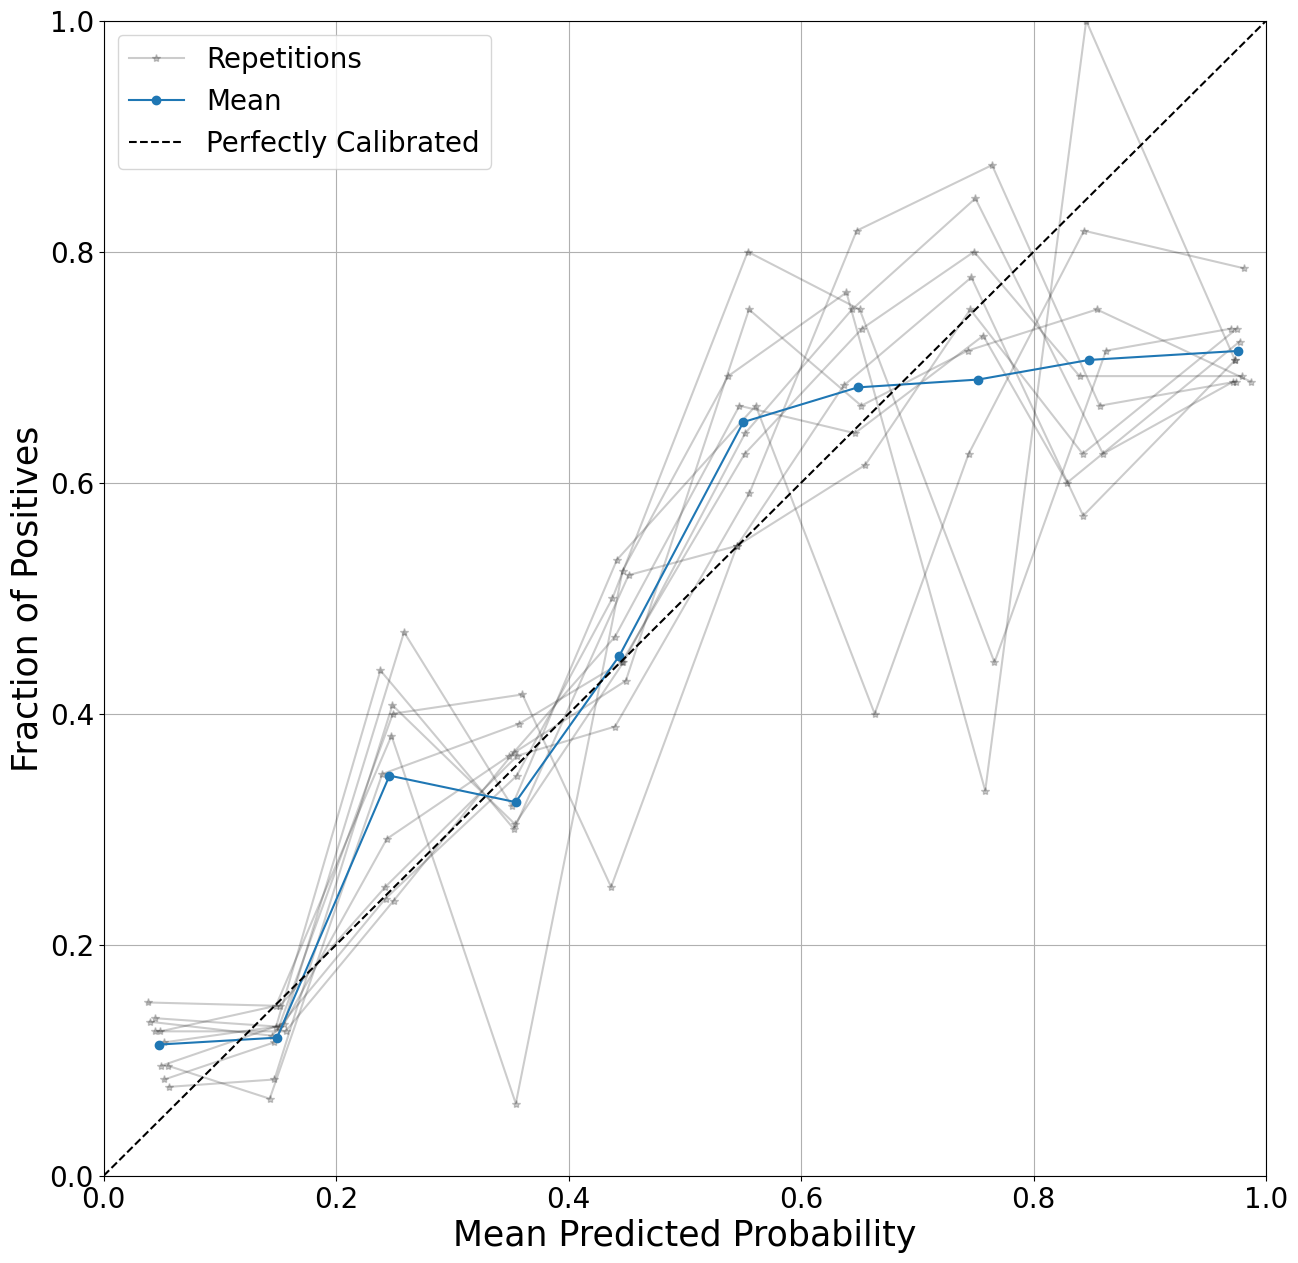

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/complete/"

y_true = pd.read_csv(data_dir +"y_true_Full_complete_new_hyper.csv", index_col=0)
y_pred = pd.read_csv(data_dir +"predictions_LG_full_complete_new_hyper.csv", index_col=0)
import pandas as pd
import numpy as np

# Create a new DataFrame with the first 10 columns for each group
reshape_true = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_true.iloc[:,column]])

    reshape_true = pd.concat([reshape_true, new_col], axis=1)

reshape_true = reshape_true.dropna()
# Display the new DataFrame

# Create a new DataFrame with the first 10 columns for each group
reshape_pred = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_pred.iloc[:,column]])

    reshape_pred = pd.concat([reshape_pred, new_col], axis=1)

reshape_pred = reshape_pred.dropna()


plt.figure(figsize=(15, 15))
for fold in range(reshape_pred.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        reshape_true.iloc[:, fold], reshape_pred.iloc[:, fold], n_bins=10, strategy='uniform'
    )
    if fold == 0:
        plt.plot(mean_predicted_value, fraction_of_positives, label='Repetitions', marker='*', alpha=0.2, color="black")

        fraction_of_positives_mean = fraction_of_positives
        mean_predicted_value_mean = mean_predicted_value
    else:
        plt.plot(mean_predicted_value, fraction_of_positives,  marker='*', alpha=0.2, color="black")

        fraction_of_positives_mean += fraction_of_positives
        mean_predicted_value_mean += mean_predicted_value

fraction_of_positives_mean = fraction_of_positives_mean/10
mean_predicted_value_mean = mean_predicted_value_mean/10

plt.plot(mean_predicted_value_mean, fraction_of_positives_mean, label='Mean', marker='o')

lim = [0,1]
# Plot the diagonal line for perfect calibration
plt.plot(lim, lim, linestyle='--', color='black', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.xlim(lim)
plt.ylim(lim)
plt.grid()
plt.show()

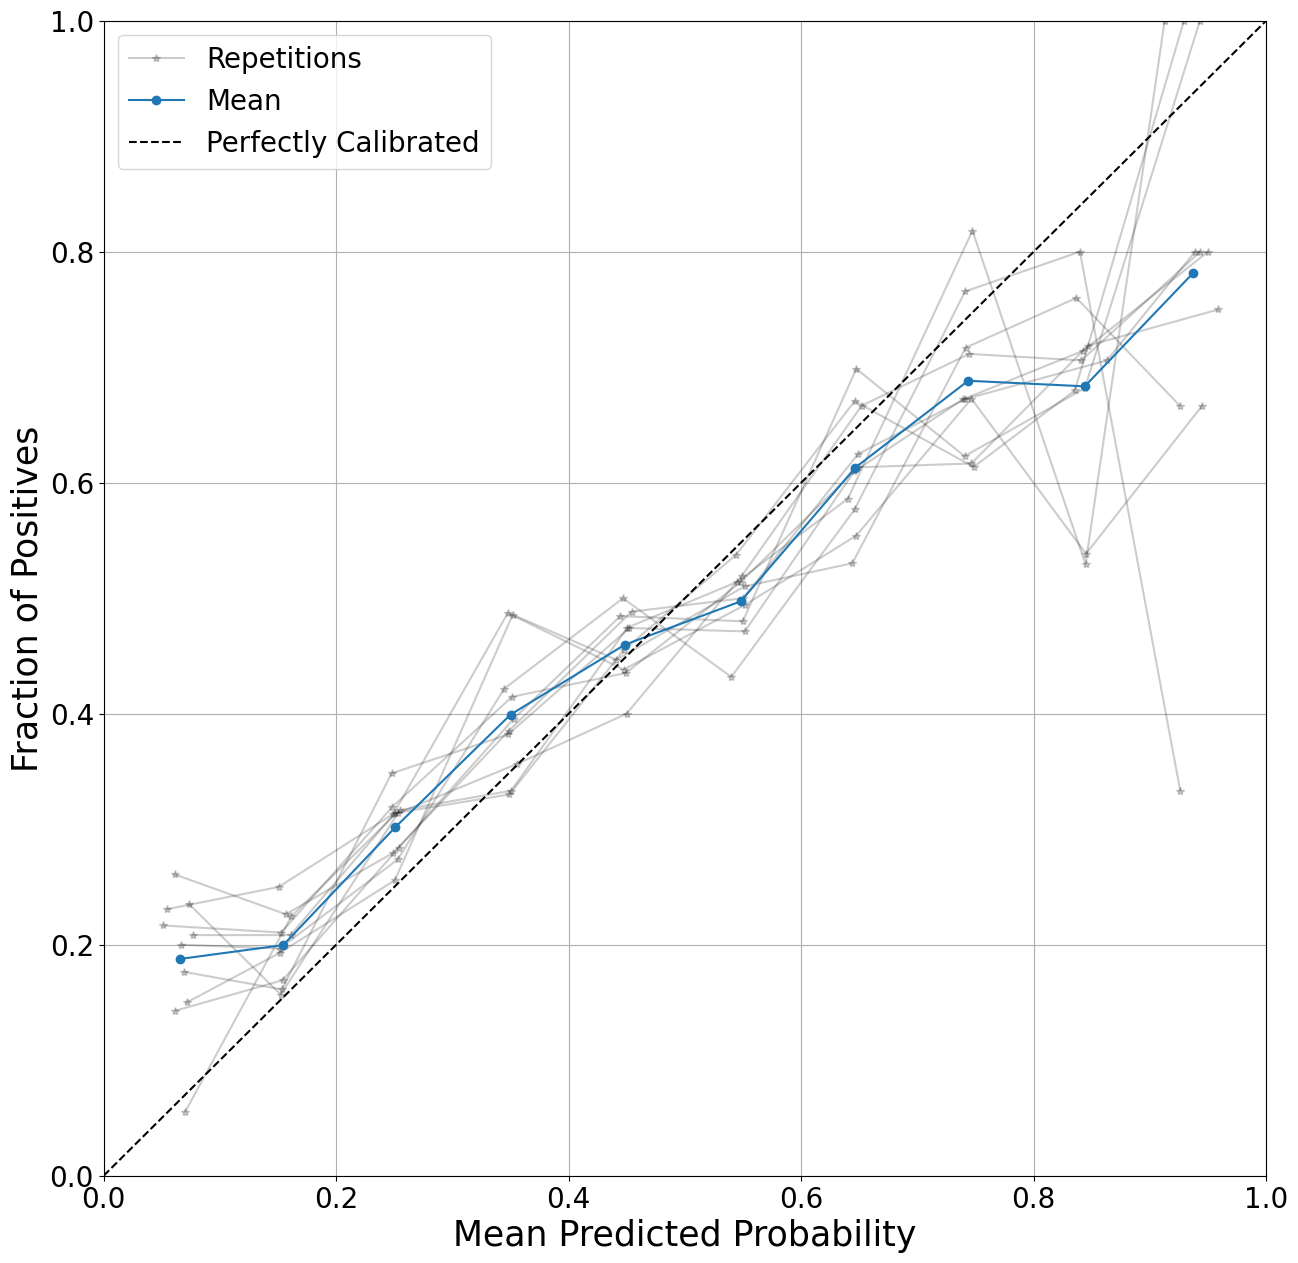

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/imputed_data/"

y_true = pd.read_csv(data_dir +"y_true_Admission_complete_imp.csv", index_col=0)
y_pred = pd.read_csv(data_dir +"predictions_Admission_complete.csv", index_col=0)
import pandas as pd
import numpy as np

# Create a new DataFrame with the first 10 columns for each group
reshape_true = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_true.iloc[:,column]])

    reshape_true = pd.concat([reshape_true, new_col], axis=1)

reshape_true = reshape_true.dropna()
# Display the new DataFrame

# Create a new DataFrame with the first 10 columns for each group
reshape_pred = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_pred.iloc[:,column]])

    reshape_pred = pd.concat([reshape_pred, new_col], axis=1)

reshape_pred = reshape_pred.dropna()


plt.figure(figsize=(15, 15))
for fold in range(reshape_pred.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        reshape_true.iloc[:, fold], reshape_pred.iloc[:, fold], n_bins=10, strategy='uniform'
    )
    if fold == 0:
        plt.plot(mean_predicted_value, fraction_of_positives, label='Repetitions', marker='*', alpha=0.2, color="black")

        fraction_of_positives_mean = fraction_of_positives
        mean_predicted_value_mean = mean_predicted_value
    else:
        plt.plot(mean_predicted_value, fraction_of_positives,  marker='*', alpha=0.2, color="black")

        fraction_of_positives_mean += fraction_of_positives
        mean_predicted_value_mean += mean_predicted_value

fraction_of_positives_mean = fraction_of_positives_mean/10
mean_predicted_value_mean = mean_predicted_value_mean/10

plt.plot(mean_predicted_value_mean, fraction_of_positives_mean, label='Mean', marker='o')

lim = [0,1]
# Plot the diagonal line for perfect calibration
plt.plot(lim, lim, linestyle='--', color='black', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.xlim(lim)
plt.ylim(lim)
plt.grid()
plt.show()

In [23]:
print(y_true.shape)
print("Reshape")
print(reshape_true.shape)

(61, 100)
Reshape
(610, 10)


In [24]:
print(y_pred.shape)
print("Reshape")
print(reshape_pred.shape)

(100, 61)
Reshape
(1000, 6)


In [43]:
model_param = pd.read_csv("/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/imputed_data/Best_Admission_imp_model_parameters.csv")

In [44]:
model_param.mean()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Unnamed: 0              49.500000
Fold                    49.500000
Random State             0.000000
Random Permutation       0.000000
Number of Estimators    14.410000
alpha                    0.113927
lambda                   0.271177
eta                      0.390267
max_depth                2.200000
dtype: float64

In [49]:
# Define the hyperparameters to tune
params_optuna = {
    "objective": "binary:logistic",
    'eval_metric': 'auc',
    'optuna_trials': 100,
    'random_state': 23,
    'max_depth_min': 1,
    'max_depth_max': 5,
    'alpha_min': 1e-8,
    'alpha_max': 10,
    'lambda_min': 1e-8,
    'lambda_max': 100,
    'eta_min': 0.1,
    'eta_max': 1,
    "early_stopping_rounds": 100,
    "num_boost_round": 10000,
}

Text(0.5, 1.0, 'alpha')

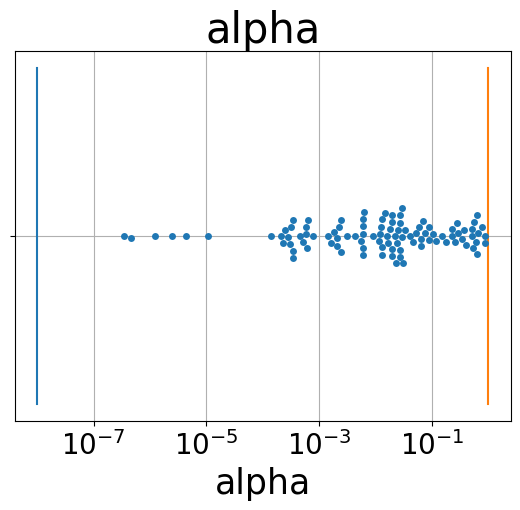

In [59]:
import seaborn as sbn
parameter = "alpha"
sbn.swarmplot(data=model_param, x=parameter)
plt.xscale("log")
plt.grid()
plt.plot([params_optuna[parameter+"_min"],params_optuna[parameter+"_min"]], [-0.5,0.5])
plt.plot([params_optuna[parameter+"_max"],params_optuna[parameter+"_max"]], [-0.5,0.5])


45.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


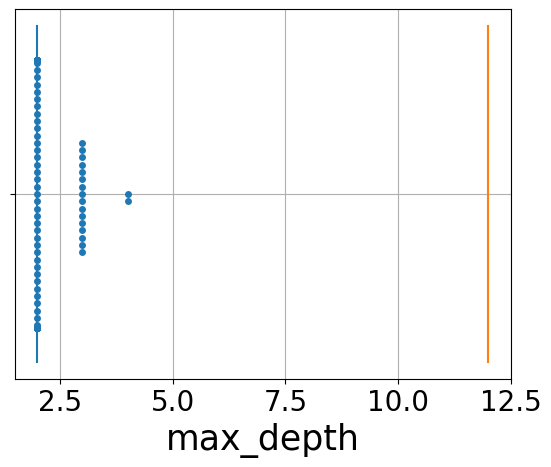

In [61]:
import seaborn as sbn
parameter = "max_depth"
sbn.swarmplot(data=model_param, x=parameter)
plt.grid()
plt.plot([params_optuna[parameter+"_min"],params_optuna[parameter+"_min"]], [-0.5,0.5])
plt.plot([params_optuna[parameter+"_max"],params_optuna[parameter+"_max"]], [-0.5,0.5])


Text(0.5, 1.0, 'lambda')

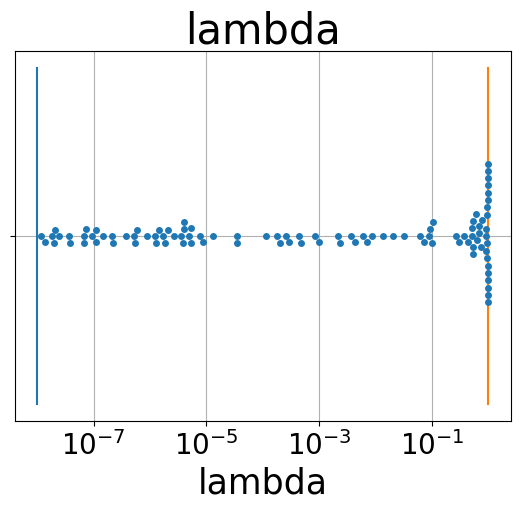

In [57]:
import seaborn as sbn
parameter = "lambda"
sbn.swarmplot(data=model_param, x=parameter)
plt.xscale("log")
plt.grid()
plt.plot([params_optuna[parameter+"_min"],params_optuna[parameter+"_min"]], [-0.5,0.5])
plt.plot([params_optuna[parameter+"_max"],params_optuna[parameter+"_max"]], [-0.5,0.5])


Text(0.5, 1.0, 'eta')

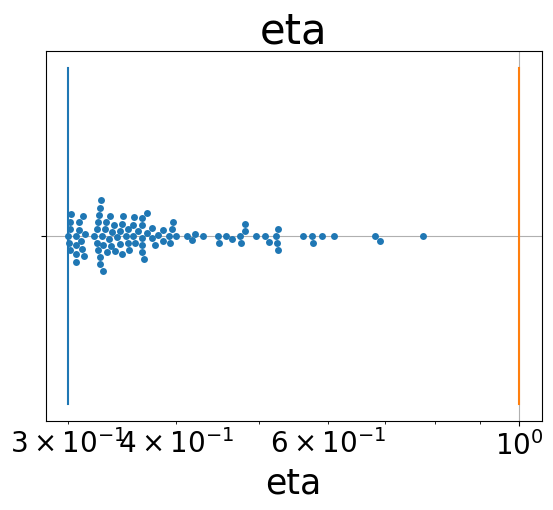

In [58]:
import seaborn as sbn
parameter = "eta"
sbn.swarmplot(data=model_param, x=parameter)
plt.xscale("log")
plt.grid()
plt.plot([params_optuna[parameter+"_min"],params_optuna[parameter+"_min"]], [-0.5,0.5])
plt.plot([params_optuna[parameter+"_max"],params_optuna[parameter+"_max"]], [-0.5,0.5])


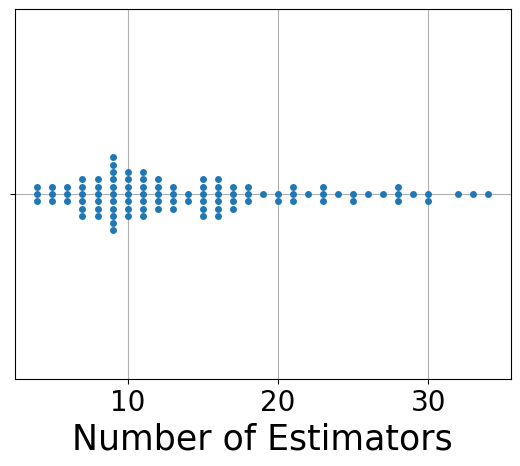

In [60]:
import seaborn as sbn
parameter = "Number of Estimators"
sbn.swarmplot(data=model_param, x=parameter)
plt.grid()



In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Generate synthetic data
np.random.seed(42)
n_samples = 10000
n_features = 10

# Simulate features
X = np.random.randn(n_samples, n_features)

# Simulate class labels with imbalance
fraud_rate = 0.05  # 5% of transactions are fraudulent
y = np.random.choice([0, 1], size=n_samples, p=[1 - fraud_rate, fraud_rate])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict probabilities for test set
y_proba = rf_clf.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_proba)
print("AUC:", auc)


AUC: 0.5060533757511487


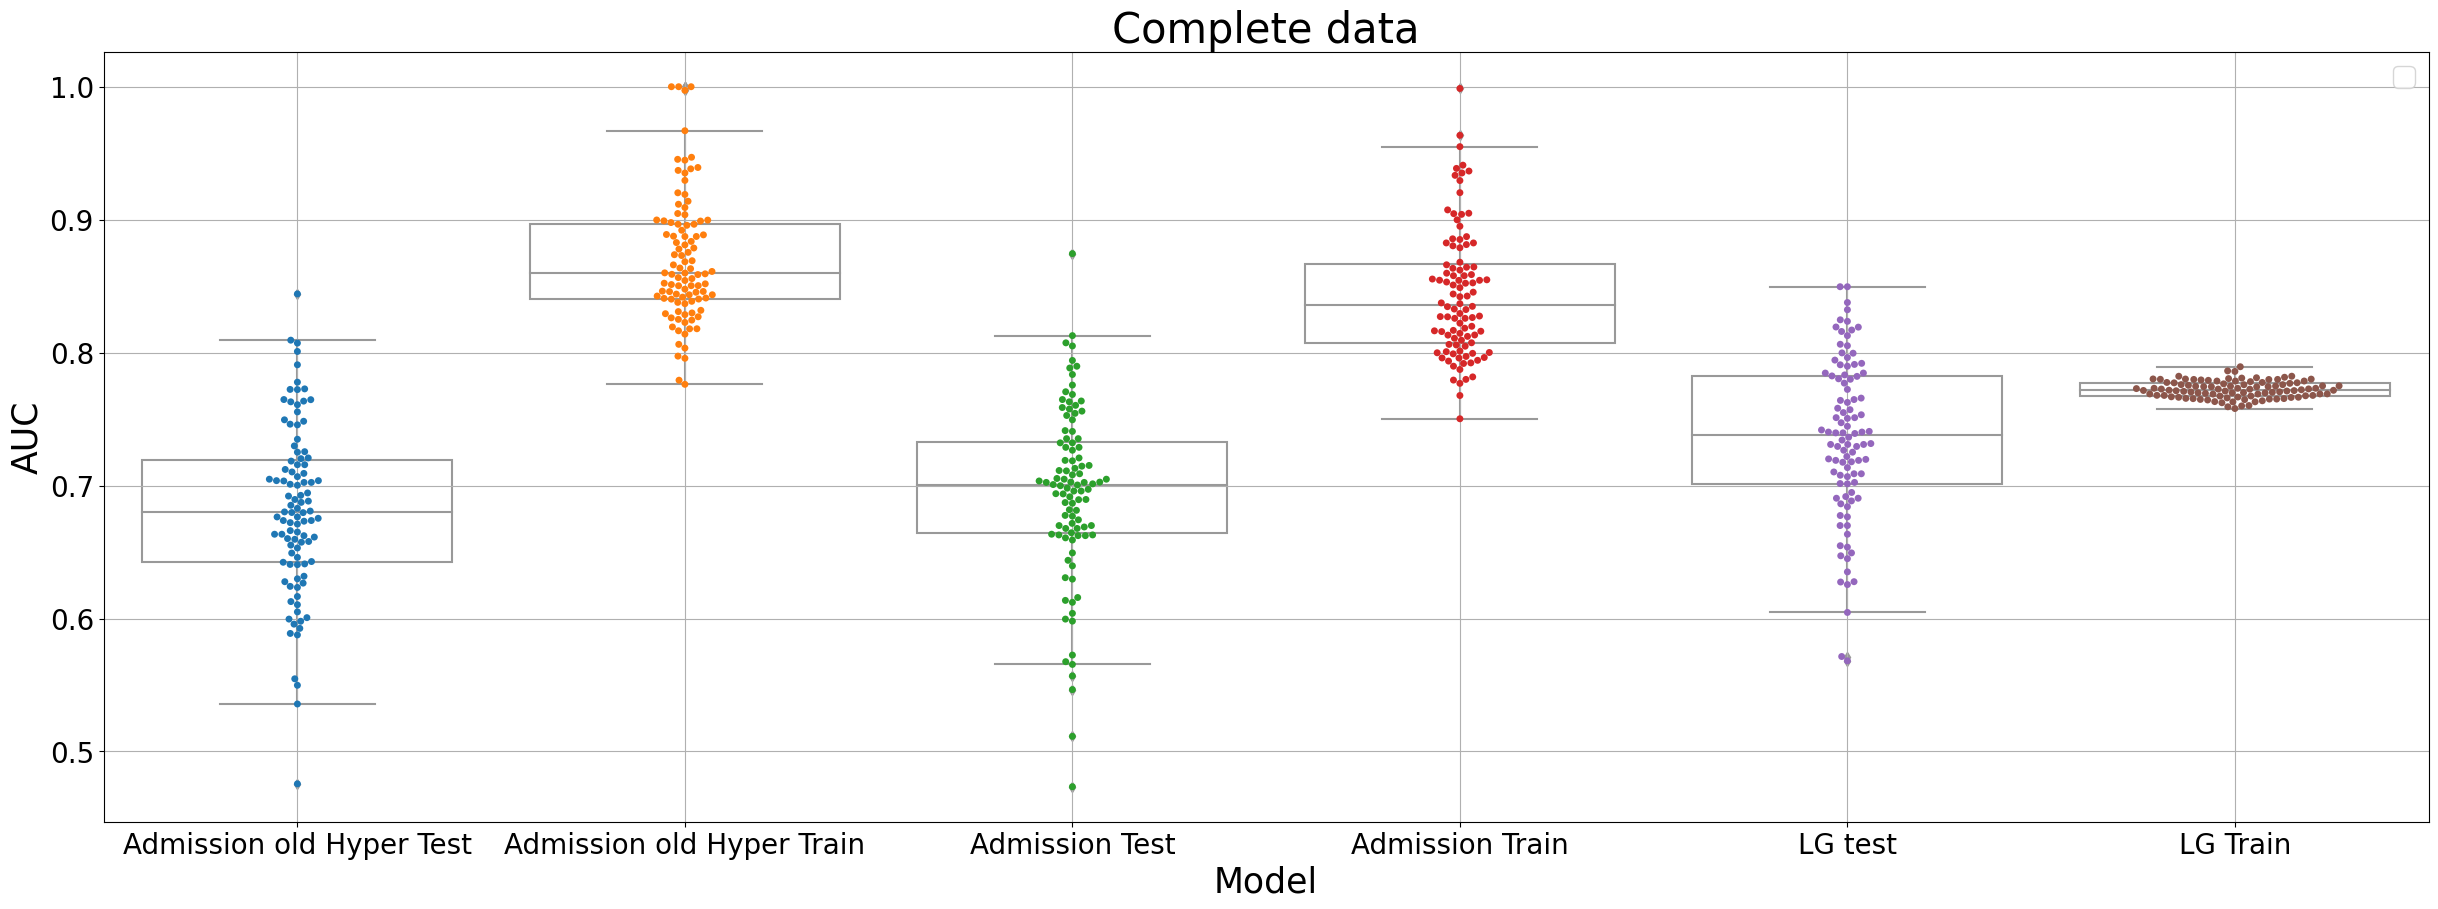

In [68]:

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/complete/"

results_admission_old = pd.read_csv(results_dir + "Admission_compleat.csv", index_col=0)

results_admission_old = results_admission_old[results_admission_old["Thresholds"] == 0.5]
results_admission_old = results_admission_old[results_admission_old["Number of Removed Features"] == 0]

results_admission_old["Random State"] =  False
# 
results_admission_old["Model"].replace({"Admission_imp": "Admission old Hyper Test"}, inplace=True)

results_admission_train_old = pd.read_csv(results_dir + "Admission_compleat_training.csv", index_col=0)
results_admission_train_old = results_admission_train_old[results_admission_train_old["Thresholds"] == 0.5]
results_admission_train_old = results_admission_train_old[results_admission_train_old["Number of Removed Features"] == 0]
results_admission_train_old["Random State"] =  False


results_admission_train_old["Model"].replace({"Admission Train _Imp": "Admission old Hyper Train"}, inplace=True)


results_admission_imp = pd.read_csv(results_dir + "Admission_compleat_new_hyper.csv", index_col=0)

results_admission_imp = results_admission_imp[results_admission_imp["Thresholds"] == 0.5]
results_admission_imp = results_admission_imp[results_admission_imp["Number of Removed Features"] == 0]

results_admission_imp["Random State"] =  False
# 

results_admission_train_imp = pd.read_csv(results_dir + "Admission_compleat_training_new_hyper.csv", index_col=0)
results_admission_train_imp = results_admission_train_imp[results_admission_train_imp["Thresholds"] == 0.5]
results_admission_train_imp = results_admission_train_imp[results_admission_train_imp["Number of Removed Features"] == 0]
results_admission_train_imp["Random State"] =  False



LG_imp = pd.read_csv(results_dir + "LG_Admission_compleat_new_hyper.csv", index_col=0)




results = pd.concat([results_admission_old, results_admission_train_old, results_admission_imp, results_admission_train_imp,LG_imp])
results["Model"].replace({"Admission_imp": "Admission Test",
                          "Admission Train _Imp": "Admission Train",
                          "LG_imputed_admission_test": "LG test",
                          "LG_imputed_admission_train": "LG Train"}, inplace=True)
# 
results_true_label = results[results["Random State"]== False]

# results_true_label.replace({"Admission_Train": "Admission Train", "24hs_Train": "Full Train"}, inplace= True)

metric_to_plot = "AUC"

# models_to_plot = ['Admission', 'Admission Train', 'Admission Imputed',
#                     'Admission Imputed Train', 'LG', 'LG Train' ]

fig, ax = plt.subplots(1, 1, figsize=[30, 10])

sns.swarmplot(
    data=results_true_label,
    x="Model", y=metric_to_plot,
    # order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
    # palette=[[1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           [1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           ]
)

sns.boxplot(
    data=results_true_label, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    # order=models_to_plot,
    dodge=True, ax=ax
)
plt.title("Complete data")
plt.legend([])
plt.grid()

In [64]:

results_admission_imp[results_admission_imp["Model"]=="Admission_imp"].mean()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Fold                          49.500000
Random State                   0.000000
Random Permutation Number      0.000000
Thresholds                     0.500000
Number of Removed Features     0.000000
Balanced ACC                   0.635242
AUC                            0.694776
F1                             0.581855
Specificity                    0.713619
Sensitivity                    0.556865
Recall                         0.556865
dtype: float64

In [69]:
params_optuna = {
    "objective": "binary:logistic",
    'eval_metric': 'auc',
    'optuna_trials': 100,
    'random_state': 23,
    'max_depth_min': 1,
    'max_depth_max': 5,
    'alpha_min': 1e-8,
    'alpha_max': 10,
    'lambda_min': 1e-8,
    'lambda_max': 100,
    'eta_min': 0.1,
    'eta_max': 1,
    "early_stopping_rounds": 100,
    "num_boost_round": 10000,
}
model_param = pd.read_csv("/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/complete/Best_Admission_model_parameters_complete_new_hyper.csv")

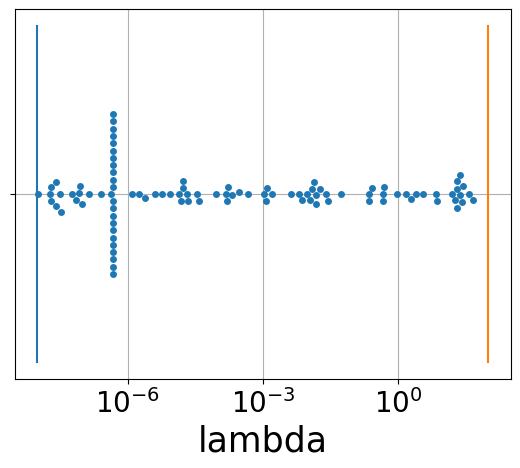

In [75]:
import seaborn as sbn
parameter = "alpha"
sbn.swarmplot(data=model_param, x=parameter)
plt.grid()
plt.xscale("log")
plt.plot([params_optuna[parameter+"_min"],params_optuna[parameter+"_min"]], [-0.5,0.5])
plt.plot([params_optuna[parameter+"_max"],params_optuna[parameter+"_max"]], [-0.5,0.5])


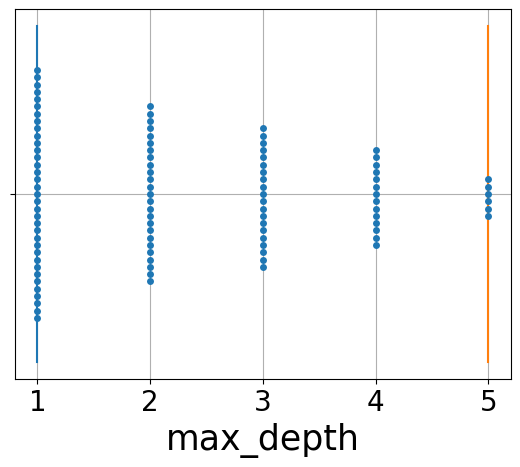

In [77]:
import seaborn as sbn
parameter = "max_depth"
sbn.swarmplot(data=model_param, x=parameter)
plt.grid()
plt.xscale("linear")
plt.plot([params_optuna[parameter+"_min"],params_optuna[parameter+"_min"]], [-0.5,0.5])
plt.plot([params_optuna[parameter+"_max"],params_optuna[parameter+"_max"]], [-0.5,0.5])


15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


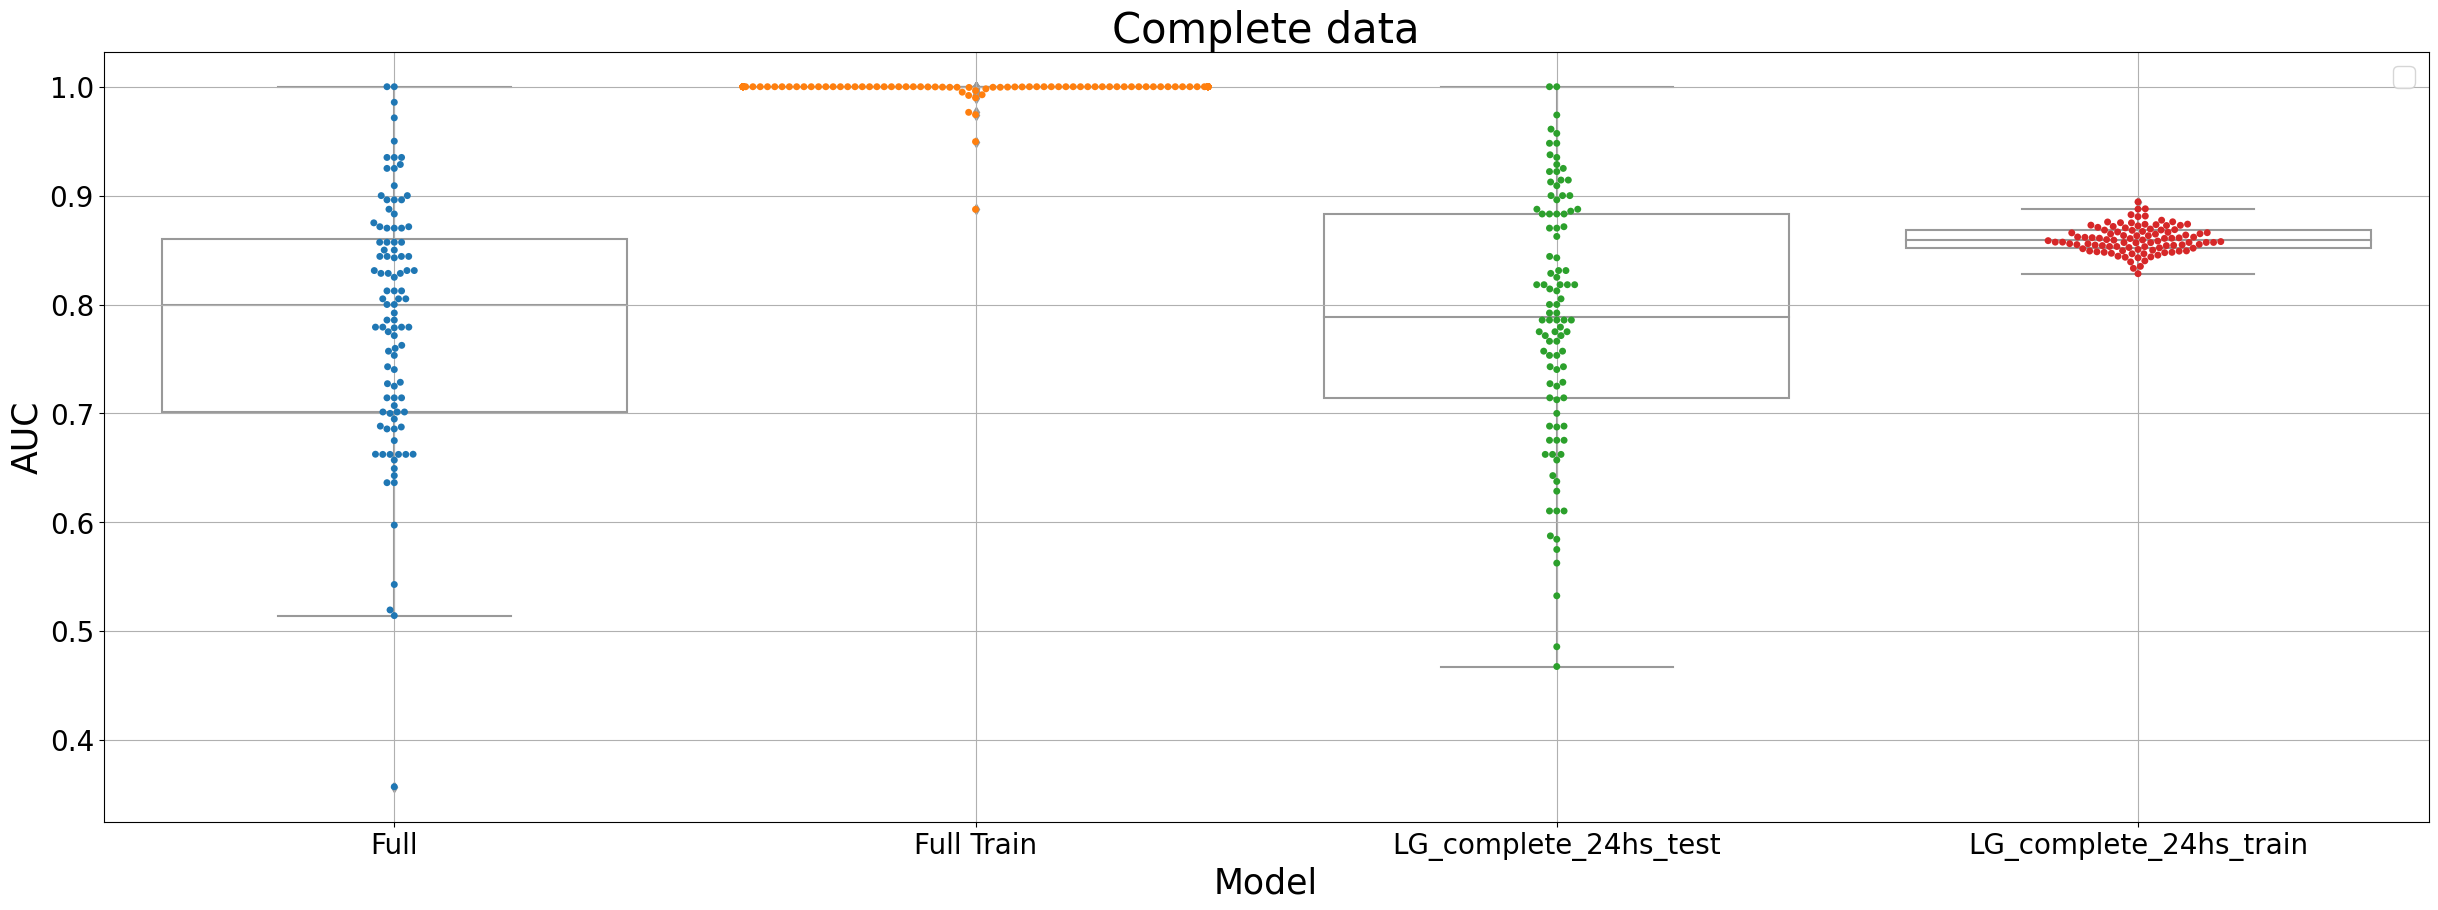

In [3]:

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/complete/"

results_admission_old = pd.read_csv(results_dir + "Full_complete.csv", index_col=0)
results_admission_old = results_admission_old[results_admission_old["Thresholds"] == 0.5]
results_admission_old = results_admission_old[results_admission_old["Number of Removed Features"] == 0]

results_admission_old["Random State"] =  False

results_admission_train_old = pd.read_csv(results_dir + "Full_complete_training.csv", index_col=0)

results_admission_train_old = results_admission_train_old[results_admission_train_old["Thresholds"] == 0.5]
results_admission_train_old = results_admission_train_old[results_admission_train_old["Number of Removed Features"] == 0]
results_admission_train_old["Random State"] =  False






LG_imp = pd.read_csv(results_dir + "LG_full_complete.csv", index_col=0)

results = pd.concat([results_admission_old, results_admission_train_old,LG_imp])
results["Model"].replace({"Admission_imp": "Admission Test",
                          "Admission Train _Imp": "Admission Train",
                          "LG_imputed_admission_test": "LG test",
                          "LG_imputed_admission_train": "LG Train"}, inplace=True)
# 
results_true_label = results[results["Random State"]== False]

metric_to_plot = "AUC"

fig, ax = plt.subplots(1, 1, figsize=[30, 10])

sns.swarmplot(
    data=results_true_label,
    x="Model", y=metric_to_plot,
    # order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
    # palette=[[1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           [1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           ]
)

sns.boxplot(
    data=results_true_label, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    # order=models_to_plot,
    dodge=True, ax=ax
)
plt.title("Complete data")
plt.legend([])
plt.grid()

47.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
51.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
51.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
51.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


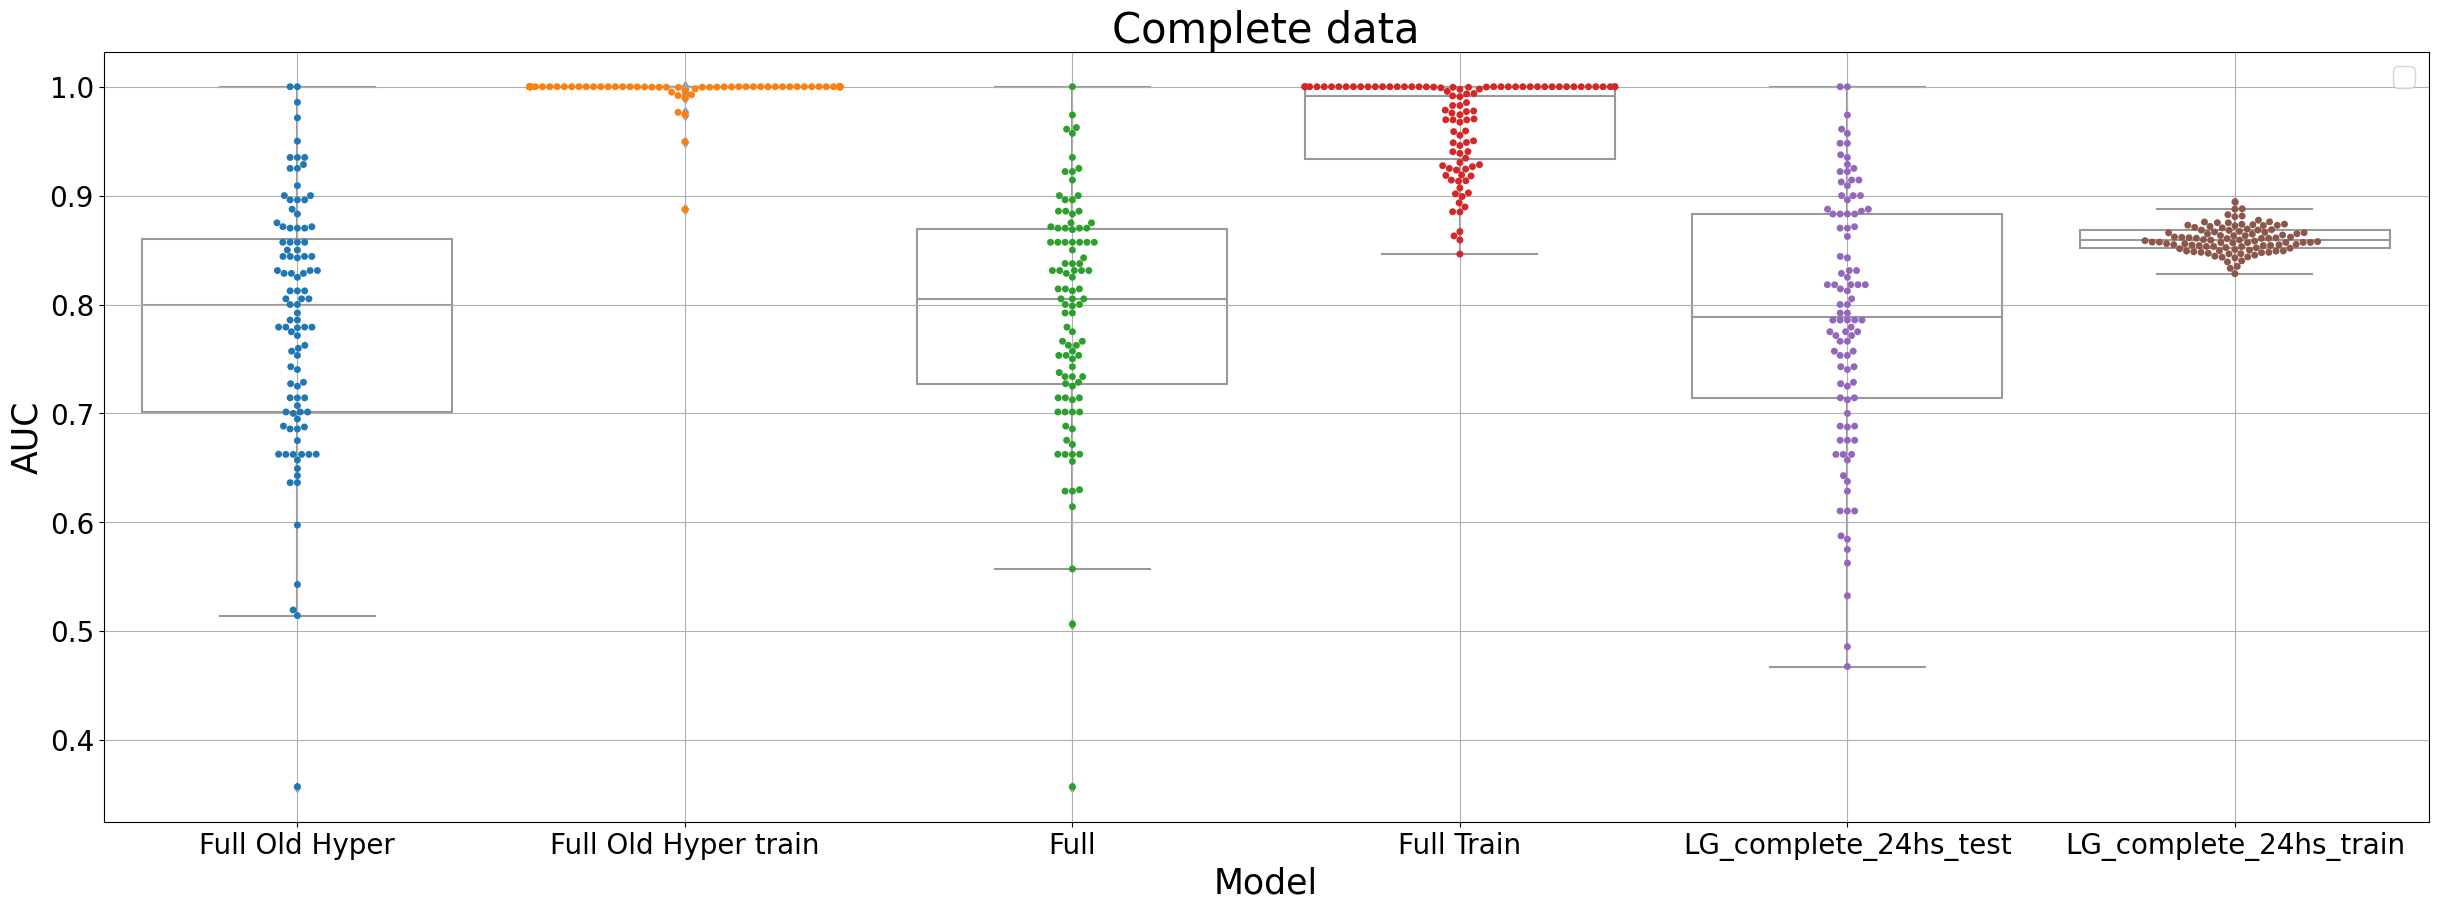

In [7]:

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/complete/"


results_admission_old = pd.read_csv(results_dir + "Full_complete.csv", index_col=0)
results_admission_old = results_admission_old[results_admission_old["Thresholds"] == 0.5]
results_admission_old = results_admission_old[results_admission_old["Number of Removed Features"] == 0]
results_admission_old["Model"].replace({"Full": "Full Old Hyper"},inplace=True)
results_admission_old["Random State"] =  False

results_admission_train_old = pd.read_csv(results_dir + "Full_complete_training.csv", index_col=0)

results_admission_train_old = results_admission_train_old[results_admission_train_old["Thresholds"] == 0.5]
results_admission_train_old = results_admission_train_old[results_admission_train_old["Number of Removed Features"] == 0]
results_admission_train_old["Random State"] =  False
results_admission_train_old["Model"].replace({"Full Train": "Full Old Hyper train"},inplace=True)


results_full = pd.read_csv(results_dir + "Full_complete_new_hyper.csv", index_col=0)
results_full = results_full[results_full["Thresholds"] == 0.5]
results_full = results_full[results_full["Number of Removed Features"] == 0]

results_full["Random State"] =  False

results_full_train = pd.read_csv(results_dir + "Full_complete_training_new_hyper.csv", index_col=0)

results_full_train = results_full_train[results_full_train["Thresholds"] == 0.5]
results_full_train = results_full_train[results_full_train["Number of Removed Features"] == 0]
results_full_train["Random State"] =  False






LG_imp = pd.read_csv(results_dir + "LG_full_complete_new_hyper.csv", index_col=0)

results = pd.concat([results_admission_old, results_admission_train_old,results_full, results_full_train, LG_imp])
results["Model"].replace({"Admission_imp": "Admission Test",
                          "Admission Train _Imp": "Admission Train",
                          "LG_imputed_admission_test": "LG test",
                          "LG_imputed_admission_train": "LG Train"}, inplace=True)
# 
results_true_label = results[results["Random State"]== False]

metric_to_plot = "AUC"

fig, ax = plt.subplots(1, 1, figsize=[30, 10])

sns.swarmplot(
    data=results_true_label,
    x="Model", y=metric_to_plot,
    # order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
    # palette=[[1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           [1, 0.1, 0.1],
    #                                           [0.1, 0.2, 0.2],
    #                                           ]
)

sns.boxplot(
    data=results_true_label, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    # order=models_to_plot,
    dodge=True, ax=ax
)
plt.title("Complete data")
plt.legend([])
plt.grid()

In [8]:
params_optuna = {
    "objective": "binary:logistic",
    'eval_metric': 'auc',
    'optuna_trials': 100,
    'random_state': 23,
    'max_depth_min': 2,
    'max_depth_max': 12,
    'alpha_min': 1e-8,
    'alpha_max': 1.0,
    'lambda_min': 1e-8,
    'lambda_max': 1.0,
    'eta_min': 0.3,
    'eta_max': 1,
    "early_stopping_rounds": 100,
    "num_boost_round": 10000,
}
model_param = pd.read_csv("/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/complete/Best_Full_complete_model_parameters.csv")

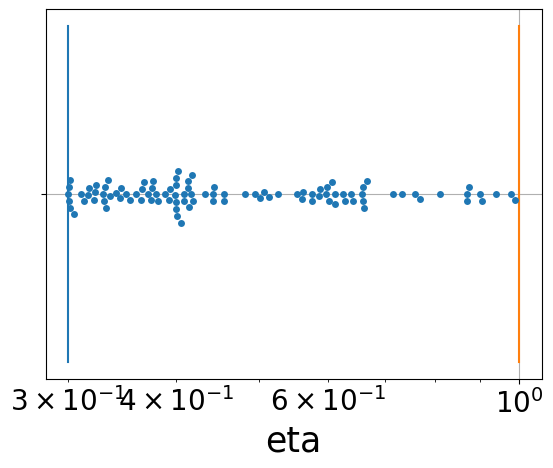

In [12]:
import seaborn as sbn
parameter = "eta"
sbn.swarmplot(data=model_param, x=parameter)
plt.grid()
plt.xscale("log")
plt.plot([params_optuna[parameter+"_min"],params_optuna[parameter+"_min"]], [-0.5,0.5])
plt.plot([params_optuna[parameter+"_max"],params_optuna[parameter+"_max"]], [-0.5,0.5])


# Samples predictions

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/complete/"

y_true = pd.read_csv(data_dir +"y_true_Admission_complete_imp_new_hyper.csv", index_col=0)
y_pred_LG = pd.read_csv(data_dir +"predictions_LG_Admission_complete_new_hyper.csv", index_col=0)
y_pred_admission = pd.read_csv(data_dir +"predictions_Admission_complete_new_hyper.csv", index_col=0)


# Create a new DataFrame with the first 10 columns for each group
reshape_true = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_true.iloc[:,column]])

    reshape_true = pd.concat([reshape_true, new_col], axis=1)

reshape_true = reshape_true.dropna()
# Display the new DataFrame

# Create a new DataFrame with the first 10 columns for each group
reshape_pred_LG = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_pred_LG.iloc[:,column]])

    reshape_pred_LG = pd.concat([reshape_pred_LG, new_col], axis=1)

reshape_pred_LG = reshape_pred_LG.dropna()

# Create a new DataFrame with the first 10 columns for each group
reshape_pred_xgb = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_pred_admission.iloc[:,column]])

    reshape_pred_xgb = pd.concat([reshape_pred_xgb, new_col], axis=1)

reshape_pred_xgb = reshape_pred_xgb.dropna()

In [129]:
fold_1_LG = reshape_pred_LG.iloc[:,0]
fold_1_true = reshape_true.iloc[:,0]
fold_1_ad = reshape_pred_xgb.iloc[:,0]


print("LG")
print(roc_auc_score(fold_1_true,fold_1_LG))
print("Admission")
print(roc_auc_score(fold_1_true,fold_1_ad))
print("Merge")
print(roc_auc_score(fold_1_true,(fold_1_LG+fold_1_ad)*0.5))



LG
0.7338398914518318
Admission
0.686371777476255
Merge
0.7230719131614656


In [131]:
pred_lg = (fold_1_LG >= 0.5).astype(int)
pred_ad = (fold_1_ad >= 0.5).astype(int)
print("LG")
print(roc_auc_score(fold_1_true,pred_lg))
print("Admission")
print(roc_auc_score(fold_1_true,pred_ad))
print("Merge")
print(roc_auc_score(fold_1_true,round((pred_lg+pred_ad)*0.5)))

LG
0.6780732700135687
Admission
0.643853459972863
Merge
0.6436363636363637


# Wrong classified by LG and rightly classified by Xgboost

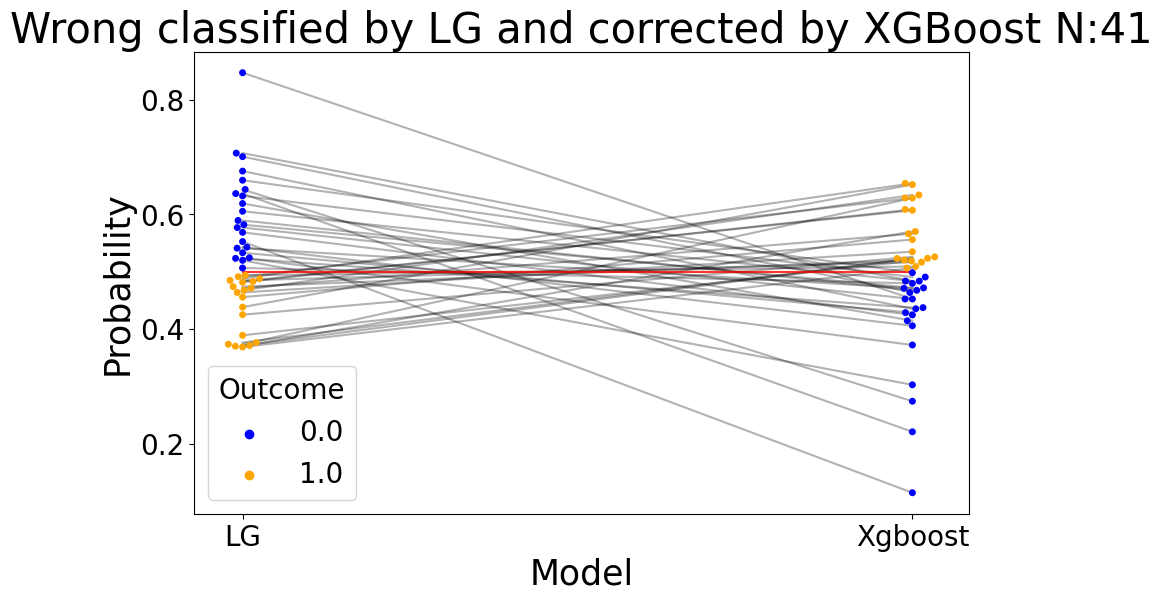

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pred_wrong_LG_by_LG = fold_1_LG[pred_lg!=fold_1_true]
pred_wrong_ad_by_LG = fold_1_ad[pred_lg!=fold_1_true]
pred_wrong_true_LG = fold_1_true[pred_lg!=fold_1_true]

pred_ad_2 = (pred_wrong_ad_by_LG >= 0.5).astype(int)


# Example probabilities from two models
model1_probabilities = pred_wrong_LG_by_LG
model1_probabilities = model1_probabilities[pred_ad_2==pred_wrong_true_LG]

model2_probabilities = pred_wrong_ad_by_LG

model2_probabilities = model2_probabilities[pred_ad_2==pred_wrong_true_LG]

ground_truth_labels = pred_wrong_true_LG
ground_truth_labels = pred_wrong_true_LG[pred_ad_2==pred_wrong_true_LG]


# Create a DataFrame
data = pd.DataFrame({'LG': model1_probabilities, 'Xgboost': model2_probabilities, 'Ground Truth': ground_truth_labels})

# Melt the DataFrame
melted_data = pd.melt(data, id_vars='Ground Truth', var_name='Model', value_name='Probability')

# Set the palette for binary ground truth labels (0: blue, 1: orange)
palette = {0: 'blue', 1: 'orange'}

# Plot the probabilities using a swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='Model', y='Probability', data=melted_data, hue='Ground Truth', palette=palette, dodge=False)

pal = sns.color_palette(['black'], data.shape[1])

# Add lines connecting the probabilities from both models
for i in range(len(model1_probabilities)):
    plt.plot([0, 1], [model1_probabilities.iloc[i], model2_probabilities.iloc[i]], 'k-', alpha=0.3)


plt.plot([0, 1], [0.5, 0.5], 'r-', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Probability')
plt.title('Wrong classified by LG and corrected by XGBoost N:' +str(len(model2_probabilities)))
plt.legend(title='Outcome')
plt.show()

# Wrongly classified by Xgboost and right by LG

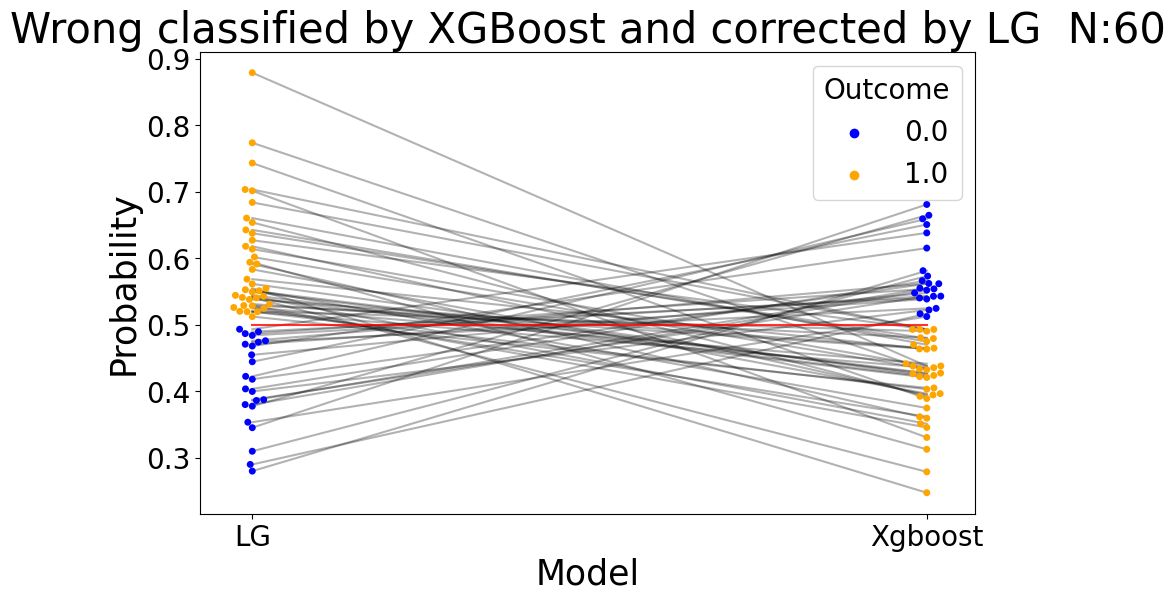

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pred_wrong_LG_by_xgb = fold_1_LG[pred_ad!=fold_1_true]
pred_wrong_ad_by_xgb = fold_1_ad[pred_ad!=fold_1_true]
pred_wrong_true_xgb = fold_1_true[pred_ad!=fold_1_true]

pred_LG_2 = (pred_wrong_LG_by_xgb >= 0.5).astype(int)

# Example probabilities from two models
model1_probabilities = pred_wrong_LG_by_xgb
model1_probabilities = model1_probabilities[pred_LG_2==pred_wrong_true_xgb]

model2_probabilities = pred_wrong_ad_by_xgb
model2_probabilities = model2_probabilities[pred_LG_2==pred_wrong_true_xgb]

ground_truth_labels = pred_wrong_true_xgb
ground_truth_labels = pred_wrong_true_xgb[pred_LG_2==pred_wrong_true_xgb]



# Create a DataFrame
data = pd.DataFrame({'LG': model1_probabilities, 'Xgboost': model2_probabilities, 'Ground Truth': ground_truth_labels})

# Melt the DataFrame
melted_data = pd.melt(data, id_vars='Ground Truth', var_name='Model', value_name='Probability')

# Set the palette for binary ground truth labels (0: blue, 1: orange)
palette = {0: 'blue', 1: 'orange'}

# Plot the probabilities using a swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='Model', y='Probability', data=melted_data, hue='Ground Truth', palette=palette, dodge=False)

pal = sns.color_palette(['black'], data.shape[1])

# Add lines connecting the probabilities from both models
for i in range(len(model1_probabilities)):
    plt.plot([0, 1], [model1_probabilities.iloc[i], model2_probabilities.iloc[i]], 'k-', alpha=0.3)


plt.plot([0, 1], [0.5, 0.5], 'r-', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Probability')
plt.title('Wrong classified by XGBoost and corrected by LG  N:' +str(len(model2_probabilities)))
plt.legend(title='Outcome')
plt.show()

# Right by Xgboost wrong by LG

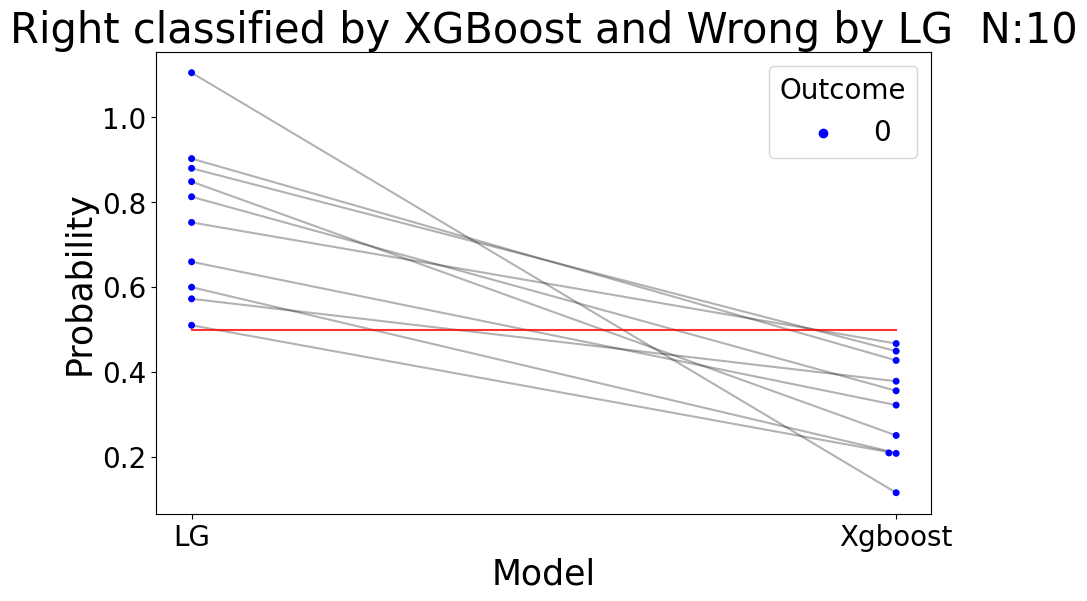

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pred_wrong_LG_by_xgb = fold_1_LG[pred_ad==fold_1_true]
pred_wrong_ad_by_xgb = fold_1_ad[pred_ad==fold_1_true]
pred_wrong_true_xgb = fold_1_true[pred_ad==fold_1_true]

pred_LG_2 = (pred_wrong_LG_by_xgb >= 0.5).astype(int)

# Example probabilities from two models
model1_probabilities = pred_wrong_LG_by_xgb
model1_probabilities = model1_probabilities[pred_LG_2!=pred_wrong_true_xgb]

model2_probabilities = pred_wrong_ad_by_xgb
model2_probabilities = model2_probabilities[pred_LG_2!=pred_wrong_true_xgb]

ground_truth_labels = pred_wrong_true_xgb
ground_truth_labels = pred_wrong_true_xgb[pred_LG_2!=pred_wrong_true_xgb]



# Create a DataFrame
data = pd.DataFrame({'LG': model1_probabilities, 'Xgboost': model2_probabilities, 'Ground Truth': ground_truth_labels})

# Melt the DataFrame
melted_data = pd.melt(data, id_vars='Ground Truth', var_name='Model', value_name='Probability')

# Set the palette for binary ground truth labels (0: blue, 1: orange)
palette = {0: 'blue', 1: 'orange'}

# Plot the probabilities using a swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='Model', y='Probability', data=melted_data, hue='Ground Truth', palette=palette, dodge=False)

pal = sns.color_palette(['black'], data.shape[1])

# Add lines connecting the probabilities from both models
for i in range(len(model1_probabilities)):
    plt.plot([0, 1], [model1_probabilities.iloc[i], model2_probabilities.iloc[i]], 'k-', alpha=0.3)


plt.plot([0, 1], [0.5, 0.5], 'r-', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Probability')
plt.title('Right classified by XGBoost and Wrong by LG  N:' +str(len(model2_probabilities)))
plt.legend(title='Outcome')
plt.show()

<AxesSubplot: ylabel='0'>

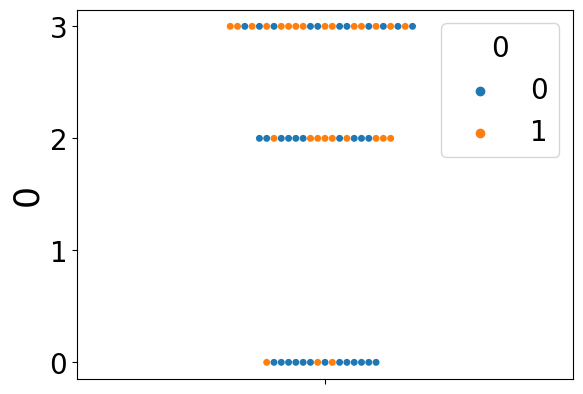

In [161]:


sbn.swarmplot(y=pred_combined, hue=fold_1_true)

In [175]:
fold_1_LG = reshape_pred_LG.iloc[:,0]

fold_1_ad = reshape_pred_xgb.iloc[:,0]

prob_difference = fold_1_LG-fold_1_ad

fold_1_true = reshape_true.iloc[:,0]


pred_lg = (fold_1_LG >= 0.5).astype(int)*2
pred_ad = (fold_1_ad >= 0.5).astype(int)
pred_combined = pred_lg+pred_ad

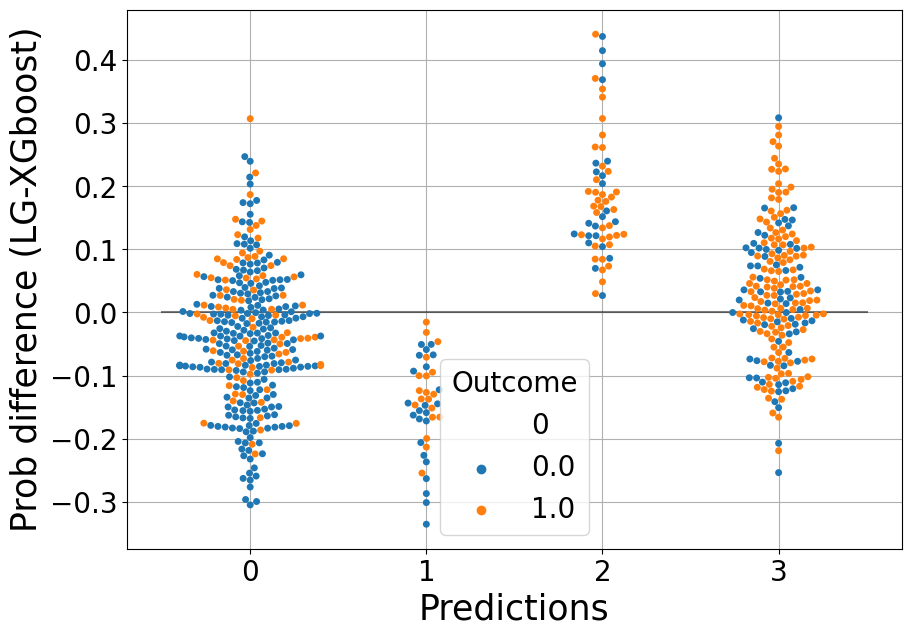

In [187]:
plt.figure(figsize=[10,7])
sbn.swarmplot(y=prob_difference, x=pred_combined, hue=fold_1_true)
plt.plot([-0.5,3.5],[0,0],"k-", alpha=0.5)


plt.grid()
plt.xlabel("Predictions")
plt.ylabel("Prob difference (LG-XGboost)")
plt.legend(title="Outcome")

In [192]:
fold_1_LG = reshape_pred_LG.iloc[:,0]

fold_1_ad = reshape_pred_xgb.iloc[:,0]-0.5

prob_difference = fold_1_LG+fold_1_ad


print("LG")
print(roc_auc_score(fold_1_true,fold_1_LG))
print("Admission")
print(roc_auc_score(fold_1_true,fold_1_ad))
print("Merge")
print(roc_auc_score(fold_1_true,prob_difference))


LG
0.7338398914518318
Admission
0.686371777476255
Merge
0.7230719131614656


In [197]:
fold_1_LG = reshape_pred_LG.iloc[:,0]
pred_lg = (fold_1_LG >= 0.5).astype(int)

fold_1_ad = reshape_pred_xgb.iloc[:,0]
pred_ad = (fold_1_ad >= 0.5).astype(int)

fold_1_ad = reshape_pred_xgb.iloc[:,0]-0.5

prob_difference = fold_1_LG+fold_1_ad
pred_difference = (prob_difference >= 0.5).astype(int)

print("LG")
print(balanced_accuracy_score(fold_1_true,pred_lg))
print("Admission")
print(balanced_accuracy_score(fold_1_true,pred_ad))
print("Merge")
print(balanced_accuracy_score(fold_1_true,pred_difference))

LG
0.6780732700135685
Admission
0.6438534599728629
Merge
0.6605427408412483


Text(0.5, 41.7222222222222, 'Model Agreement: 0 Both agree No risk. 1- Xgb predicts Risk - 2 LG predicts Risk - 3 Both agree Risk')

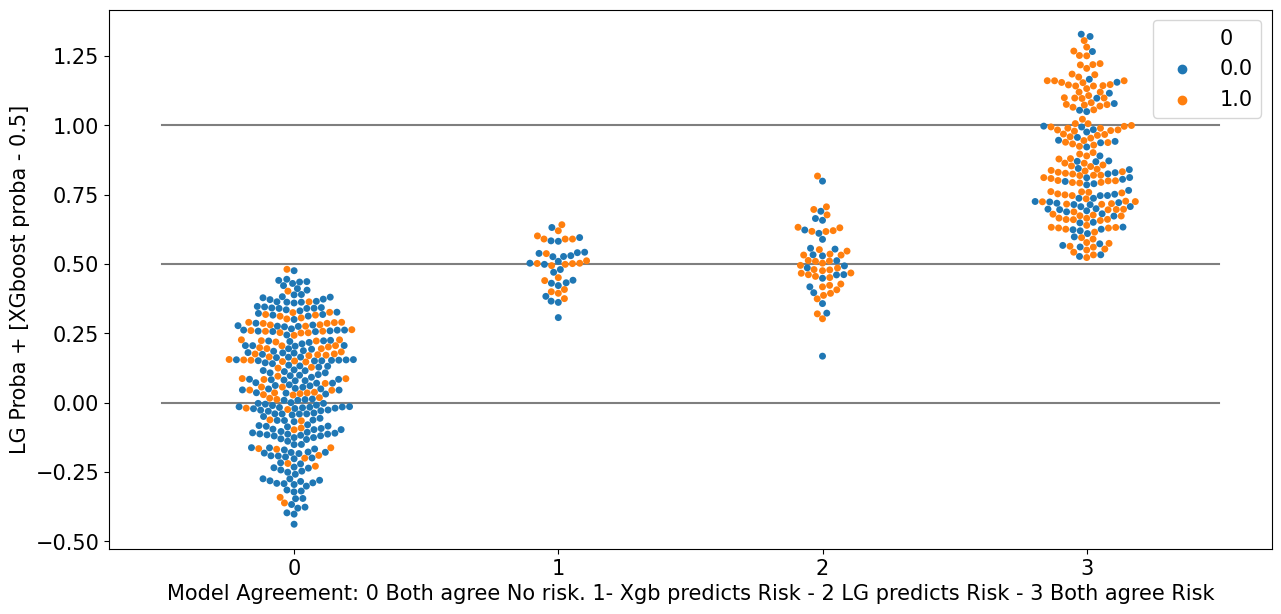

In [221]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=[15,7])
sbn.swarmplot(y=prob_difference, x=pred_combined, hue=fold_1_true)
plt.ylabel("LG Proba + [XGboost proba - 0.5]")
plt.plot([-0.5,3.5],[0,0],"k-", alpha=0.5)
plt.plot([-0.5,3.5],[0.5,0.5],"k-", alpha=0.5)
plt.plot([-0.5,3.5],[1,1],"k-", alpha=0.5)
plt.xlabel("Model Agreement: 0 Both agree No risk. 1- Xgb predicts Risk - 2 LG predicts Risk - 3 Both agree Risk")